In [1476]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from math import ceil
import os
import seaborn as sns


In [1477]:
df = pd.read_csv('../project_data/train.csv', sep = ',', index_col = 'encounter_id')
test = pd.read_csv('../project_data/test.csv', sep = ',', index_col = 'encounter_id')

In [1478]:
df.head()

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,USA,70110,Caucasian,Female,[70-80),?,?,0,0,2,...,276,466,8,NaN,NaN,No,No,[],No,>30 days
426224,USA,29775006,AfricanAmerican,Male,[50-60),?,?,0,0,0,...,785,162,9,NaN,NaN,No,Yes,['insulin'],No,No
634063,USA,80729253,Caucasian,Female,[60-70),?,?,0,0,1,...,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']",No,No
890610,USA,2919042,AfricanAmerican,Male,[60-70),?,MC,0,0,1,...,562,455,5,NaN,NaN,No,No,[],No,No
654194,USA,84871971,Caucasian,Female,[70-80),?,HM,1,0,0,...,599,428,9,NaN,NaN,No,No,[],No,>30 days


In [1479]:
df.shape  #71236 records

(71236, 30)

In [1480]:
df.dtypes

country                                  object
patient_id                                int64
race                                     object
gender                                   object
age                                      object
weight                                   object
payer_code                               object
outpatient_visits_in_previous_year        int64
emergency_visits_in_previous_year         int64
inpatient_visits_in_previous_year         int64
admission_type                           object
medical_specialty                        object
average_pulse_bpm                         int64
discharge_disposition                    object
admission_source                         object
length_of_stay_in_hospital                int64
number_lab_tests                          int64
non_lab_procedures                        int64
number_of_medications                     int64
primary_diagnosis                        object
secondary_diagnosis                     

In [1481]:
df.isna().sum()

country                                      0
patient_id                                   0
race                                      3554
gender                                       0
age                                       3557
weight                                       0
payer_code                                   0
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            3706
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                     2590
admission_source                          4718
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_diagnosis                          0
additional_di

In [1482]:
# We notice that there are some columns with the value '?', so we will replace all '?' and '' by Nan
# Ensure that missing data is uniformly represented in the dataset, whether it was initially recorded as '?' or an empty string.

# replace "" and "?" by nans

df.replace("", np.nan, inplace=True)
df.replace("?", np.nan, inplace=True)
test.replace("", np.nan, inplace=True)
test.replace("?", np.nan, inplace=True)

In [1483]:
# 'change_in_meds_during_hospitalization' values: “change” (True) and “no change” (False)
# 'prescribed_diabetes_meds' values: "yes" and "no"
# 'readmitted_binary' values: "yes" (True) and "no" (False)

# converting it to a boolean will make it easier to work with as a binary indicator
# Booleans are a natural choice for binary indicators where you have only two possible values

df['readmitted_binary'] = df['readmitted_binary'].map({'Yes': 1, 'No': 0})
df['readmitted_binary'] = df['readmitted_binary'].astype(bool)

# preparing the target ('readmitted_multiclass') variable in a multiclass classification task
# assign to 'readmitted_multiclass' a unique integer value to each class, which is often more suitable for machine learning algorithms
class_mapping = {'<30 days': 1, '>30 days': 2, 'No': 0}
df['readmitted_multiclass'] = df['readmitted_multiclass'].map(class_mapping)
df['readmitted_multiclass'] = df['readmitted_multiclass'].astype(int)

df['change_in_meds_during_hospitalization'] = df['change_in_meds_during_hospitalization'].map({'Ch': 1, 'No': 0})
df['change_in_meds_during_hospitalization'] = df['change_in_meds_during_hospitalization'].astype(bool)
test['change_in_meds_during_hospitalization'] = test['change_in_meds_during_hospitalization'].map({'Ch': 1, 'No': 0})
test['change_in_meds_during_hospitalization'] = test['change_in_meds_during_hospitalization'].astype(bool)

df['prescribed_diabetes_meds'] = df['prescribed_diabetes_meds'].map({'Yes': 1, 'No': 0})
df['prescribed_diabetes_meds'] = df['prescribed_diabetes_meds'].astype(bool)
test['prescribed_diabetes_meds'] = test['prescribed_diabetes_meds'].map({'Yes': 1, 'No': 0})
test['prescribed_diabetes_meds'] = test['prescribed_diabetes_meds'].astype(bool)


#df.dtypes

In [1484]:
df_binary=df.drop(columns=['readmitted_binary', 'readmitted_multiclass'])
target_binary=df[['readmitted_binary']]

In [1485]:
X_train_binary, X_val_binary, y_train_binary, y_val_binary = train_test_split(df_binary, target_binary, test_size=0.2, random_state=42, stratify=target_binary)

In [1486]:
X_train_combined = pd.concat([X_train_binary, y_train_binary], axis=1)

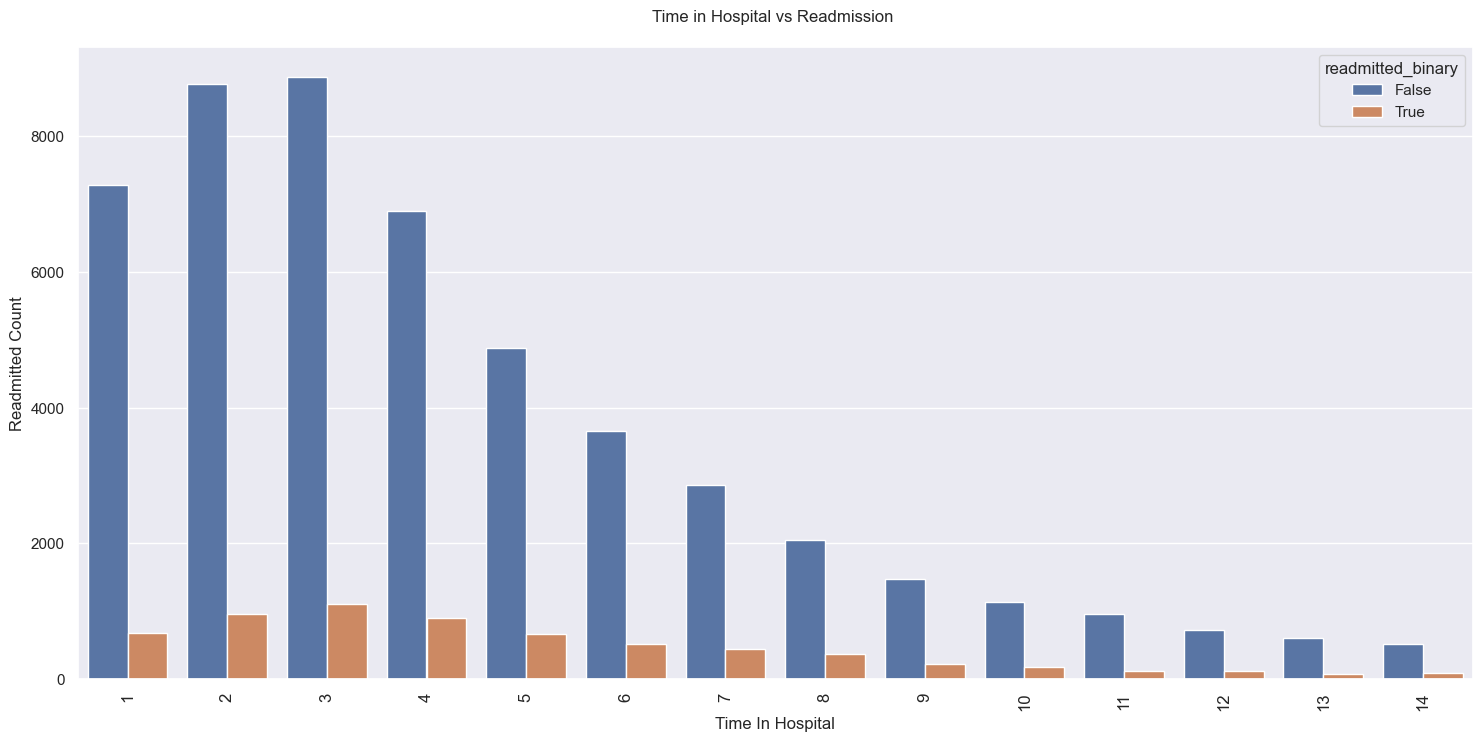

In [1487]:
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='length_of_stay_in_hospital',  hue= 'readmitted_binary',  data= X_train_combined)
plt.xlabel('Time In Hospital', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Readmitted Count', size = 12)
plt.title('Time in Hospital vs Readmission \n', size = 12)
plt.show()

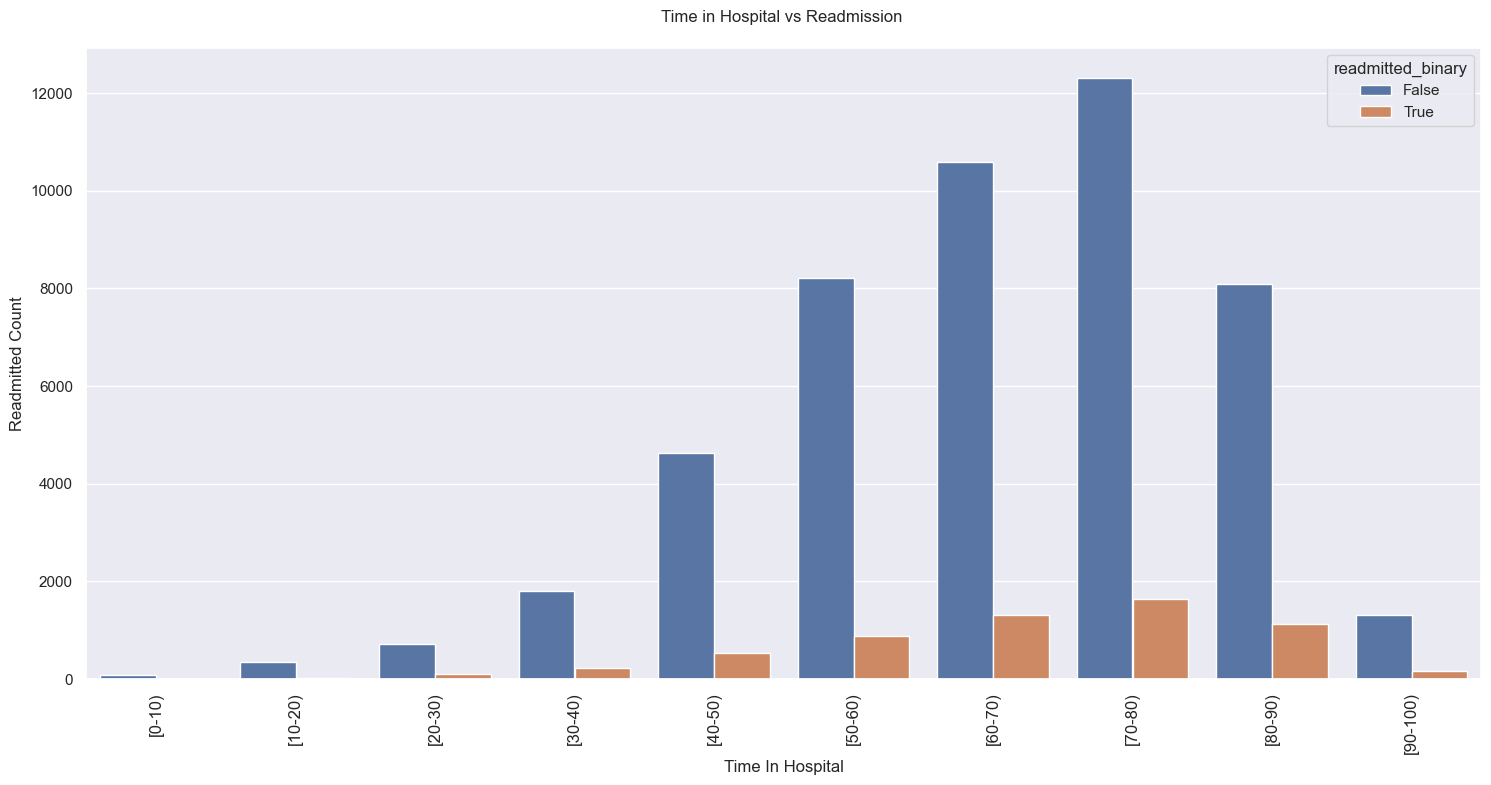

In [1488]:
X_train_combined = pd.concat([X_train_binary, y_train_binary], axis=1)

sns.set(rc={'figure.figsize':(18,8.2)})
custom_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']

ax = sns.countplot(x='age',  hue= 'readmitted_binary',  data= X_train_combined, order=custom_order)
plt.xlabel('Time In Hospital', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Readmitted Count', size = 12)
plt.title('Time in Hospital vs Readmission \n', size = 12)
plt.show()

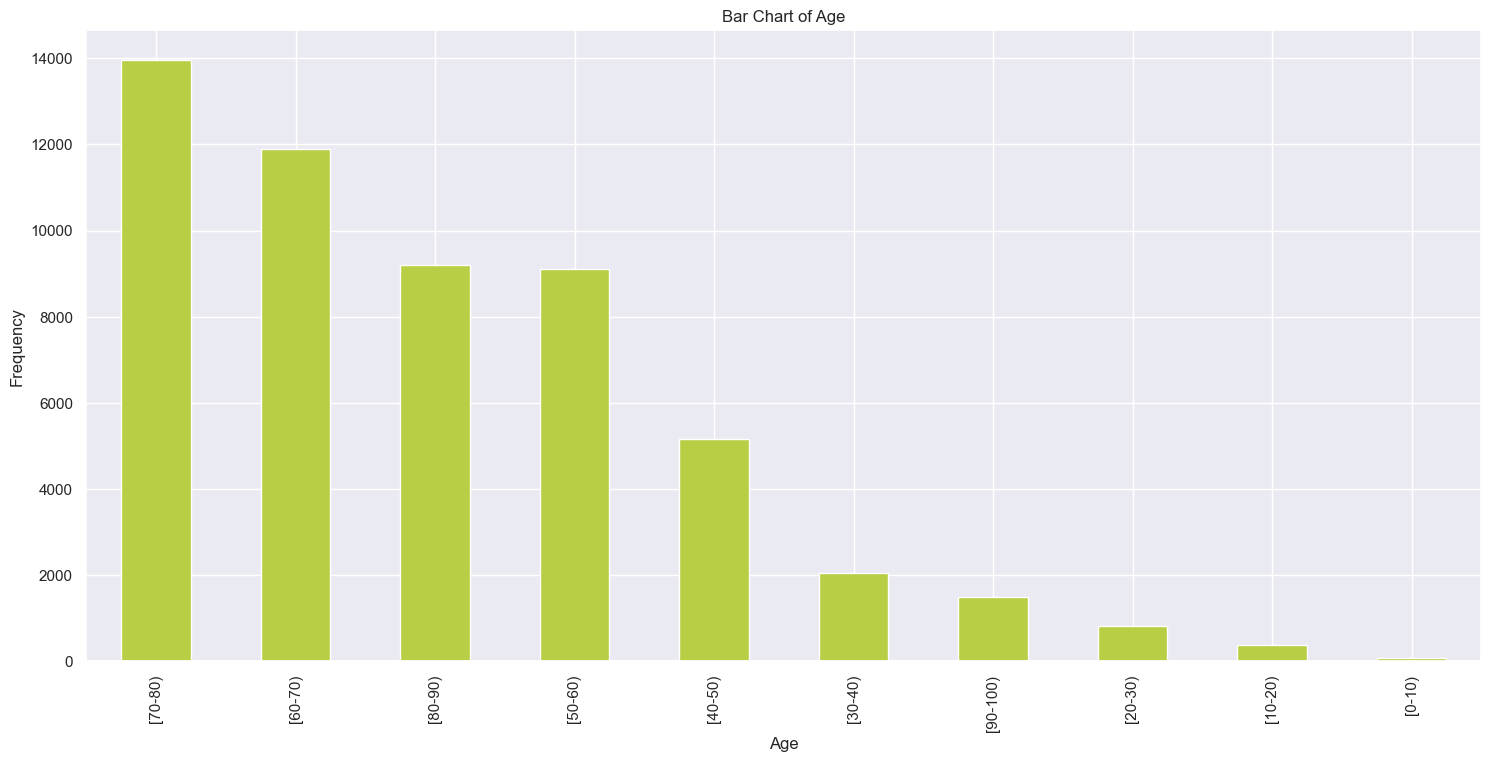

In [1489]:
frequency = X_train_binary['age'].value_counts()

# Plotting the bar chart
frequency.plot(kind='bar',  color='#B7CE45')

# Adding labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Bar Chart of Age')

# Display the plot
plt.show()

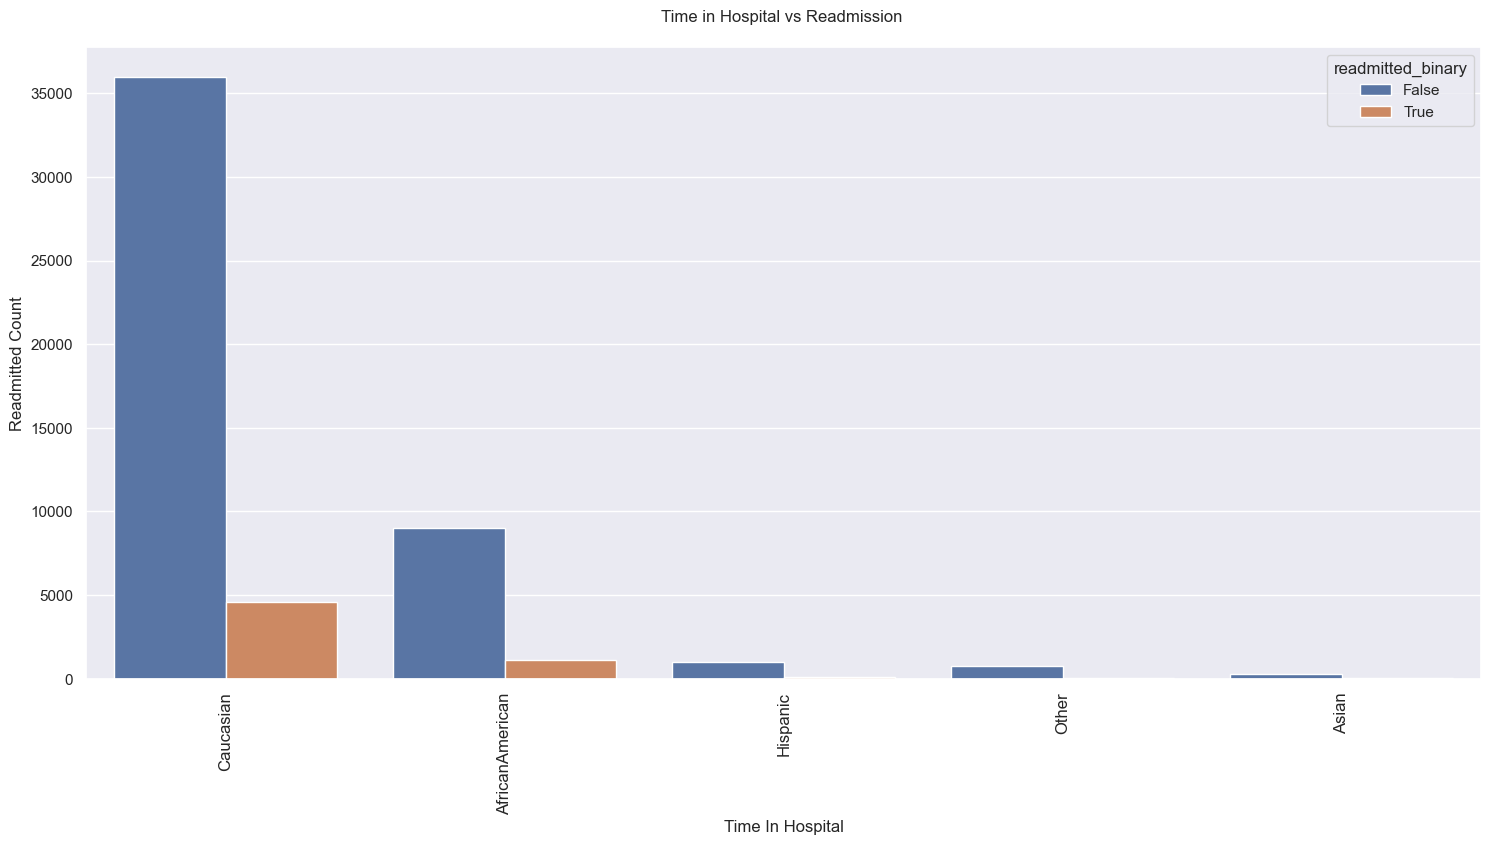

In [1490]:
X_train_combined = pd.concat([X_train_binary, y_train_binary], axis=1)

sns.set(rc={'figure.figsize':(18,8.2)})

ax = sns.countplot(x='race',  hue= 'readmitted_binary',  data= X_train_combined)
plt.xlabel('Time In Hospital', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Readmitted Count', size = 12)
plt.title('Time in Hospital vs Readmission \n', size = 12)
plt.show()

In [1491]:
X_train_combined_1 = X_train_combined.copy()
X_train_combined_1.drop('patient_id', inplace=True, axis=1)

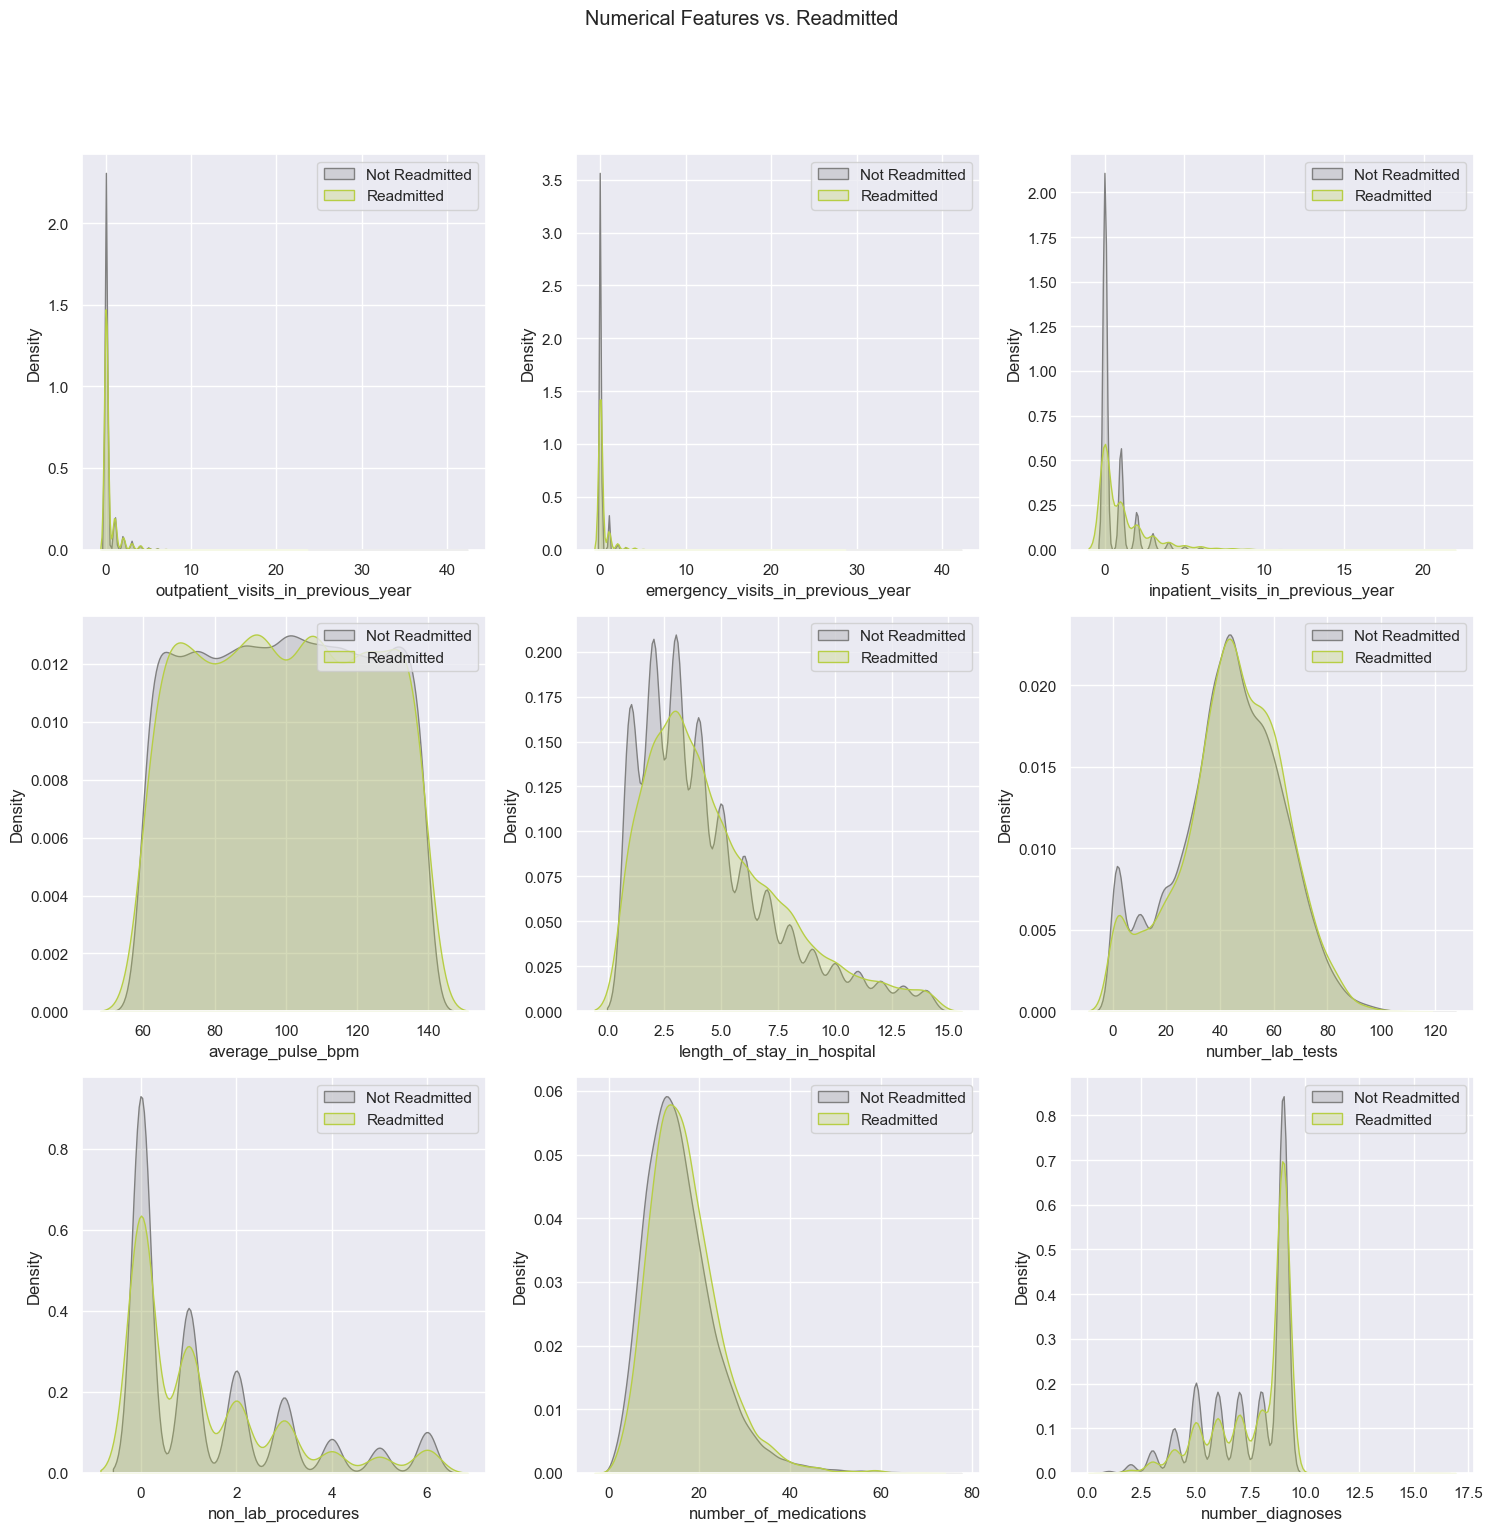

In [1492]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train_combined_1 is your DataFrame with numerical features and 'readmitted_binary' column

# Get numerical features
numerical_features = X_train_combined_1.select_dtypes(include='number')

# Get the target variable
target_variable = 'readmitted_binary'

# Set the number of columns and rows for subplots
num_cols = 3  # Adjust this based on how many subplots you want in each row
num_rows = (len(numerical_features.columns) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle(f'Numerical Features vs. Readmitted', y=1.02)

# Loop through numerical features and create KDE plots
for i, feature in enumerate(numerical_features.columns):
    row = i // num_cols
    col = i % num_cols
    
    # Plot KDE for each class
    sns.kdeplot(X_train_combined_1.loc[X_train_combined_1[target_variable] == 0, feature], color='grey', fill=True, ax=axes[row, col], label='Not Readmitted')
    sns.kdeplot(X_train_combined_1.loc[X_train_combined_1[target_variable] == 1, feature], color='#B7CE45', fill=True, ax=axes[row, col], label='Readmitted')
    
    axes[row, col].set(xlabel=feature, ylabel='Density')
    axes[row, col].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [1493]:
y_train_binary.value_counts()

readmitted_binary
False                50628
True                  6360
Name: count, dtype: int64

In [1494]:
y_val_binary.value_counts()

readmitted_binary
False                12658
True                  1590
Name: count, dtype: int64

In [1495]:
intial_nr_records = X_train_binary.shape[0]

In [1496]:
#X_train_binary.describe(include="all").T

In [1497]:
X_train_binary.nunique()

country                                      1
patient_id                               45008
race                                         5
gender                                       3
age                                         10
weight                                       9
payer_code                                  16
outpatient_visits_in_previous_year          35
emergency_visits_in_previous_year           27
inpatient_visits_in_previous_year           20
admission_type                               7
medical_specialty                           67
average_pulse_bpm                           80
discharge_disposition                       25
admission_source                            15
length_of_stay_in_hospital                  14
number_lab_tests                           112
non_lab_procedures                           7
number_of_medications                       72
primary_diagnosis                          661
secondary_diagnosis                        674
additional_di

In [1498]:
# count of missing values
X_train_binary.isna().sum()

country                                      0
patient_id                                   0
race                                      4006
gender                                       0
age                                       2811
weight                                   55206
payer_code                               22604
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            2982
medical_specialty                        27881
average_pulse_bpm                            0
discharge_disposition                     2063
admission_source                          3816
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                           13
secondary_diagnosis                        213
additional_di

In [1499]:
#X_train_binary.describe(include="all").T

# country
once column country only has only 1 value and it's completely fulfilled, it does not contribute to the analysis, so drop it


In [1500]:
X_train_binary.country.unique()

array(['USA'], dtype=object)

In [1501]:
X_train_binary = X_train_binary.drop(columns=['country'])
X_val_binary = X_val_binary.drop(columns=['country'])
test = test.drop(columns=['country'])

# gender


In [1502]:
X_train_binary['gender'].value_counts() 

gender
Female             30549
Male               26436
Unknown/Invalid        3
Name: count, dtype: int64

# race

-> Fill the missing value of race if there is another record of the same person with the 'race' filled <br>
-> Otherwise, replace by 'Unknown'

In [1503]:
#X_train_binary['race'].value_counts()

In [1504]:
def fill_missing_race_values(df):
    # Identify rows with missing 'race' values
    missing_race_rows = df[df['race'].isna()]

    # Filter rows of patients who visited more than once and have at least one non-missing 'race' value
    potential_fill_rows = df[df['patient_id'].isin(missing_race_rows['patient_id']) & df['race'].notna()]

    # Find the number of missing 'race' values that can potentially be filled
    fillable_values = potential_fill_rows['patient_id'].nunique()

    # Calculate the percentage of fillable missing 'race' values
    percentage_fillable = (fillable_values / len(missing_race_rows)) * 100

    print(f"Number of fillable values: {fillable_values}, Percentage fillable: {round(percentage_fillable)}%")

    # Create a dictionary for mapping patient_id to race
    race_dict = dict(zip(potential_fill_rows['patient_id'], potential_fill_rows['race']))

    # Fill missing 'race' values based on the dictionary
    df['race'] = df.apply(
        lambda row: race_dict[row['patient_id']] if pd.isna(row['race']) and row['patient_id'] in race_dict else row['race'],
        axis=1
    )

    return df

X_train_binary=fill_missing_race_values(X_train_binary)
X_val_binary=fill_missing_race_values(X_val_binary)
test=fill_missing_race_values(test)

X_train_binary['race'].fillna('Unknown', inplace=True)
X_val_binary['race'].fillna('Unknown', inplace=True)
test['race'].fillna('Unknown', inplace=True)

Number of fillable values: 983, Percentage fillable: 25%
Number of fillable values: 99, Percentage fillable: 9%
Number of fillable values: 353, Percentage fillable: 16%


# primary_diagnosis and secondary_diagnosis

the primary and secondary diagnosis are really important to predict the most suitable label, because
it represents what really took the patient to the hospital, so it's really important to keep the real values
and replace the missing ones by the mode

once the missing values for the two attributes are very small, there's no problem on replacing them

In [1505]:
#X_train_binary['primary_diagnosis'].value_counts()

In [1506]:
# # The number of 'primary_diagnosis' missing values is relatively small and doesn't significantly impact the size 
# # of the dataset, we can consider fill the missing values by the column mode.

# mode_train_primary = X_train_binary['primary_diagnosis'].mode()[0]
# X_train_binary['primary_diagnosis'].fillna(mode_train_primary, inplace = True)
# X_val_binary['primary_diagnosis'].fillna(mode_train_primary, inplace = True)
# test['primary_diagnosis'].fillna(mode_train_primary, inplace = True)


In [1507]:
X_train_binary = X_train_binary.dropna(subset=['primary_diagnosis'])
mode_train_primary = X_train_binary['primary_diagnosis'].mode()[0]

X_val_binary['primary_diagnosis'].fillna(mode_train_primary, inplace = True)
test['primary_diagnosis'].fillna(mode_train_primary, inplace = True)

## secondary_diagnosis 

In [1508]:
# mode_train_secondary = X_train_binary['secondary_diagnosis'].mode()[0]
# X_train_binary['secondary_diagnosis'].fillna(mode_train_secondary, inplace = True)
# X_val_binary['secondary_diagnosis'].fillna(mode_train_secondary, inplace = True)
# test['secondary_diagnosis'].fillna(mode_train_secondary, inplace = True)

In [1509]:
X_train_binary = X_train_binary.dropna(subset=['secondary_diagnosis'])
mode_train_secondary = X_train_binary['secondary_diagnosis'].mode()[0]

X_val_binary['secondary_diagnosis'].fillna(mode_train_secondary, inplace = True)
test['secondary_diagnosis'].fillna(mode_train_secondary, inplace = True)

# additional_diagnosis
Nao sei se dar encode em primary e secondary diretamente é bom
por causa de agrupar em sistemas (circulatorio, respiratorio, etc mais para a frente (portanto criei df_copy())

In [1510]:
## Percentage of each value before applying Random Forst algorithm 

additional_diagnosis_counts = X_train_binary['additional_diagnosis'].value_counts(normalize=True) * 100

# Create a DataFrame from the value counts
additional_diagnosis_percentage = additional_diagnosis_counts.reset_index()
additional_diagnosis_percentage.columns = ['Additional Diagnosis', 'Percentage']
#additional_diagnosis_percentage.head(10)

In [1511]:
# X_train_binary = X_train_binary.dropna(subset=['additional_diagnosis'])
# mode_train_additional = X_train_binary['additional_diagnosis'].mode()[0]

# X_val_binary['additional_diagnosis'].fillna(mode_train_additional, inplace = True)
# test['additional_diagnosis'].fillna(mode_train_additional, inplace = True)

In [1512]:
#Random Forest is a good choice for tabular data like the one you described. If your data has complex 
# relationships or non-linearity, Random Forest can capture those patterns.

# Since 'primary_diagnosis' and 'secondary_diagnosis' seem to be categorical variables, label encoding 
# would be a suitable approach

def impute_additional_diagnosis(df):

    X_train_binary_copy = X_train_binary.copy()
    df__2 = df.copy()
    # Create a label encoder
    label_encoder = LabelEncoder()

    # Apply label encoding to 'primary_diagnosis' and 'secondary_diagnosis'
    df__2['primary_diagnosis'] = label_encoder.fit_transform(df__2['primary_diagnosis'])
    df__2['secondary_diagnosis'] = label_encoder.fit_transform(df__2['secondary_diagnosis']) 

    X_train_binary_copy['primary_diagnosis'] = label_encoder.fit_transform(X_train_binary_copy['primary_diagnosis'])
    X_train_binary_copy['secondary_diagnosis'] = label_encoder.fit_transform(X_train_binary_copy['secondary_diagnosis']) 

    # Separate the dataset into parts with and without missing 'additional_diagnosis'
    df_with_missing = df__2[df__2['additional_diagnosis'].isna()]
    df_without_missing = df__2[~df__2['additional_diagnosis'].isna()]

    df_with_missing_X_train = X_train_binary_copy[X_train_binary_copy['additional_diagnosis'].isna()]
    df_without_missing_X_train = X_train_binary_copy[~X_train_binary_copy['additional_diagnosis'].isna()]

    # Train the model just for X_train_binary
    
    # Define the features and target for the classification model
    X = df_without_missing_X_train[['primary_diagnosis', 'secondary_diagnosis']]
    y = (df_without_missing_X_train['additional_diagnosis'].notna()).astype(int)

    clf = RandomForestClassifier()
    clf.fit(X, y)


    # Use the trained model to predict if 'additional_diagnosis' is present for the part with missing values
    X_predict = df_with_missing[['primary_diagnosis', 'secondary_diagnosis']]
    y_predict = clf.predict(X_predict)
    y_predict_original = label_encoder.inverse_transform(y_predict)

    # Update the missing 'additional_diagnosis' values based on predictions
    df.loc[df['additional_diagnosis'].isna(), 'additional_diagnosis'] = y_predict_original
    
    return df

# Now, the missing 'additional_diagnosis' values have been imputed based on the classification model's predictions.
X_val_binary = impute_additional_diagnosis(X_val_binary)
test = impute_additional_diagnosis(test)
X_train_binary = impute_additional_diagnosis(X_train_binary)


# Now, the missing 'additional_diagnosis' values have been imputed based on the classification model's predictions.

In [1513]:
# # Random Forest is a good choice for tabular data like the one you described. If your data has complex 
# # relationships or non-linearity, Random Forest can capture those patterns.

# # Since 'primary_diagnosis' and 'secondary_diagnosis' seem to be categorical variables, label encoding 
# # would be a suitable approach

# from sklearn.metrics import accuracy_score


# def impute_additional_diagnosis(df):
#     global clf_X_train_binary  # Declare clf_X_train_binary as a global variable

#     df__2 = df.copy()
#     # Create a label encoder
#     label_encoder = LabelEncoder()

#     # Apply label encoding to 'primary_diagnosis' and 'secondary_diagnosis'
#     df__2['primary_diagnosis'] = label_encoder.fit_transform(df['primary_diagnosis'])
#     df__2['secondary_diagnosis'] = label_encoder.fit_transform(df['secondary_diagnosis']) 

#     # Separate the dataset into parts with and without missing 'additional_diagnosis'
#     df_with_missing = df__2[df__2['additional_diagnosis'].isna()]
#     df_without_missing = df__2[~df__2['additional_diagnosis'].isna()]

#     # Train the model just for X_train_binary
#     if df is X_train_binary:
#         # Define the features and target for the classification model
#         X = df_without_missing[['primary_diagnosis', 'secondary_diagnosis']]
#         y = (df_without_missing['additional_diagnosis'].notna()).astype(int)

#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#         clf = RandomForestClassifier()
#         clf.fit(X_train, y_train)
#         test_pred = clf.predict(X_test)
#         accuracy = accuracy_score(y_test, test_pred)
#         print('Accuracy:' ,accuracy)
#         clf_X_train_binary = clf

#     # Use the trained model to predict if 'additional_diagnosis' is present for the part with missing values
#     X_predict = df_with_missing[['primary_diagnosis', 'secondary_diagnosis']]
#     y_predict = clf_X_train_binary.predict(X_predict)
#     y_predict_original = label_encoder.inverse_transform(y_predict)

#     # Update the missing 'additional_diagnosis' values based on predictions
#     df.loc[df['additional_diagnosis'].isna(), 'additional_diagnosis'] = y_predict_original
    
#     return df

# # Now, the missing 'additional_diagnosis' values have been imputed based on the classification model's predictions.
# X_train_binary = impute_additional_diagnosis(X_train_binary)
# X_val_binary = impute_additional_diagnosis(X_val_binary)
# test = impute_additional_diagnosis(test)

# # Now, the missing 'additional_diagnosis' values have been imputed based on the classification model's predictions.

In [1514]:
# ## Percentage of each value after applying Random Forst algorithm 

# additional_diagnosis_counts = X_train_binary['additional_diagnosis'].value_counts(normalize=True) * 100

# # Create a DataFrame from the value counts
# additional_diagnosis_percentage = additional_diagnosis_counts.reset_index()
# additional_diagnosis_percentage.columns = ['Additional Diagnosis', 'Percentage']
# #additional_diagnosis_percentage.head(10)

In [1515]:
print(X_train_binary['additional_diagnosis'].isna().sum())
print(X_train_binary['primary_diagnosis'].isna().sum())
print(X_train_binary['secondary_diagnosis'].isna().sum())
print(X_val_binary['additional_diagnosis'].isna().sum())
print(X_val_binary['primary_diagnosis'].isna().sum())
print(X_val_binary['secondary_diagnosis'].isna().sum())
print(test['additional_diagnosis'].isna().sum())
print(test['primary_diagnosis'].isna().sum())
print(test['secondary_diagnosis'].isna().sum())

0
0
0
0
0
0
0
0
0


# weight  (drop - explanation)

-> weight would be an important measure between the first and second visits, in order to check if there is any weight difference

-> selected_df' was created to assess the importance of the 'weight' attribute in capturing patient historical data during the first visit (when they are on their second hospital visit)

-> with 10,509 missing 'weight' values out of 10,566 records (approximately 99.5%) in 'selected_df,' it suggests that 'weight' may not be reliable for these visits.

-> the substantial number of missing values suggests that the 'weight' data may not be consistently recorded, or it may not be significantly informative for these visits. Imputing missing values could introduce noise and potentially mislead the analysis.

-> By doing so, we mitigate the impact of missing data and ensure the integrity of the analysis aligns with the dataset's primary research objectives.


In [1516]:
# .create a X_train_binary with the patients that went to the hospital 2 times or more, but only with the first 2 visits

patient_counts = X_train_binary['patient_id'].value_counts()
patients_with_at_least_two_encounters = patient_counts[patient_counts >= 2].index

# Filter the DataFrame to include only patients with at least two encounters
selected_df = X_train_binary[X_train_binary['patient_id'].isin(patients_with_at_least_two_encounters)]

# Sort the selected DataFrame by 'patient_id' and 'encounter_id' in ascending order
selected_df = selected_df.sort_values(by=['patient_id', 'encounter_id'])

# Keep only the first two encounters for each patient
selected_df = selected_df.groupby('patient_id').head(2).reset_index(drop=True)
#selected_df

In [1517]:
# comparing the number of Nan values of 'weight' with the nr of records

print('Nr of weight missing values in selected_df:', selected_df['weight'].isna().sum())
print('Nr of records in selected_df:', selected_df.shape[0])
print('% of weight missing values in selected_df:', round((selected_df['weight'].isna().sum() / selected_df.shape[0]) * 100, 1), '%')

Nr of weight missing values in selected_df: 15325
Nr of records in selected_df: 15530
% of weight missing values in selected_df: 98.7 %


In [1518]:
# nr of people from selected_df that have their weights registered from the first or second visits
count = (selected_df.groupby('patient_id')['weight'].apply(lambda x: x.isna().sum()) == 0).sum()
count

97

In [1519]:
# get the people from selected_df with both weights

# Group by 'patient_id' and aggregate the weight values as a list for each patient
weight_lists = selected_df.groupby('patient_id')['weight'].apply(list)

#drop patient_id that doesnt have the weight recorded from the first or second visits
weight_lists = weight_lists[weight_lists.apply(lambda x: all(pd.notna(x)))]

#print(weight_lists)
# Filter for patients with different weight values between their first and second visits
patients_with_weight_difference = weight_lists[weight_lists.apply(lambda x: len(set(x)) > 1)]

# Create a DataFrame with only the records of patients with weight differences
result_df = selected_df[selected_df['patient_id'].isin(patients_with_weight_difference.index)]
nr_patients_different_weights = result_df.shape[0] / 2 # divide by 2 because there is the same patient twice
print(round(nr_patients_different_weights/X_train_binary.shape[0] * 100, 3), '% represents the % of people from the whole dataset that had a weight difference between the first and second visits\n')
print(round(nr_patients_different_weights/count * 100), '% of people whose weights were recorded in the first and second visits had a weight difference')

0.055 % represents the % of people from the whole dataset that had a weight difference between the first and second visits

32 % of people whose weights were recorded in the first and second visits had a weight difference


Drop weight: Dropped the 'weight' column because it had a very high percentage of missing values, approximately 98%. With such a large number of missing values, imputing or filling them could lead to misleading or inaccurate results. Additionally, since 'weight' might not be a critical feature for your analysis or predictions, removing the column was a reasonable choice to reduce complexity and potential issues caused by the missing data.

In [1520]:
X_train_binary = X_train_binary.drop(columns=['weight'])
X_val_binary = X_val_binary.drop(columns=['weight'])
test = test.drop(columns=['weight'])

In [1521]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

#result_df

In [1522]:
# all the patients that were readmitted (shows the first and second visits)
#a = result_df[result_df['readmitted_binary'] == True]['patient_id']
#filtered_result_df = result_df[result_df['patient_id'].isin(a)]
#filtered_result_df

# age
-> Fill the missing value of race if there is another record of the same person with the 'race' filled <br>
-> Otherwise, replace by 'Unknown'

In [1523]:
#X_train_binary['age'].value_counts()

In [1524]:
def fill_missing_age(df):
    # Identify rows with missing 'age' values
    missing_age_rows = df[df['age'].isna()]

    # Filter rows of patients who visited more than once and have at least one non-missing 'age' value
    potential_fill_rows = df[df['patient_id'].isin(missing_age_rows['patient_id']) & df['age'].notna()]
    
    # Find the number of missing 'age' values that can potentially be filled
    fillable_values = potential_fill_rows['patient_id'].nunique()

    # Calculate the percentage of fillable missing 'age' values
    percentage_fillable = (fillable_values / len(missing_age_rows)) * 100

    print(f"Number of fillable missing 'age' values: {fillable_values}")
    print(f"Percentage of fillable missing 'age' values: {percentage_fillable:.2f}%")

    # Create a dictionary to map patient_id to age for efficient lookup
    age_dict = dict(zip(potential_fill_rows['patient_id'], potential_fill_rows['age']))

    # Fill missing 'age' values using the created dictionary
    df['age'] = df.apply(
        lambda row: age_dict[row['patient_id']] if pd.isna(row['age']) and row['patient_id'] in age_dict else row['age'],
        axis=1
    )

    return df

X_train_binary = fill_missing_age(X_train_binary)
X_val_binary = fill_missing_age(X_val_binary)
test = fill_missing_age(test)

X_train_binary['age'].fillna(X_train_binary['age'].mode()[0], inplace=True)
X_val_binary['age'].fillna(X_train_binary['age'].mode()[0], inplace=True)
test['age'].fillna(X_train_binary['age'].mode()[0], inplace=True)


Number of fillable missing 'age' values: 929
Percentage of fillable missing 'age' values: 33.12%
Number of fillable missing 'age' values: 87
Percentage of fillable missing 'age' values: 11.66%
Number of fillable missing 'age' values: 328
Percentage of fillable missing 'age' values: 21.42%


In [1525]:
X_train_binary['age'].isna().sum()

0

# admission_source

In [1526]:
X_train_binary['admission_source'].value_counts()

admission_source
 Emergency Room                                               32094
 Physician Referral                                           16487
Transfer from a hospital                                       1805
 Transfer from another health care facility                    1196
Clinic Referral                                                 615
 Transfer from a Skilled Nursing Facility (SNF)                 465
HMO Referral                                                    105
 Not Mapped                                                      85
 Not Available                                                   78
 Court/Law Enforcement                                            9
 Transfer from hospital inpt/same fac reslt in a sep claim        6
 Transfer from critial access hospital                            6
 Transfer from Ambulatory Surgery Center                          2
Normal Delivery                                                   1
 Extramural Birth              

In [1527]:
# once 'Emergency Room' is the most common admission source, we replace the missing values by that 

mode_admission_source = X_train_binary['admission_source'].mode()[0]
X_train_binary['admission_source'].fillna(mode_admission_source, inplace=True)
X_val_binary['admission_source'].fillna(mode_admission_source, inplace=True)
test['admission_source'].fillna(mode_admission_source, inplace=True)

# admission_type

In [1528]:
X_train_binary['admission_type'].value_counts()

admission_type
Emergency        29963
Elective         10523
Urgent           10455
Not Available     2671
Not Mapped         165
Trauma Center       10
Newborn              6
Name: count, dtype: int64

In [1529]:
# ."admission_type" attribute may still have some relevance, although it might not be as directly related 
# to the target variable ("readmitted_binary") as some other attributes.
mode_admission_type = X_train_binary['admission_type'].mode()[0]
X_train_binary['admission_type'].fillna(mode_admission_type, inplace=True)
X_val_binary['admission_type'].fillna(mode_admission_type, inplace=True)
test['admission_type'].fillna(mode_admission_type, inplace=True)

# payer_code
-> Fill with 'No' the Nan values

In [1530]:
X_train_binary['payer_code'].fillna('No', inplace=True)
X_val_binary['payer_code'].fillna('No', inplace=True)
test['payer_code'].fillna('No', inplace=True)

# medical_speacialty

In [1531]:
#X_train_binary['medical_specialty'].value_counts()

In [1532]:
mode_specialty = X_train_binary['medical_specialty'].mode()[0]
mode_specialty

'InternalMedicine'

In [1533]:
# impute the missing values with the most frequent category (mode) since this 
# strategy is often used for categorical data

X_train_binary['medical_specialty'].fillna(mode_specialty, inplace=True)
X_val_binary['medical_specialty'].fillna(mode_specialty, inplace=True)
test['medical_specialty'].fillna(mode_specialty, inplace=True)

# discharge_disposition
Readmission Risk: Some discharge dispositions, such as discharging to a rehabilitation facility or skilled nursing home, may be associated with a higher risk of readmission. Understanding these patterns can help in predicting and preventing readmissions within 30 days.

In [1534]:
#X_train_binary['discharge_disposition'].value_counts()

In [1535]:
mode_discharge = X_train_binary['discharge_disposition'].mode()[0]
X_train_binary['discharge_disposition'].fillna(mode_discharge, inplace=True)
X_val_binary['discharge_disposition'].fillna(mode_discharge, inplace=True)
test['discharge_disposition'].fillna(mode_discharge, inplace=True)

# glucose_test_result
use "none" to indicate the test was not taken, replacing nan (mas não ha nenhum valor com nan originalmente, asumir que vazio/nan é none??)

-> 67548 missing values out of 71236 (94.8%)

-> glucose tests are critically important for individuals with diabetes. These tests play a significant role in managing diabetes and ensuring the overall health and well-being of people with the condition.

-> Glycemic Control: Glucose tests help assess how well a person with diabetes is managing their blood sugar levels. Monitoring blood sugar levels is essential for maintaining glycemic control within a target range, which is critical in preventing complications associated with diabetes.

In [1536]:
X_train_binary['glucose_test_result'].value_counts()

glucose_test_result
Norm    1445
>200     850
>300     667
Name: count, dtype: int64

In [1537]:
X_train_binary['glucose_test_result'].fillna('None', inplace=True)
X_val_binary['glucose_test_result'].fillna('None', inplace=True)
test['glucose_test_result'].fillna('None', inplace=True)

# a1c_test_result
information about your average levels of blood glucose, also called blood sugar, over the past 3 months. 
se calhar nao foi feito o teste qaundo o valor é nan pois nao existem none, tal como acontece em glucose_test_result

Why should a person get the A1C test?

Testing can help health care professionals

    -> find prediabetes and counsel you about lifestyle changes to help you delay or prevent type 2 diabetes
    -> find type 2 diabetes
    -> work with you to monitor the disease and help make treatment decisions to prevent complications


In [1538]:
X_train_binary['a1c_test_result'].value_counts()

a1c_test_result
>8      4485
Norm    2819
>7      2149
Name: count, dtype: int64

In [1539]:
X_train_binary['a1c_test_result'].fillna('None', inplace=True)
X_val_binary['a1c_test_result'].fillna('None', inplace=True)
test['a1c_test_result'].fillna('None', inplace=True)

In [1540]:
X_train_binary.isna().any()

patient_id                               False
race                                     False
gender                                   False
age                                      False
payer_code                               False
outpatient_visits_in_previous_year       False
emergency_visits_in_previous_year        False
inpatient_visits_in_previous_year        False
admission_type                           False
medical_specialty                        False
average_pulse_bpm                        False
discharge_disposition                    False
admission_source                         False
length_of_stay_in_hospital               False
number_lab_tests                         False
non_lab_procedures                       False
number_of_medications                    False
primary_diagnosis                        False
secondary_diagnosis                      False
additional_diagnosis                     False
number_diagnoses                         False
glucose_test_

In [1541]:
X_train_binary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56763 entries, 812424 to 935338
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   patient_id                             56763 non-null  int64 
 1   race                                   56763 non-null  object
 2   gender                                 56763 non-null  object
 3   age                                    56763 non-null  object
 4   payer_code                             56763 non-null  object
 5   outpatient_visits_in_previous_year     56763 non-null  int64 
 6   emergency_visits_in_previous_year      56763 non-null  int64 
 7   inpatient_visits_in_previous_year      56763 non-null  int64 
 8   admission_type                         56763 non-null  object
 9   medical_specialty                      56763 non-null  object
 10  average_pulse_bpm                      56763 non-null  int64 
 11  discharge_disp

no missing values
# ---------------------------------------------------------

# Explore numerical data

In [1542]:
metric_features = ['outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']
#non_metric_features = X_train_binary.columns.drop(metric_features).to_list()
non_metric_features = X_train_binary.columns.drop(metric_features + ['patient_id']).to_list()

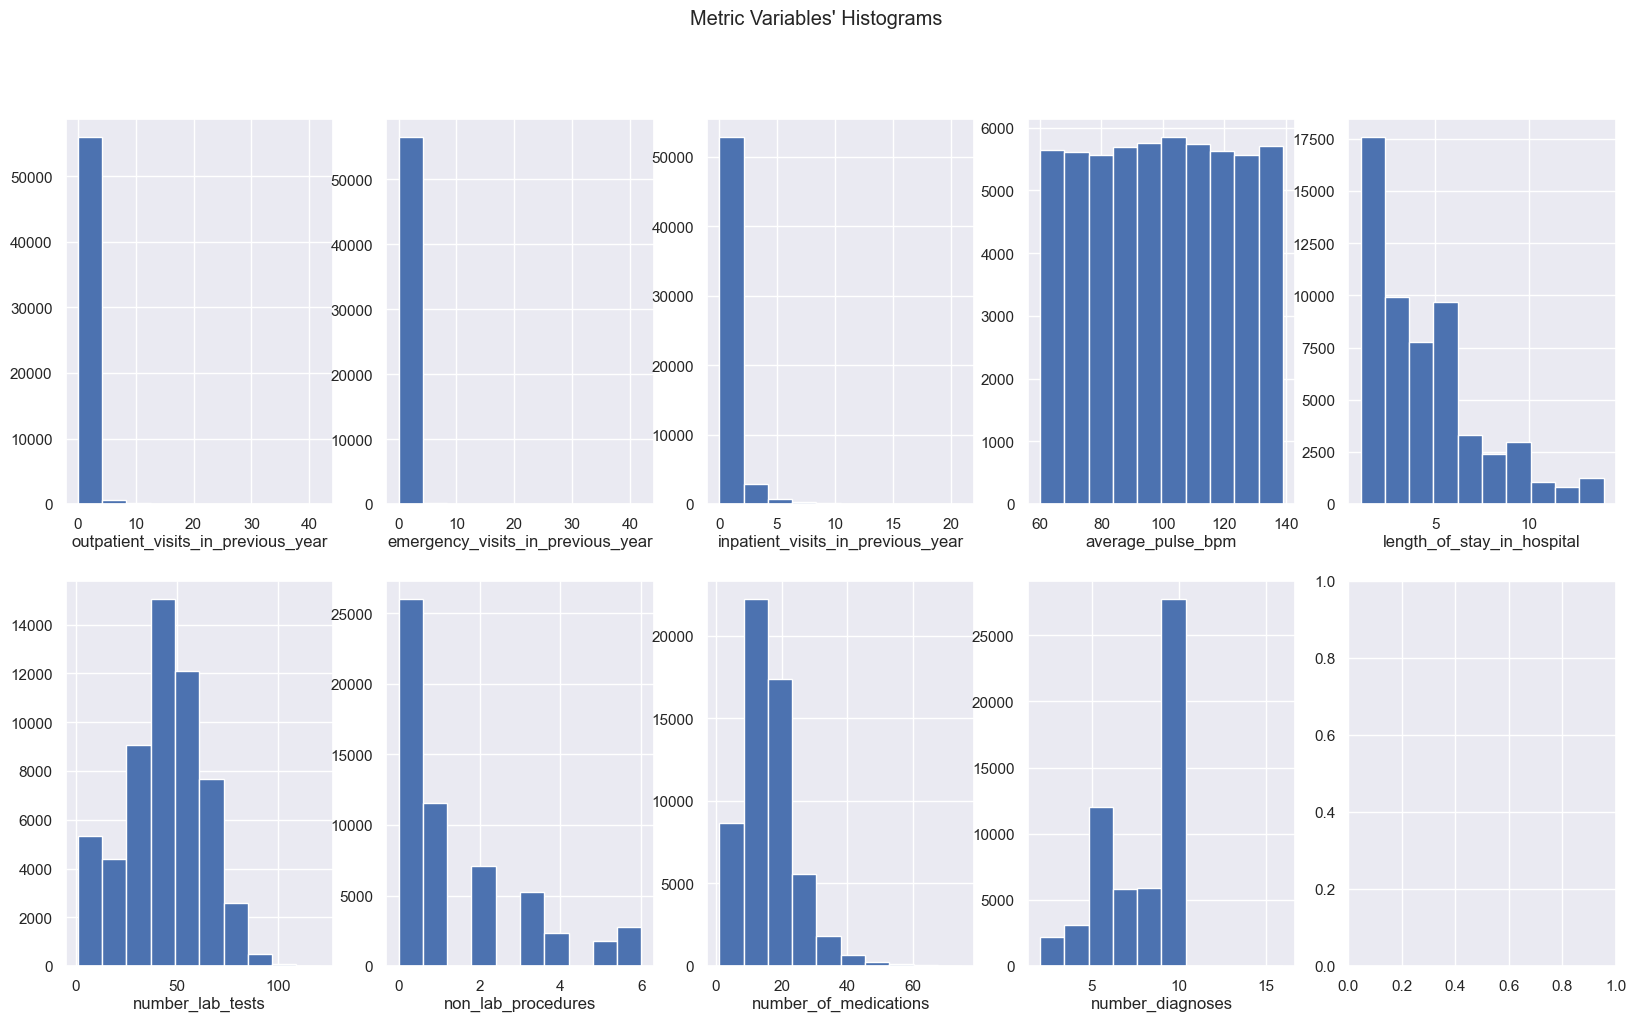

In [1543]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(X_train_binary[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Histograms"

plt.suptitle(title)

if not os.path.exists(os.path.join('..', 'figures', 'exp_analysis')):
    # if the exp_analysis directory is not present then create it first
    os.makedirs(os.path.join('..', 'figures', 'exp_analysis'))
    
plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'numeric_variables_histograms.png'), dpi=200)

plt.show()

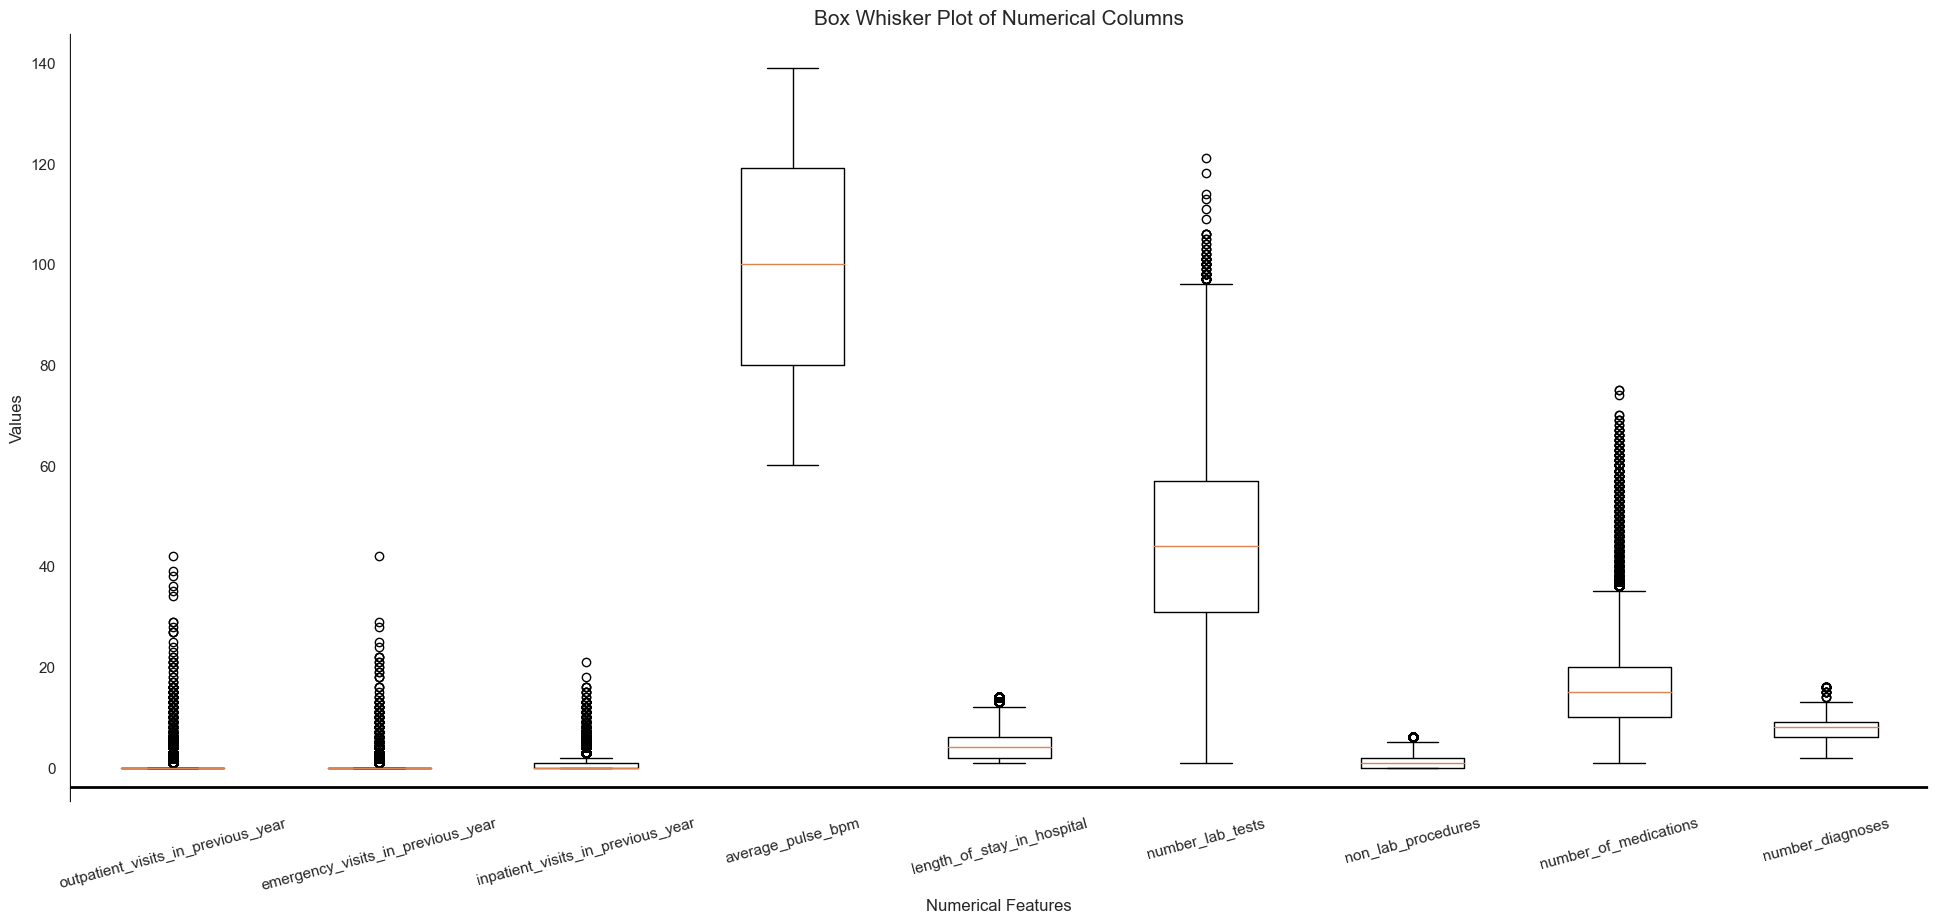

In [1544]:
num_feat = X_train_binary[[col for col in X_train_binary.columns if any(feature in col for feature in metric_features)]]

plt.figure(figsize=(24, 10))
plt.boxplot(num_feat.values)
plt.title("Box Whisker Plot of Numerical Columns", fontsize=15)
plt.xticks(range(1, len(num_feat.columns) + 1), num_feat.columns, rotation=15)
plt.gca().set_facecolor('white')
plt.xlabel("Numerical Features", fontsize=12)
plt.ylabel("Values", fontsize=12)
# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6) 

# Add lines on y-axis and x-axis
plt.axhline(y=-3.8, color='black', linestyle='-', linewidth=2)
plt.axvline(x=0.5, color='black', linestyle='-', linewidth=2) 

plt.show()


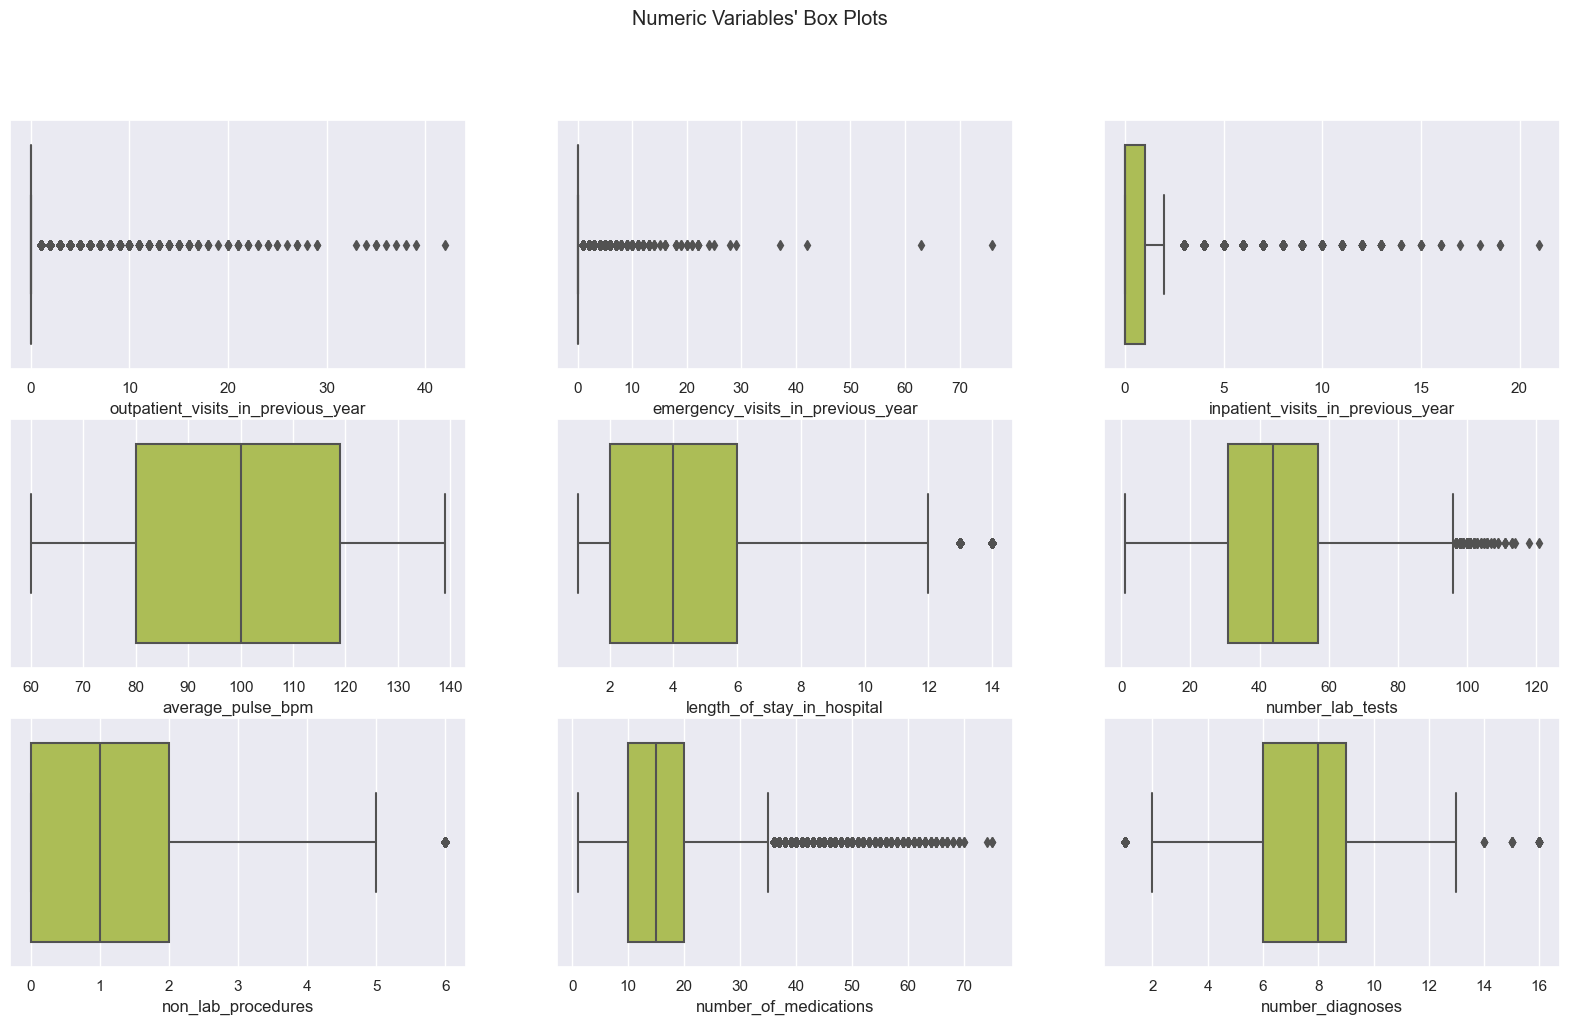

In [1545]:
from math import ceil
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, 3, figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), num_feat): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax, color='#B7CE45')
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

In [1546]:
X_train_binary['emergency_visits_in_previous_year'].max()

42

In [1547]:
#numeric=X_train_binary.select_dtypes(exclude=['object', 'bool'])
#categorial = X_train_binary.select_dtypes(include=["object", 'bool'])
print('\n',"=================== Outliers =======================") 
for k, v in num_feat.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
        print(" %s outliers = %.2f%%" % (k, perc))

#Let's check skewness & kurtosis        
print('\n',"===================Skewness & Kurtosis =======================")       

for col in num_feat:    
    print (col, "Skew is:", num_feat[col].skew(), "Kurtosis is:", num_feat[col].kurtosis())


 =================== Outliers =======================
 outpatient_visits_in_previous_year outliers = 79.68%
 emergency_visits_in_previous_year outliers = 79.68%
 inpatient_visits_in_previous_year outliers = 5.60%
 average_pulse_bpm outliers = 0.00%
 length_of_stay_in_hospital outliers = 2.93%
 number_lab_tests outliers = 0.13%
 non_lab_procedures outliers = 6.36%
 number_of_medications outliers = 2.36%
 number_diagnoses outliers = 0.05%

 ===================Skewness & Kurtosis =======================
outpatient_visits_in_previous_year Skew is: 8.879693148646258 Kurtosis is: 150.2840926672638
emergency_visits_in_previous_year Skew is: 12.534905462496706 Kurtosis is: 306.7997690930145
inpatient_visits_in_previous_year Skew is: 3.519096585057589 Kurtosis is: 19.454783243508764
average_pulse_bpm Skew is: -0.0029919927561404577 Kurtosis is: -1.1886845621726974
length_of_stay_in_hospital Skew is: 1.1367363123054999 Kurtosis is: 0.8437954947538815
number_lab_tests Skew is: -0.235964665163182

In [1548]:
def outliers_log(df):
    df['outpatient_visits_in_previous_year'] = np.log1p(df['outpatient_visits_in_previous_year'])
    df['emergency_visits_in_previous_year']  = np.log1p(df['emergency_visits_in_previous_year'])
    df['inpatient_visits_in_previous_year']  = np.log1p(df['inpatient_visits_in_previous_year'])
    df['number_of_medications']  = np.log1p(df['number_of_medications'])

outliers_log(X_train_binary)
outliers_log(X_val_binary)
outliers_log(test)

In [1549]:
X_train_binary = X_train_binary[X_train_binary['number_diagnoses'] < 14]
X_train_binary = X_train_binary[X_train_binary['number_lab_tests'] < 95]
X_train_binary = X_train_binary[X_train_binary['length_of_stay_in_hospital'] < 13]

def outliers(df):
    
    mode = X_train_binary['number_diagnoses'].mode()[0]
    condition = df['number_diagnoses'] >= 14
    df.loc[condition, 'number_diagnoses'] = mode

    mode = X_train_binary['number_lab_tests'].mode()[0]
    condition = df['number_lab_tests'] >= 95
    df.loc[condition, 'number_lab_tests'] = mode

    mode = X_train_binary['length_of_stay_in_hospital'].mode()[0]
    condition = df['length_of_stay_in_hospital'] >= 95
    df.loc[condition, 'length_of_stay_in_hospital'] = mode

outliers(X_val_binary)
outliers(test)


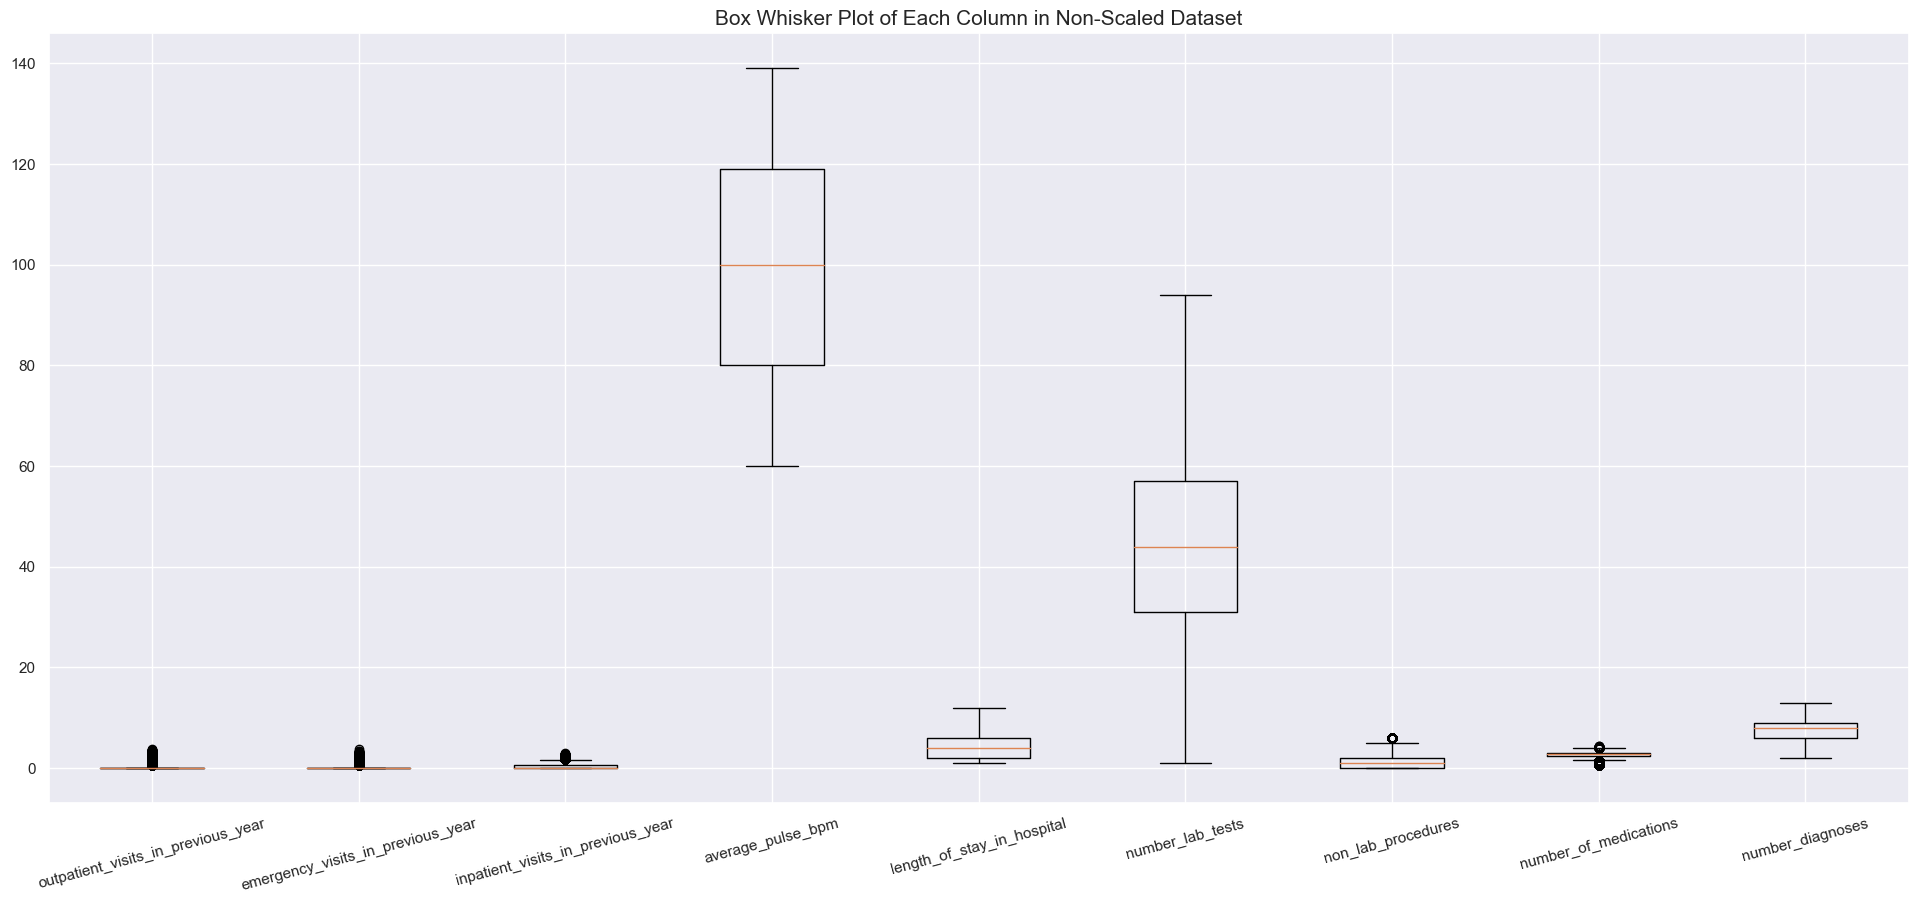

In [1550]:
num_feat = X_train_binary[[col for col in X_train_binary.columns if any(feature in col for feature in metric_features)]]
plt.figure(figsize=(24, 10))
plt.boxplot(num_feat.values)
plt.title("Box Whisker Plot of Each Column in Non-Scaled Dataset", fontsize=15)
plt.xticks(range(1, len(num_feat.columns) + 1), num_feat.columns, rotation=15)
plt.show()

In [1551]:
#sns.set()

# Setting pairplot
#sns.pairplot(X_train_binary[metric_features], diag_kind="hist")

# Layout
#plt.subplots_adjust(top=0.95)
#plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

#if not os.path.exists(os.path.join('..', 'figures', 'exp_analysis')):
    # if the exp_analysis directory is not present then create it first
    #os.makedirs(os.path.join('..', 'figures', 'exp_analysis'))
    
#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'pairwise_relationship_of_numerical_variables.png'), dpi=200)
#plt.show()

In [1552]:
df_1 = X_train_binary.copy()

## outpatient_visits_in_previous_year

In [1553]:
#df_1['outpatient_visits_in_previous_year'].value_counts()

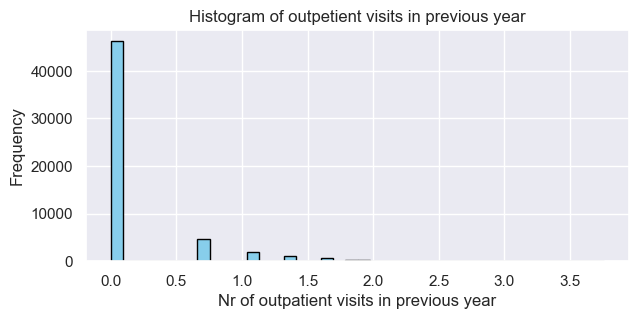

In [1554]:
plt.figure(figsize=(7, 3))

plt.hist(df_1['outpatient_visits_in_previous_year'], bins=40, color='skyblue', edgecolor='black')

plt.xlabel('Nr of outpatient visits in previous year')
plt.ylabel('Frequency')
plt.title('Histogram of outpetient visits in previous year')

plt.show()

In [1555]:
#df_1['outpatient_visits_in_previous_year'].value_counts()

In [1556]:
# # Removing outliers from train
# df_1 = df_1[df_1['outpatient_visits_in_previous_year']<=10]

# mode = df_1['outpatient_visits_in_previous_year'].mode()[0]

# # Repalce outliers by the mode
# condition = X_val_binary['outpatient_visits_in_previous_year'] > 10
# X_val_binary.loc[condition, 'outpatient_visits_in_previous_year'] = mode

# condition = test['outpatient_visits_in_previous_year'] > 10
# test.loc[condition, 'outpatient_visits_in_previous_year'] = mode

In [1557]:
#X_train_combined = pd.concat([df_1, y_train_binary], axis=1)

#X_train_combined.groupby(['outpatient_visits_in_previous_year', 'readmitted_binary'])['readmitted_binary'].count()

In [1558]:
# # Assuming df_1 is your DataFrame and 'outpatient_visits_in_previous_year' is the columnimport numpy as np

# df_1['outpatient_visits_in_previous_year'] = np.where(df_1['outpatient_visits_in_previous_year'] > 0, True, False)
# X_val_binary['outpatient_visits_in_previous_year'] = np.where(X_val_binary['outpatient_visits_in_previous_year'] > 0, True, False)
# test['outpatient_visits_in_previous_year'] = np.where(test['outpatient_visits_in_previous_year'] > 0, True, False)

In [1559]:
# metric_features.remove('outpatient_visits_in_previous_year')
# non_metric_features.append('outpatient_visits_in_previous_year')

## inpatient_visits_in_previous_year

In [1560]:
df_1['inpatient_visits_in_previous_year'].value_counts()


inpatient_visits_in_previous_year
0.000000    36799
0.693147    10590
1.098612     4127
1.386294     1854
1.609438      906
1.791759      412
1.945910      287
2.079442      145
2.197225       82
2.302585       63
2.397895       32
2.484907       25
2.564949       19
2.639057       13
2.772589        3
2.833213        3
2.708050        2
3.091042        1
Name: count, dtype: int64

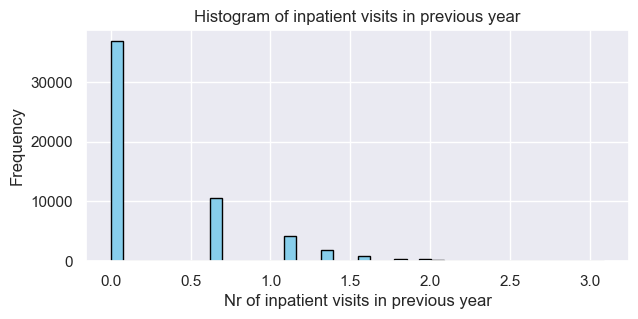

In [1561]:
plt.figure(figsize=(7, 3))

plt.hist(df_1['inpatient_visits_in_previous_year'], bins=40, color='skyblue', edgecolor='black')

plt.xlabel('Nr of inpatient visits in previous year')
plt.ylabel('Frequency')
plt.title('Histogram of inpatient visits in previous year')

plt.show()

In [1562]:
# # Remove outliers from train
# #df_1 = df_1[df_1['inpatient_visits_in_previous_year']<=15]

# condition = df_1['inpatient_visits_in_previous_year'] > 16
# df_1.loc[condition, 'inpatient_visits_in_previous_year'] = 16

# #mode = df_1['inpatient_visits_in_previous_year'].mode()[0]

# # Repalce outliers by the mode
# condition = X_val_binary['inpatient_visits_in_previous_year'] > 16
# X_val_binary.loc[condition, 'inpatient_visits_in_previous_year'] = 16

# condition = test['inpatient_visits_in_previous_year'] > 16
# test.loc[condition, 'inpatient_visits_in_previous_year'] = 16

## emergency_visits_in_previous_year

In [1563]:
df_1['emergency_visits_in_previous_year'].max()

3.7612001156935624

In [1564]:
df_1['emergency_visits_in_previous_year'].value_counts()

emergency_visits_in_previous_year
0.000000    49081
0.693147     4247
1.098612     1141
1.386294      406
1.609438      203
1.791759       96
1.945910       51
2.079442       34
2.397895       18
2.197225       17
2.484907       16
2.302585       15
2.564949        8
2.639057        7
2.708050        3
2.833213        3
2.944439        3
3.135494        3
3.091042        2
3.044522        2
2.995732        2
3.218876        1
3.258097        1
3.761200        1
3.401197        1
3.367296        1
Name: count, dtype: int64

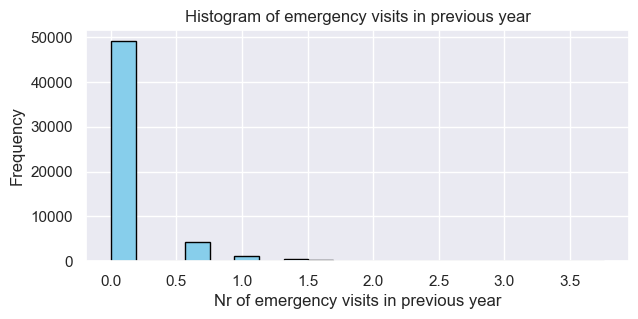

In [1565]:
plt.figure(figsize=(7, 3))

plt.hist(df_1['emergency_visits_in_previous_year'], bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Nr of emergency visits in previous year')
plt.ylabel('Frequency')
plt.title('Histogram of emergency visits in previous year')

plt.show()

In [1566]:
# # Remove outliers from train
# #df_1 = df_1[df_1['emergency_visits_in_previous_year'] <= 10]

# condition = df_1['emergency_visits_in_previous_year'] > 6
# #mode = df_1['emergency_visits_in_previous_year'].mode()[0]
# df_1.loc[condition, 'emergency_visits_in_previous_year'] = 6


# # Repalce outliers by the mode
# condition = X_val_binary['emergency_visits_in_previous_year'] > 6
# X_val_binary.loc[condition, 'emergency_visits_in_previous_year'] = 6

# condition = test['emergency_visits_in_previous_year'] > 6
# test.loc[condition, 'emergency_visits_in_previous_year'] = 6

## average_pulse_bpm

In [1567]:
df_1.groupby('age')['average_pulse_bpm'].agg(['min','max'])

,min,max
age,,
[0-10),62,137
[10-20),61,139
[20-30),60,139
[30-40),60,139
[40-50),60,139
[50-60),60,139
[60-70),60,139
[70-80),60,139
[80-90),60,139


In [1568]:
df_1[['age', 'average_pulse_bpm']].groupby('age').mean()

,average_pulse_bpm
age,
[0-10),99.967213
[10-20),99.347962
[20-30),98.865099
[30-40),99.532448
[40-50),99.426874
[50-60),99.173323
[60-70),99.265032
[70-80),99.814348
[80-90),99.885931


In [1569]:
#df_1.average_pulse_bpm.unique()

## length_of_stay_in_hospital

In [1570]:
df_1['length_of_stay_in_hospital'].value_counts()

length_of_stay_in_hospital
3     9898
2     9650
1     7912
4     7761
5     5504
6     4146
7     3280
8     2386
9     1661
10    1299
11    1058
12     808
Name: count, dtype: int64

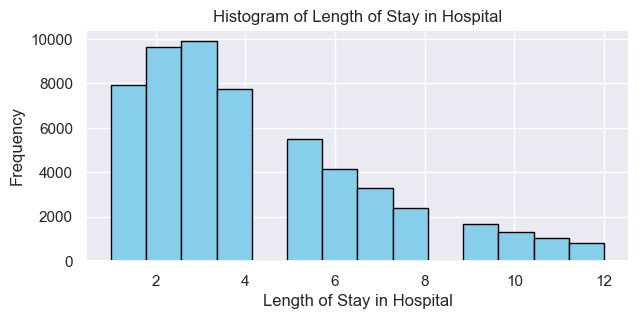

In [1571]:
plt.figure(figsize=(7, 3))

plt.hist(df_1['length_of_stay_in_hospital'], bins=14, color='skyblue', edgecolor='black')

plt.xlabel('Length of Stay in Hospital')
plt.ylabel('Frequency')
plt.title('Histogram of Length of Stay in Hospital')

plt.show()

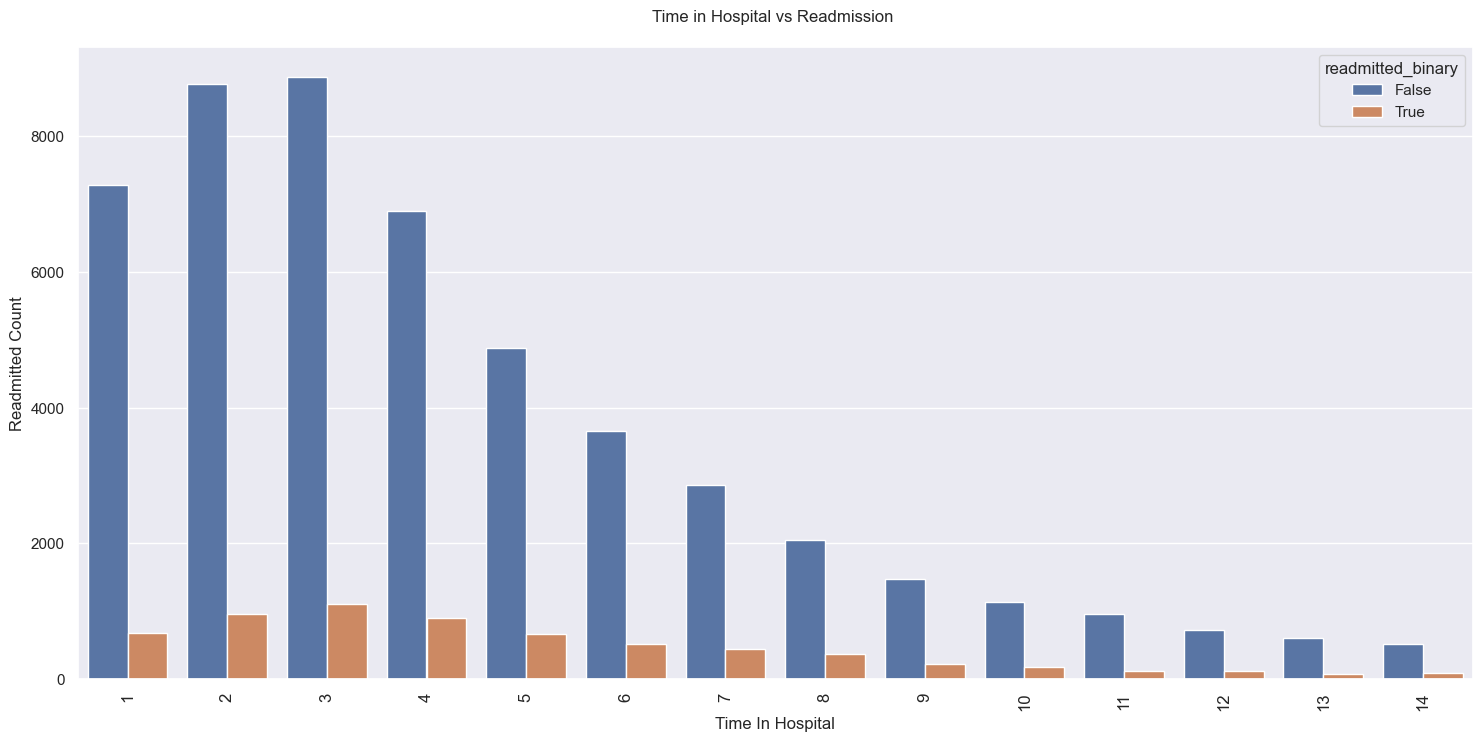

In [1572]:
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='length_of_stay_in_hospital',  hue= 'readmitted_binary',  data= X_train_combined)
plt.xlabel('Time In Hospital', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Readmitted Count', size = 12)
plt.title('Time in Hospital vs Readmission \n', size = 12)
plt.show()

In [1573]:
# # Function to label intervals
# def label_intervals(length_of_stay):
#     if length_of_stay <= 2:
#         return 1 ## Short
#     elif 3 <= length_of_stay <= 7:
#         return 2 ## Moderate
#     else:
#         return 3 ## Prolonged

# # Apply the function to create a new column 'stay_category'
# df_1['length_of_stay_in_hospital'] = df_1['length_of_stay_in_hospital'].apply(label_intervals)
# X_val_binary['length_of_stay_in_hospital'] = X_val_binary['length_of_stay_in_hospital'].apply(label_intervals)
# test['length_of_stay_in_hospital'] = test['length_of_stay_in_hospital'].apply(label_intervals)

# # metric_features.remove('length_of_stay_in_hospital')
# # non_metric_features.append('length_of_stay_in_hospital')

In [1574]:
# Remove outliers from train
#df_1 = df_1[df_1['length_of_stay_in_hospital']<=10]

# Repalce outliers by the mode
#condition = X_val_binary['length_of_stay_in_hospital'] > 10
#X_val_binary.loc[condition, 'length_of_stay_in_hospital'] = X_train_binary['length_of_stay_in_hospital'].mode()[0]

## number_diagnosis

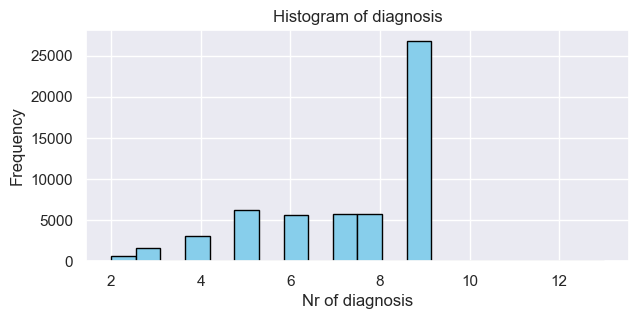

In [1575]:
plt.figure(figsize=(7, 3))

plt.hist(df_1['number_diagnoses'], bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Nr of diagnosis')
plt.ylabel('Frequency')
plt.title('Histogram of diagnosis')

plt.show()

In [1576]:
df_1['number_diagnoses'].value_counts()

number_diagnoses
9     26740
5      6175
8      5785
7      5710
6      5678
4      3082
3      1564
2       591
10       13
13       12
12        7
11        6
Name: count, dtype: int64

## number_lab_tests

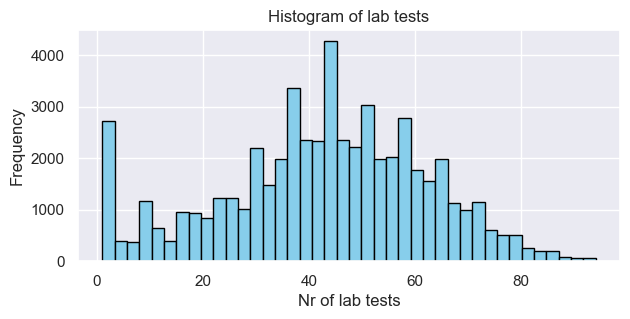

In [1577]:
plt.figure(figsize=(7, 3))

plt.hist(df_1['number_lab_tests'], bins=40, color='skyblue', edgecolor='black')

plt.xlabel('Nr of lab tests')
plt.ylabel('Frequency')
plt.title('Histogram of lab tests')

plt.show()

In [1578]:
#df_1[df_1['number_lab_tests']>70].number_lab_tests.value_counts()

In [1579]:
#df_1[df_1['number_lab_tests']>80].shape[0]

In [1580]:
# '''# Remove outliers from train
# df_1 = df_1[df_1['number_lab_tests'] <= 100]

# mode = df_1['number_lab_tests'].mode()[0]
# # Repalce outliers by the mode
# condition = X_val_binary['number_lab_tests'] > 100
# X_val_binary.loc[condition, 'number_lab_tests'] = mode

# condition = test['number_lab_tests'] > 100
# test.loc[condition, 'number_lab_tests'] = mode

# só para testar se assim temos melhor resultados, acho que faz mais sentido remover outliers
# e só depois calcular a moda, dá-nos uma moda mais realista'''

# # Replace train outliers by the mode
# condition = df_1['number_lab_tests'] > 100

# mode = df_1['number_lab_tests'].mode()[0]
# df_1.loc[condition, 'number_lab_tests'] = mode


# # Repalce val outliers by the mode
# condition = X_val_binary['number_lab_tests'] > 100
# X_val_binary.loc[condition, 'number_lab_tests'] = mode

# condition = test['number_lab_tests'] > 100
# test.loc[condition, 'number_lab_tests'] = mode

## non_lab_procedures

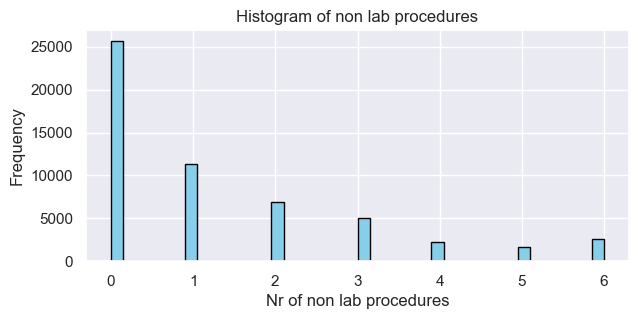

In [1581]:
plt.figure(figsize=(7, 3))

plt.hist(df_1['non_lab_procedures'], bins=40, color='skyblue', edgecolor='black')

plt.xlabel('Nr of non lab procedures')
plt.ylabel('Frequency')
plt.title('Histogram of non lab procedures')

plt.show()

In [1582]:
df_1['non_lab_procedures'].value_counts()

non_lab_procedures
0    25644
1    11324
2     6871
3     5048
6     2604
4     2215
5     1657
Name: count, dtype: int64

## number_of_medications

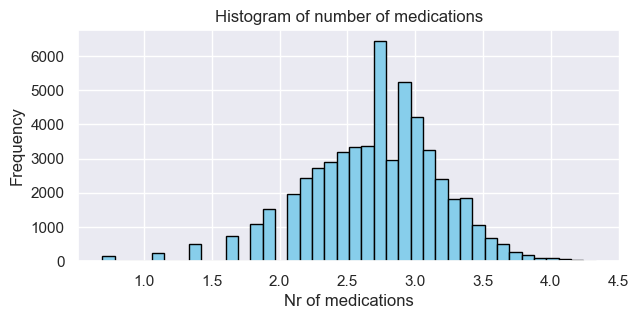

In [1583]:
plt.figure(figsize=(7, 3))

plt.hist(df_1['number_of_medications'], bins=40, color='skyblue', edgecolor='black')

plt.xlabel('Nr of medications')
plt.ylabel('Frequency')
plt.title('Histogram of number of medications')

plt.show()

In [1584]:
df_1[df_1['number_of_medications'] > 40].shape[0]

0

In [1585]:
#df_1[df_1['number_of_medications']>39].number_of_medications.value_counts()

In [1586]:
# '''# Remove outliers from train
# df_1 = df_1[df_1['number_of_medications'] <= 60]

# mode = df_1['number_of_medications'].mode()[0]
# # Repalce outliers by the mode
# condition = X_val_binary['number_of_medications'] > 60
# X_val_binary.loc[condition, 'number_of_medications'] = mode

# condition = test['number_of_medications'] > 60
# test.loc[condition, 'number_of_medications'] = mode

# #só para testar se assim temos melhor resultados, acho que faz mais sentido remover outliers
# #e só depois calcular a moda, dá-nos uma moda mais realista
# '''# Replace train outliers by the mode
# condition = df_1['number_of_medications'] > 40

# mode = df_1['number_of_medications'].mode()[0]
# df_1.loc[condition, 'number_of_medications'] = mode

# # Repalce val outliers by the mode
# condition = X_val_binary['number_of_medications'] > 40
# X_val_binary.loc[condition, 'number_of_medications'] = mode

# condition = test['number_of_medications'] > 40
# test.loc[condition, 'number_of_medications'] = mode

# Explore non-numerical data
## Categorical/Low Cardinality Variables' Absolute Frequencies

In [1587]:
df_2 = df_1.copy()

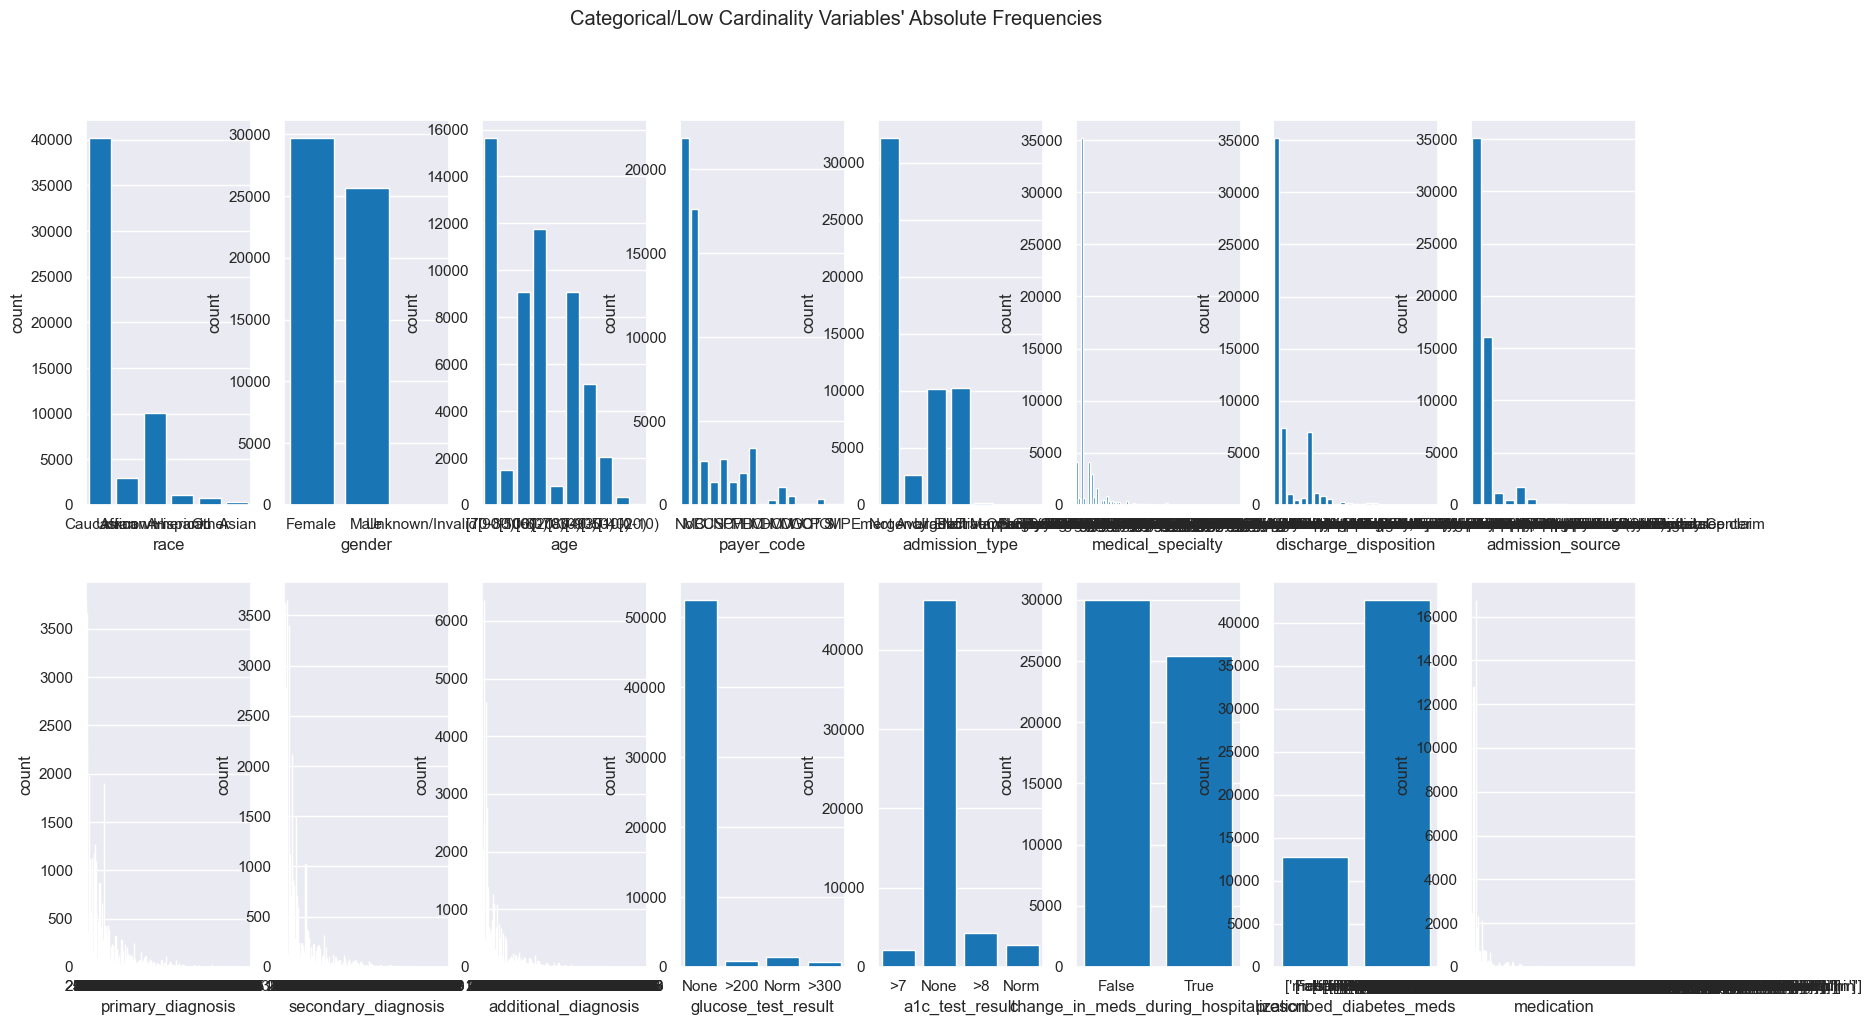

In [1588]:
# bad bar charts, impossible to read -> represent 1 by 1

# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    sns.countplot(x=df_2[feat].astype(object), ax=ax, color='#007acc')

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)

plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'categorical_variables_frequecies.png'), dpi=200)
plt.show()

## race

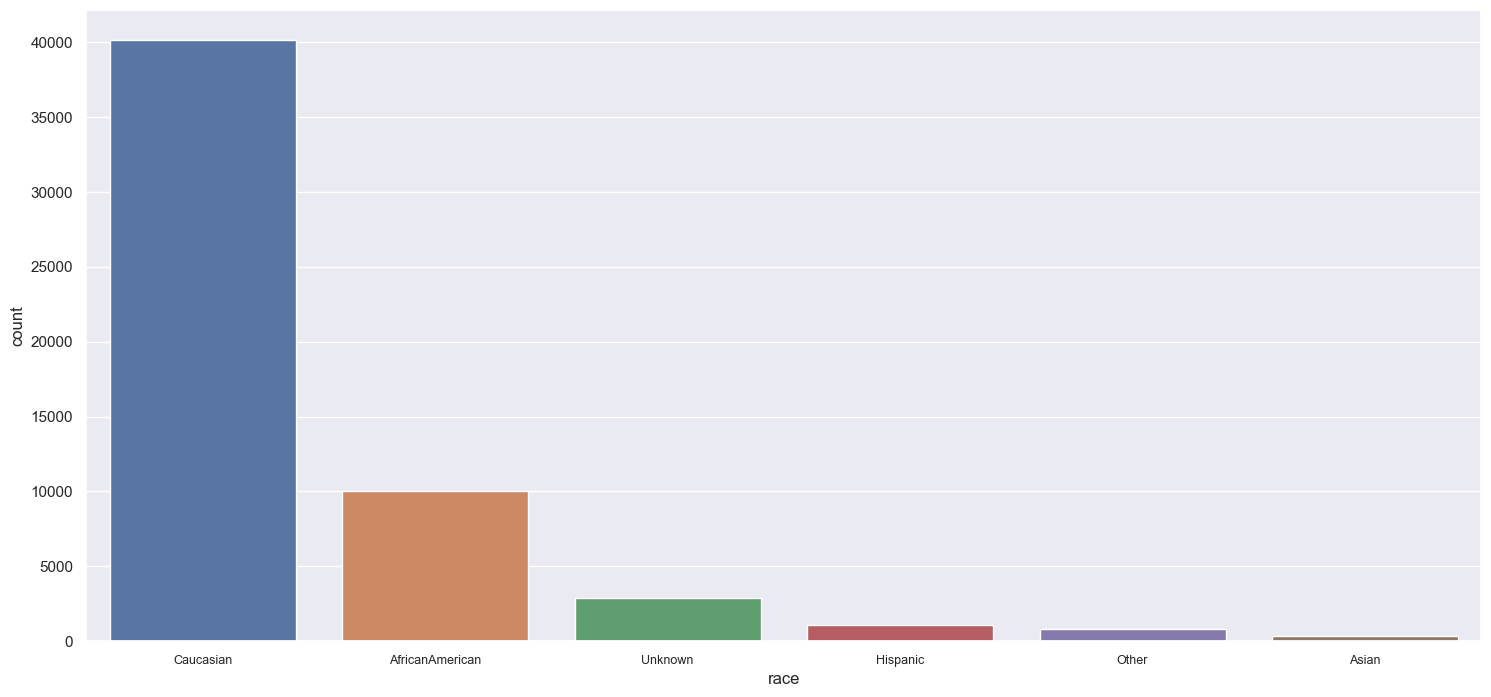

In [1589]:
sns.set() 
sns.set(rc={"xtick.labelsize": 9})  

race_order = df_2["race"].value_counts().index

sns.countplot(x=df_2["race"], order = race_order )
plt.show()

In [1590]:
df_2['race'].value_counts()

race
Caucasian          40153
AfricanAmerican    10055
Unknown             2902
Hispanic            1114
Other                801
Asian                338
Name: count, dtype: int64

In [1591]:
# it might be a good approach to replace the "Unknown" label with "Other", because they are the same

df_2['race'] = df_2['race'].replace('Unknown', 'Other')
X_val_binary['race'] = X_val_binary['race'].replace('Unknown', 'Other')
test['race'] = test['race'].replace('Unknown', 'Other')

## gender
-> Once we replace 'Unknown/Invalid' by the column mode, there is only 'Male' and 'Female' values (2 unique values), so we can replace them by 1 and 0, respectively -> boolean column 'is_male'

In [1592]:
df_2['gender'].value_counts()

gender
Female             29682
Male               25678
Unknown/Invalid        3
Name: count, dtype: int64

In [1593]:
# Once there are only 3 records with 'Unknown/Invalid', we replace them by the mode
mode = df_2['gender'].mode().iloc[0]

df_2['gender'].replace('Unknown/Invalid',mode,inplace=True)
X_val_binary['gender'].replace('Unknown/Invalid',mode,inplace=True)
test['gender'].replace('Unknown/Invalid', mode,inplace=True)

## age
-> To get rid of the age brackets, we replace each age bracket by its middle number

In [1594]:
X_train_combined = pd.concat([df_2, y_train_binary], axis=1)

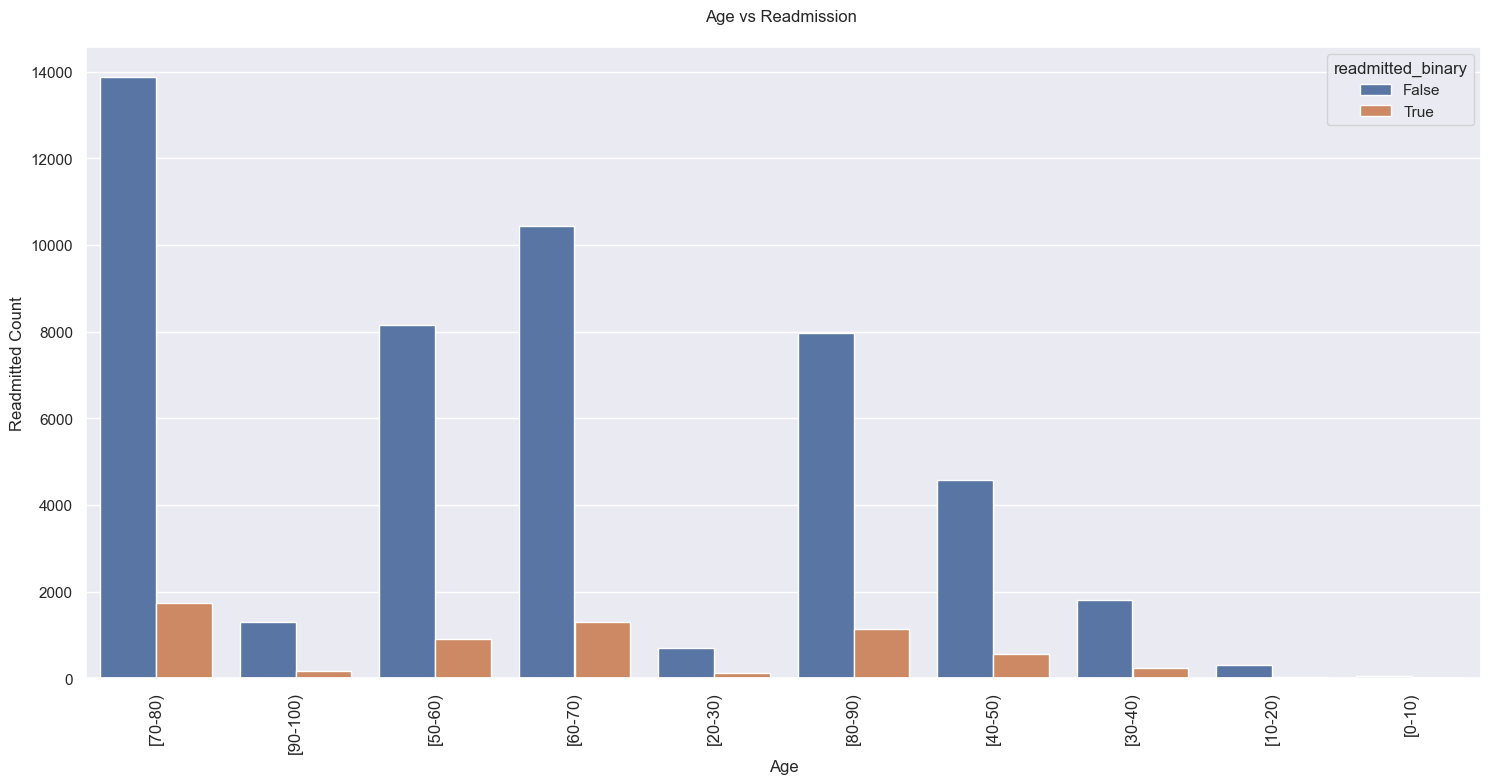

In [1595]:
# Create a countplot with sorted age order
ax = sns.countplot(x='age', hue='readmitted_binary', data=X_train_combined)

# Customize labels and title
plt.xlabel('Age', size=12)
plt.xticks(rotation=90, size=12)
plt.ylabel('Readmitted Count', size=12)
plt.title('Age vs Readmission \n', size=12)

# Show the plot
plt.show()

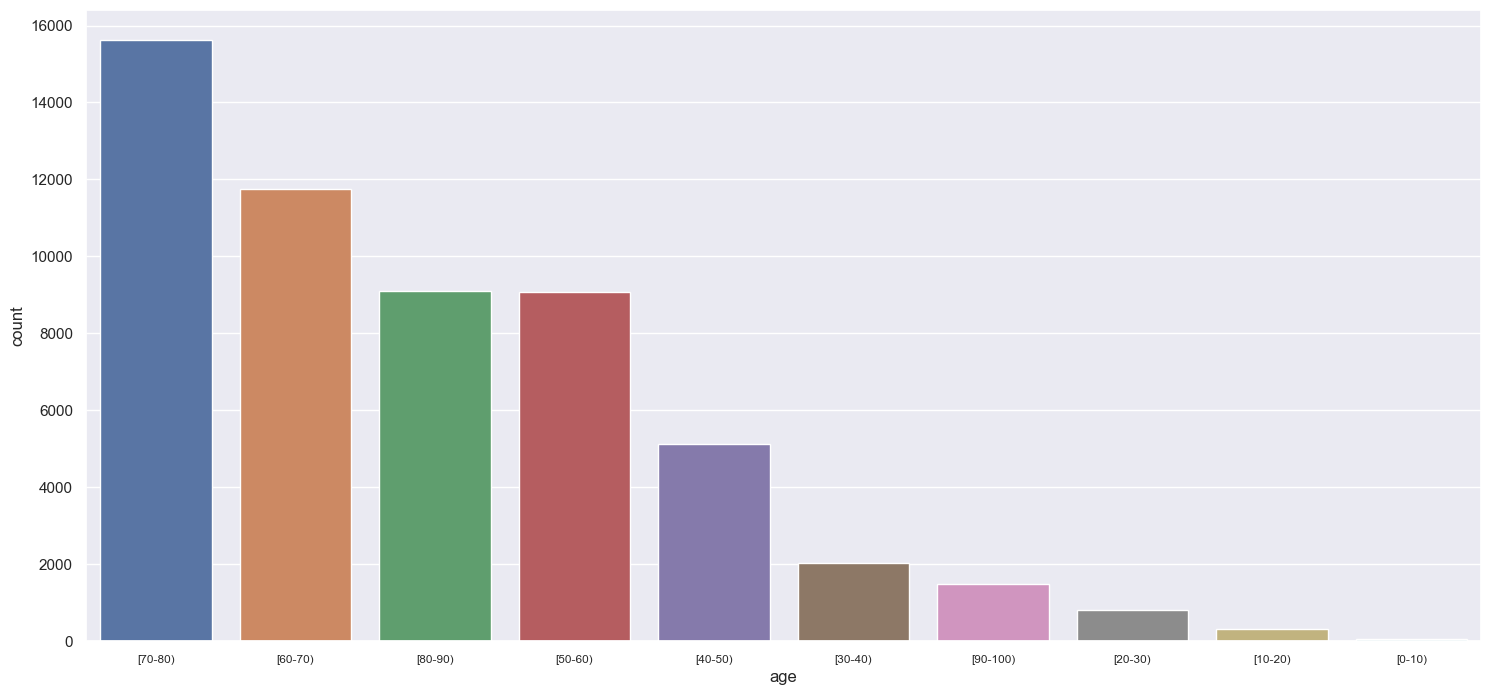

In [1596]:
sns.set() # Reset the formatting defaults
sns.set(rc={"xtick.labelsize": 8.5})
# Sort the "age" column and create an ordered list
age_order = df_2["age"].value_counts().index

sns.countplot(x=df_2["age"], order=age_order)
plt.show()

In [1597]:
df_2['age'].value_counts()

age
[70-80)     15626
[60-70)     11742
[80-90)      9091
[50-60)      9064
[40-50)      5135
[30-40)      2034
[90-100)     1483
[20-30)       808
[10-20)       319
[0-10)         61
Name: count, dtype: int64

In [1598]:
age_mapping = {
    '[0-10)': 5,
    '[10-20)': 15,
    '[20-30)': 25,
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85,
    '[90-100)': 95
}

df_2['age'] = df_2['age'].replace(age_mapping)
X_val_binary['age'] = X_val_binary['age'].replace(age_mapping)
test['age'] = test['age'].replace(age_mapping)

In [1599]:
df_2.age.unique()

array([75, 95, 55, 65, 25, 85, 45, 35, 15,  5])

## admission_type

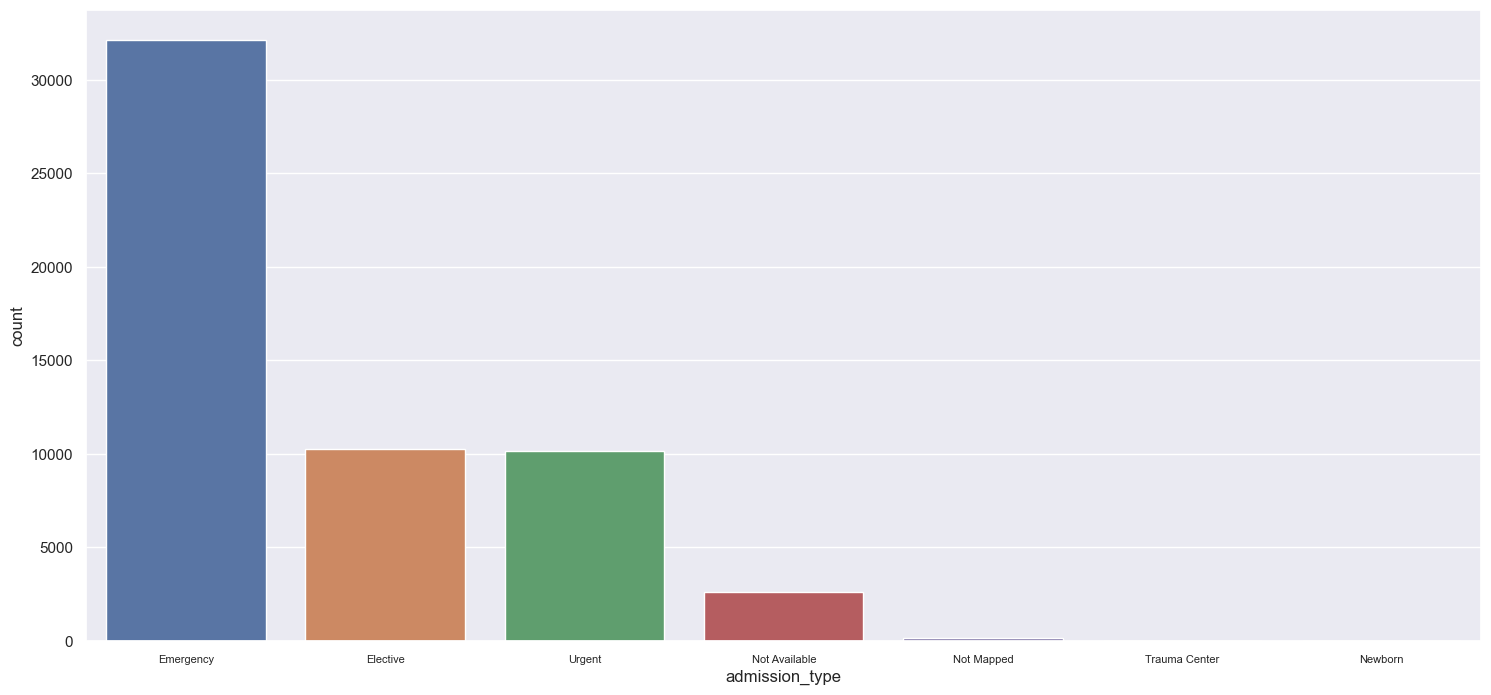

In [1600]:
sns.set() # Reset the formatting defaults
sns.set(rc={"xtick.labelsize": 8})  # Set the x-axis label size to 12

admission_type_order = df_2["admission_type"].value_counts().index

sns.countplot(x=df_2["admission_type"], order = admission_type_order)
plt.show()

In [1601]:
df_2['admission_type'].value_counts()

admission_type
Emergency        32153
Elective         10243
Urgent           10158
Not Available     2631
Not Mapped         162
Trauma Center       10
Newborn              6
Name: count, dtype: int64

In [1602]:
# .taking into account the meaning of 'admission type', it is clear that neither 'newborn' nor 'trauma center' are an admission type 
# so, we replace them by the mode
# .also, 'not mapped' means the same as 'not avaliable, because it gives us no information, so it might be a good approach to replace them by the mode,
# because it is a considerable number

#df_2 = df_2[~df_2['admission_type'].isin(['Newborn', 'Trauma Center'])]

#Pensar em alocar em 'Other'
df_2['admission_type'] = df_2['admission_type'].replace(['Not Available', 'Not Mapped','Newborn', 'Trauma Center'], df_2['admission_type'].mode()[0])
X_val_binary['admission_type'] = X_val_binary['admission_type'].replace(['Not Available', 'Not Mapped','Newborn', 'Trauma Center'], df_2['admission_type'].mode()[0])
test['admission_type'] = test['admission_type'].replace(['Not Available', 'Not Mapped','Newborn', 'Trauma Center'], df_2['admission_type'].mode()[0])


In [1603]:
df_2['admission_type'].value_counts()

admission_type
Emergency    34962
Elective     10243
Urgent       10158
Name: count, dtype: int64

## admission_source

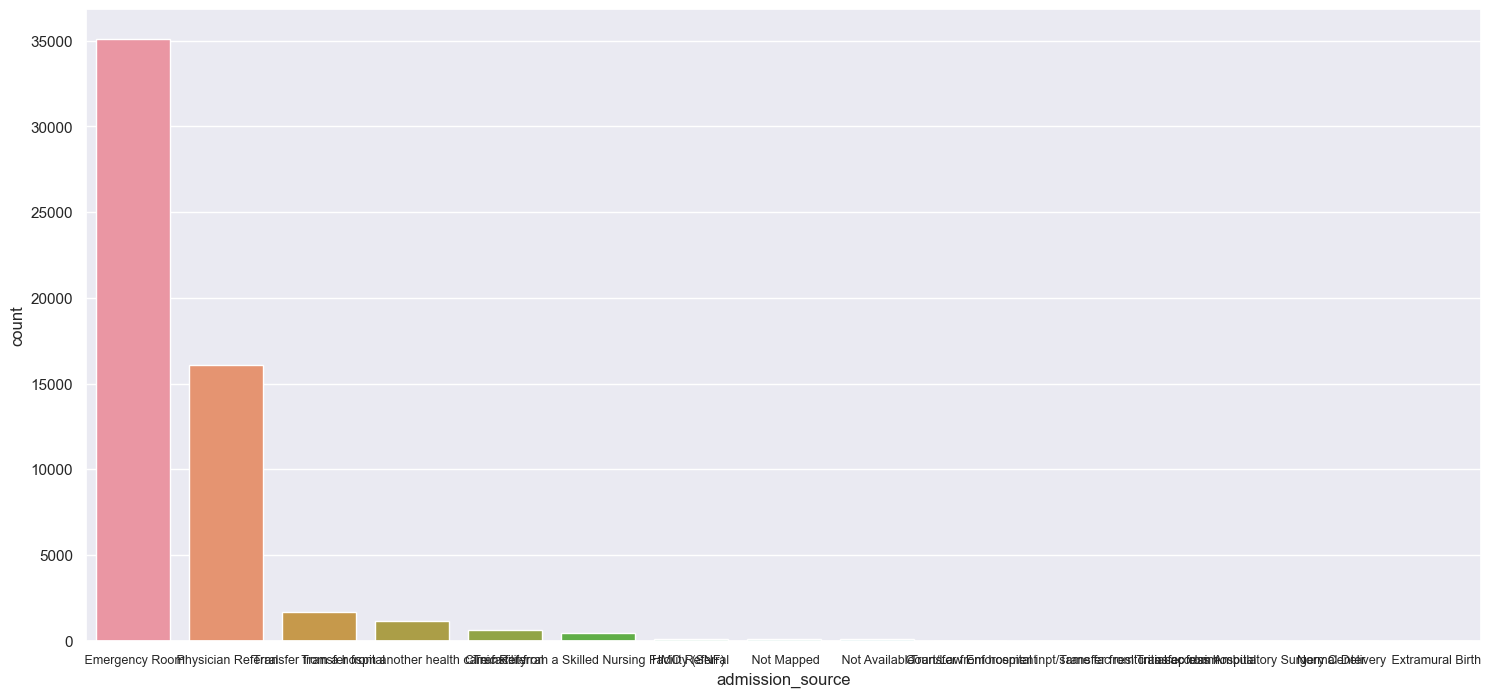

In [1604]:
sns.set() # Reset the formatting defaults
sns.set(rc={"xtick.labelsize": 9})  # Set the x-axis label size to 12

admission_source_order = df_2["admission_source"].value_counts().index

sns.countplot(x=df_2["admission_source"], order = admission_source_order)
plt.show()

In [1605]:
## difficult to get insights from the graphic above because there are a lot of values, so we try this

df_2['admission_source'].value_counts()

admission_source
 Emergency Room                                               35080
 Physician Referral                                           16094
Transfer from a hospital                                       1692
 Transfer from another health care facility                    1168
Clinic Referral                                                 598
 Transfer from a Skilled Nursing Facility (SNF)                 443
HMO Referral                                                    102
 Not Mapped                                                      84
 Not Available                                                   78
 Court/Law Enforcement                                            8
 Transfer from hospital inpt/same fac reslt in a sep claim        6
 Transfer from critial access hospital                            6
 Transfer from Ambulatory Surgery Center                          2
Normal Delivery                                                   1
 Extramural Birth              

-> It's the origin or place from which a patient was coming before being admitted to the current medical encounter or healthcare facility. In healthcare data, this information is recorded to track and categorize the various sources from which patients arrive at the hospital or healthcare setting, as it can be relevant for medical records, billing, and understanding patient demographics and medical history.

-> By analyzing the data above, it's clear that 'Sick Baby', 'Normal Delivery', 'Extramural Birth' are outliers -> replace by mode <br>
-> Merge 'Not Mapped' and 'Not Available' to 'Unknwon', because both of them give the same information (no information) -> replace by mode


-> "Court/Law Enforcement" category doesn't have relevance to out analysis or research, we considered removing it to simplify the dataset and focus on the aspects that are more pertinent to our objectives

-> Merge 'Phsysician Referral', 'Clinic Referral', 'HMO Referral', because it means the same: Patients referred by a healthcare provider or physician for further evaluation or treatment.

-> Merge 'Transfer from a hospital', 'Transfer from another health care facility', 'Transfer from a Skilled Nursing Facility (SNF)', 'Transfer from hospital inpt/same fac resulting in a separate claim', 'Transfer from critical access hospital', 'Transfer from Ambulatory Surgery Center', because the all mean that the patients were transferred.

-> Delete Court/Law Enforcement ???


In [1606]:
df_2['admission_source'] = df_2['admission_source'].replace(' Not Mapped', ' Not Available')
X_val_binary['admission_source'] = X_val_binary['admission_source'].replace(' Not Mapped', ' Not Available')
test['admission_source'] = test['admission_source'].replace(' Not Mapped', ' Not Available')

In [1607]:
df_2.loc[df_2['admission_source'].isin([' Extramural Birth', 'Normal Delivery', ' Court/Law Enforcement',' Sick Baby']), 'admission_source'] = df_2['admission_source'].mode()[0]
X_val_binary.loc[X_val_binary['admission_source'].isin([' Extramural Birth','Normal Delivery', ' Court/Law Enforcement', ' Sick Baby']), 'admission_source'] = df_2['admission_source'].mode()[0]
test.loc[test['admission_source'].isin([' Extramural Birth', 'Normal Delivery',' Court/Law Enforcement', ' Sick Baby']), 'admission_source'] = df_2['admission_source'].mode()[0]

In [1608]:
# df_2.loc[df_2['admission_source'].isin(['Normal Delivery', ' Court/Law Enforcement', ' Not Mapped', ' Not Available']), 'admission_source'] = df_2['admission_source'].mode()[0]
# X_val_binary.loc[X_val_binary['admission_source'].isin(['Normal Delivery', ' Court/Law Enforcement', ' Not Mapped', ' Not Available']), 'admission_source'] = df_2['admission_source'].mode()[0]
# test.loc[test['admission_source'].isin(['Normal Delivery',' Court/Law Enforcement', ' Not Mapped', ' Not Available']), 'admission_source'] = df_2['admission_source'].mode()[0]

In [1609]:
df_2.loc[df_2['admission_source'].isin([' Physician Referral', 'Clinic Referral', 'HMO Referral']), 'admission_source'] = 'Referral'
X_val_binary.loc[X_val_binary['admission_source'].isin([' Physician Referral', 'Clinic Referral', 'HMO Referral']), 'admission_source'] = 'Referral'
test.loc[test['admission_source'].isin([' Physician Referral', 'Clinic Referral', 'HMO Referral']), 'admission_source'] = 'Referral'

In [1610]:
df_2.loc[df_2['admission_source'].isin(['Transfer from a hospital', ' Transfer from another health care facility', \
                                        ' Transfer from a Skilled Nursing Facility (SNF)', \
                                       ' Transfer from hospital inpt/same fac reslt in a sep claim', \
                                       ' Transfer from critial access hospital', \
                                       ' Transfer from Ambulatory Surgery Center']), 'admission_source'] = 'Transfer'

X_val_binary.loc[X_val_binary['admission_source'].isin(['Transfer from a hospital', ' Transfer from another health care facility', \
                                        ' Transfer from a Skilled Nursing Facility (SNF)', \
                                       ' Transfer from hospital inpt/same fac reslt in a sep claim', \
                                       ' Transfer from critial access hospital', \
                                       ' Transfer from Ambulatory Surgery Center']), 'admission_source'] = 'Transfer'


test.loc[test['admission_source'].isin(['Transfer from a hospital', ' Transfer from another health care facility', \
                                        ' Transfer from a Skilled Nursing Facility (SNF)', \
                                       ' Transfer from hospital inpt/same fac reslt in a sep claim', \
                                       ' Transfer from critial access hospital', \
                                       ' Transfer from Ambulatory Surgery Center']), 'admission_source'] = 'Transfer'

In [1611]:
#df_2.loc[df_2['admission_source'].isin([' Not Mapped', ' Not Available']), 'admission_source'] = 'Unknown'

In [1612]:
df_2['admission_source'] = df_2['admission_source'].replace(' Emergency Room', 'Emergency Room')
X_val_binary['admission_source'] = X_val_binary['admission_source'].replace(' Emergency Room', 'Emergency Room')
test['admission_source'] = test['admission_source'].replace(' Emergency Room', 'Emergency Room')

In [1613]:
df_2['admission_source'].value_counts()

admission_source
Emergency Room    35090
Referral          16794
Transfer           3317
 Not Available      162
Name: count, dtype: int64

Replace ' Not Available by the mode of df_2['admission_source']

In [1614]:
df_2['admission_source'] = df_2['admission_source'].replace(' Not Available', df_2['admission_source'].mode()[0])
X_val_binary['admission_source'] = X_val_binary['admission_source'].replace(' Not Available', df_2['admission_source'].mode()[0])
test['admission_source'] = test['admission_source'].replace(' Not Available', df_2['admission_source'].mode()[0])

## medical_specialty

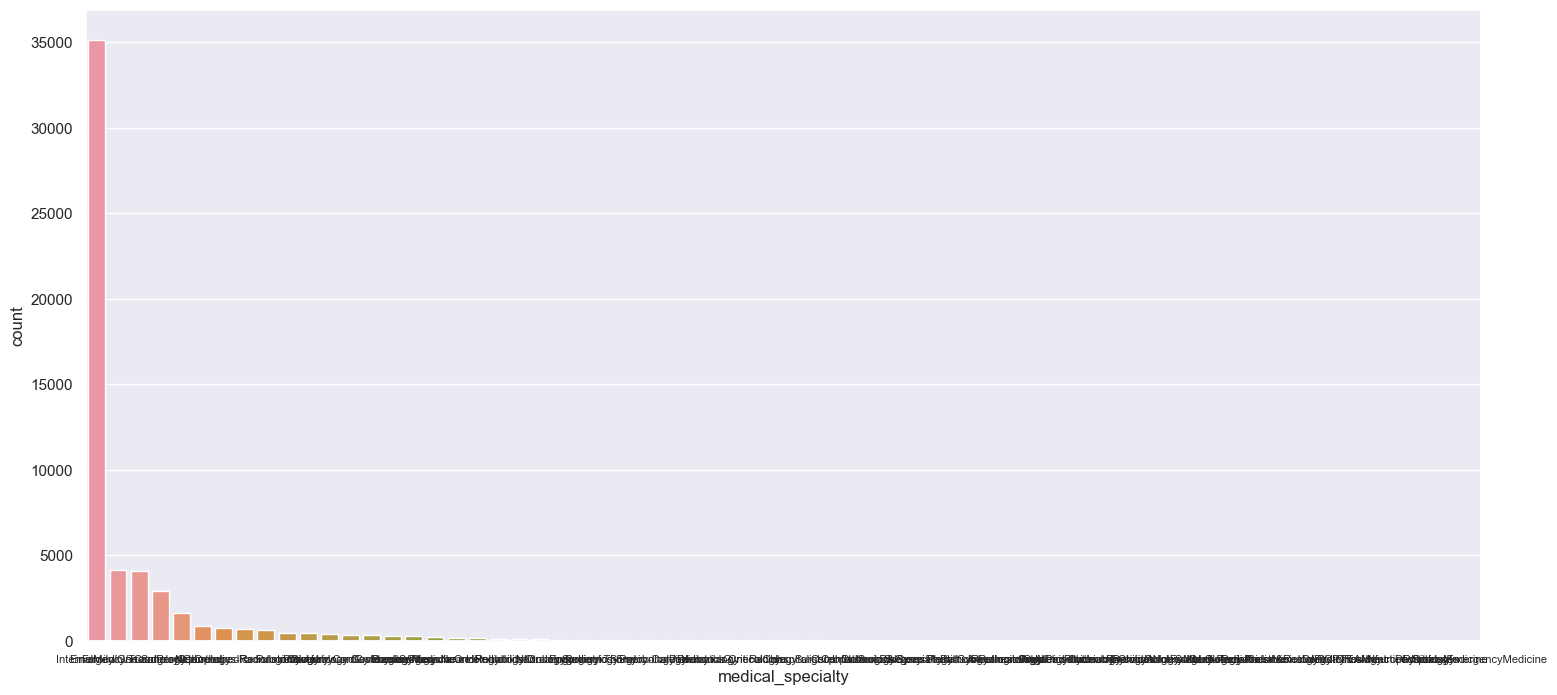

In [1615]:
sns.set() # Reset the formatting defaults
sns.set(rc={"xtick.labelsize": 8})  # Set the x-axis label size to 12

medical_specialty_order = df_2["medical_specialty"].value_counts().index

sns.countplot(x=df_2["medical_specialty"], order = medical_specialty_order)
plt.show()

In [1616]:
## difficult to get insights from the graphic above because there are a lot of values, so we try this

X_train_binary["medical_specialty"].value_counts()

medical_specialty
InternalMedicine                 35161
Emergency/Trauma                  4155
Family/GeneralPractice            4080
Cardiology                        2947
Surgery-General                   1647
                                 ...  
Pediatrics-InfectiousDiseases        1
Neurophysiology                      1
Proctology                           1
SportsMedicine                       1
Pediatrics-EmergencyMedicine         1
Name: count, Length: 66, dtype: int64

-> We start by analyzing the ones that are no medical specialties, having https://www.lusiadas.pt/en/hospitals-clinics/hospital-lusiadas-lisboa/specialties and https://www.hospitaldaluz.pt/lisboa/en/specialties?page=1&searchTerm= as a reference, so we drop them:

.Hospitalist
.Surgeon
.Osteopath -> Osteophathy
.Radiologist -> Radiology
.OutreachServices
.PhysicianNotFound 
.DCPTEAM
.Resident
.Speech


-> Inlude in other specialties:

.Endocrinology-Metabolism -> Endocrinology  <br>
.Orthopedics-Reconstructive -> Orthopedics <br>
.Oncology -> Hematology/Oncology  <br>
.Hematology -> Hematology/Oncology <br>
.Surgery-Thoracic -> Surgery-Cardiovascular/Thoracic  <br>
.Surgery-Cardiovascular -> Surgery-Cardiovascular/Thoracic  <br>
.Gynecology -> ObstetricsandGynecology <br>
.Obstetrics -> ObstetricsandGynecology <br>
.Obsterics&Gynecology-GynecologicOnco (a lot of specialties) -> ObstetricsandGynecology <br>
.Pediatrics-Pulmonology -> Pulmonology (OR Pediatrics) <br>
.Pediatrics-EmergencyMedicine -> Pediatrics (OR Emergency/Trauma) <br>
.Pediatrics-CriticalCare -> Pediatrics  <br>
.Pediatrics-Endocrinology -> Endocrinology (OR Pediatrics) <br>
.Anesthesiology-Pediatric -> Anesthesiology  <br>
.Pediatrics-AllergyandImmunology -> AllergyandImmunology (OR Pediatrics) <br>
.Pediatrics-InfectiousDiseases -> InfectiousDiseases (OR Pediatrics) <br>
.SurgicalSpecialty -> Surgery-General <br>
.Surgery-Colon&Rectal -> Proctology https://en.wikipedia.org/wiki/Colorectal_surgery <br>
.Pediatrics-Hematology-Oncology -> Hematology/Oncology (??) https://careersinmedicine.aamc.org/explore-options/specialty-profiles/pediatric-hematology-oncology <br>

---->Doubt:

.Surgery-Cardiovascular/Thoracic (arent these 2 specialties??) https://www.rcseng.ac.uk/news-and-events/media-centre/media-background-briefings-and-statistics/cardiothoracic-surgery/


-> Dont know what do to:

.Emergency/Trauma (??? left it)  -> it is already in admission_type...


-> Regarding Pediatrics-'something', we already know that is pediatrics due to its age, maybe we could add to the specialty 'something'

In [1617]:
values_to_drop = [
    'Podiatry',
    'Psychology',
    'Hospitalist',
    'Osteopath',
    'OutreachServices',
    'PhysicianNotFound',
    'DCPTEAM',
    'Speech'
]

df_2 = df_2[~df_2['medical_specialty'].isin(values_to_drop)]

# Replace val and test values by the mode
mode = df_2['medical_specialty'].mode()[0]
X_val_binary['medical_specialty'] = X_val_binary['medical_specialty'].replace(values_to_drop, mode)
test['medical_specialty'] = test['medical_specialty'].replace(values_to_drop, mode)

In [1618]:
others=['Neurophysiology','Resident', 'Proctology','SportsMedicine','Pathology','Dentistry','Ophthalmology','Psychiatry',
        'PhysicalMedicineandRehabilitation','Anesthesiology-Pediatric','Anesthesiology','Pediatrics-AllergyandImmunology',
        'Neurology','InfectiousDiseases','AllergyandImmunology','Otolaryngology','Pediatrics-Neurology','Urology','Gynecology',
        'ObstetricsandGynecology','Obstetrics','Endocrinology','Pediatrics-InfectiousDiseases','Gastroenterology','Rheumatology','Dermatology',
        'Psychiatry-Addictive', 'Perinatology']

def clean_medical_specialty(df):
    df.loc[df['medical_specialty'].isin(['Pediatrics-Pulmonology','Pulmonology']), 'medical_specialty'] = 'Pulmonology'
    
    df.loc[df['medical_specialty'].isin(['Cardiology-Pediatric','Cardiology']), 'medical_specialty'] = 'Cardiology'
    
    df.loc[df['medical_specialty'].isin(['Pediatrics-Endocrinology','Endocrinology-Metabolism']), 'medical_specialty'] = 'Endocrinology'
    
    df.loc[df['medical_specialty'].isin(['Pediatrics-Hematology-Oncology','Hematology',
                                            'Hematology/Oncology','Oncology',
                                            'Obsterics&Gynecology-GynecologicOnco']), 'medical_specialty'] = 'Hematology/Oncology'
    
    df.loc[df['medical_specialty'].isin(['Radiologist','Radiology']), 'medical_specialty'] = 'Radiology'
    
    df.loc[df['medical_specialty'].isin(['Pediatrics-CriticalCare','Pediatrics','Psychiatry-Child/Adolescent']), 'medical_specialty'] = 'Pediatric'
    
    df.loc[df['medical_specialty'].isin(['Emergency/Trauma','Pediatrics-EmergencyMedicine']), 'medical_specialty'] = 'Emergency'
    
    df.loc[df['medical_specialty'].isin(['Surgery-General','Surgeon','Surgery-Thoracic','Surgery-Pediatric','Surgery-Vascular','Surgery-Plastic',
                                            'Surgery-Colon&Rectal','SurgicalSpecialty','Surgery-Cardiovascular','Surgery-Neuro',
                                            'Surgery-Cardiovascular/Thoracic','Orthopedics-Reconstructive',
                                            'Surgery-Maxillofacial','Surgery-PlasticwithinHeadandNeck']), 'medical_specialty'] = 'Surgery'
    
    df['medical_specialty'] = df['medical_specialty'].replace(others, 'Other')

    df['medical_specialty'] = df['medical_specialty'].replace('Pediatric', 'Other')

    return df


df_2=clean_medical_specialty(df_2)
X_val_binary=clean_medical_specialty(X_val_binary)
test=clean_medical_specialty(test)

In [1619]:
df_2["medical_specialty"].value_counts()

medical_specialty
InternalMedicine          35161
Emergency                  4156
Family/GeneralPractice     4080
Surgery                    3396
Cardiology                 2950
Other                      2305
Nephrology                  865
Orthopedics                 743
Radiology                   685
Pulmonology                 483
Hematology/Oncology         371
Name: count, dtype: int64

In [1620]:
X_val_binary["medical_specialty"].value_counts()

medical_specialty
InternalMedicine          9102
Emergency                 1074
Family/GeneralPractice    1011
Surgery                    925
Cardiology                 726
Other                      606
Nephrology                 227
Orthopedics                205
Radiology                  161
Pulmonology                121
Hematology/Oncology         90
Name: count, dtype: int64

In [1621]:
test["medical_specialty"].value_counts()

medical_specialty
InternalMedicine          19474
Emergency                  2248
Family/GeneralPractice     2223
Surgery                    1932
Cardiology                 1638
Other                      1290
Nephrology                  477
Orthopedics                 446
Radiology                   337
Pulmonology                 270
Hematology/Oncology         195
Name: count, dtype: int64

## discharge_disposition

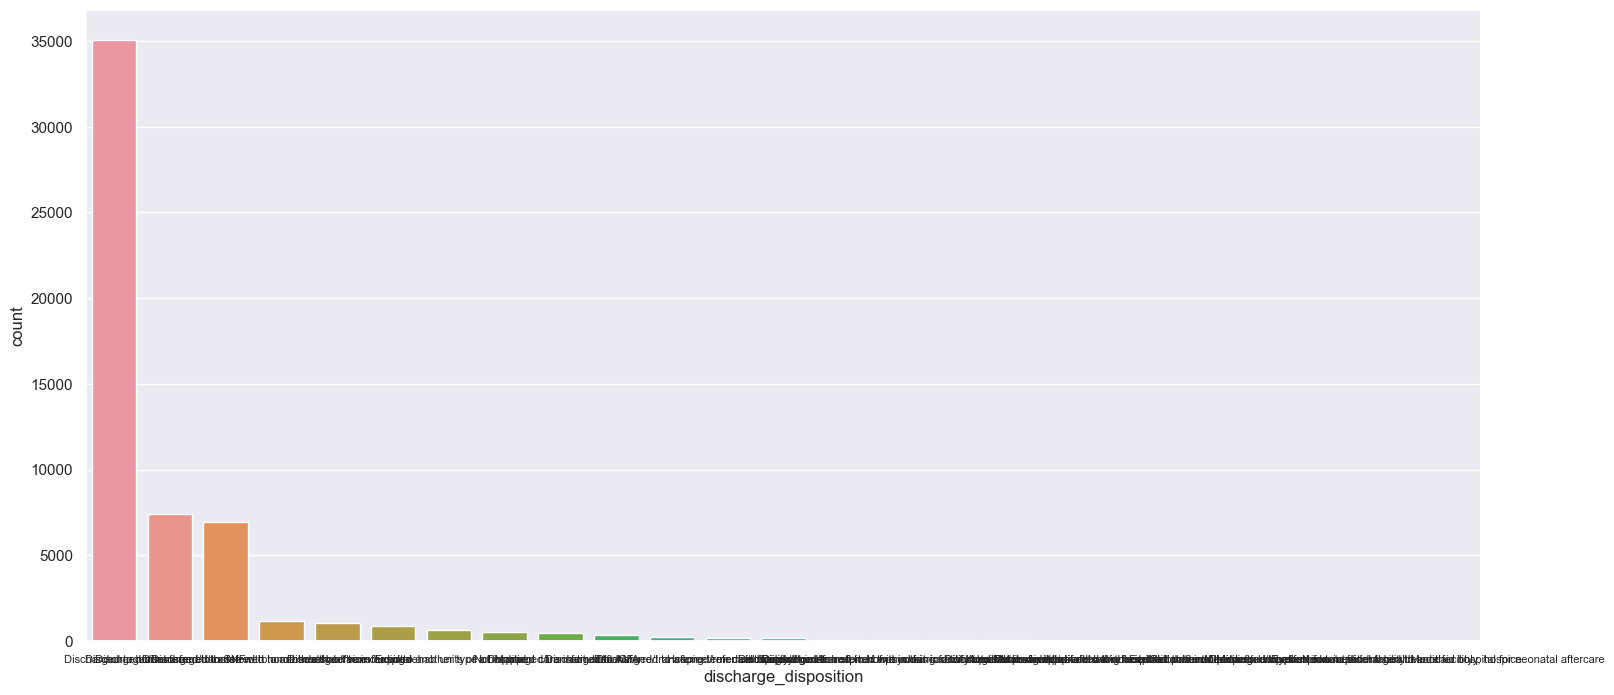

In [1622]:
sns.set() # Reset the formatting defaults
sns.set(rc={"xtick.labelsize": 8})  # Set the x-axis label size to 12

medical_specialty_order = df_2["discharge_disposition"].value_counts().index

sns.countplot(x=df_2["discharge_disposition"], order = medical_specialty_order)
plt.show()

In [1623]:
## difficult to get insights from the graphic above because there are a lot of values, so we try this

df_2["discharge_disposition"].value_counts()

discharge_disposition
Discharged to home                                                                                           35080
Discharged/transferred to SNF                                                                                 7379
Discharged/transferred to home with home health service                                                       6952
Discharged/transferred to another short term hospital                                                         1154
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1058
Expired                                                                                                        848
Discharged/transferred to another type of inpatient care institution                                           618
Not Mapped                                                                                                     531
Discharged/transferred to ICF                             

Group some categories in the "discharge_disposition" column if they have similar meanings

.Home:

    "Discharged to home"
    "Discharged/transferred to home with home health service"
    "Discharged/transferred to home under care of Home IV provider"
 
.Rehab/Medical Facility:

    "Discharged/transferred to SNF" (Skilled Nurse Facility)
    "Discharged/transferred to another short term hospital"
    "Discharged/transferred to another rehab fac including rehab units of a hospital"
    "Discharged/transferred to ICF" (Intermediate Care Facility)
    "Discharged/transferred to a long term care hospital."
    "Discharged/transferred to a federal health care facility."
    "Discharged/transferred to another type of inpatient care institution"
    
.Hospice:

    "Hospice / medical facility"
    "Hospice / home"
    "Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital"
    
.Expired:

    "Expired" (Patient who has passed away)
    "Expired at home. Medicaid only, hospice."
    "Expired in a medical facility. Medicaid only, hospice."

    
.Other:

    "Left AMA"
    "Discharged/transferred/referred to this institution for outpatient services"
    "Discharged/transferred/referred another institution for outpatient services"
    "Admitted as an inpatient to this hospital"
    "Neonate discharged to another hospital for neonatal aftercare"
    "Still patient or expected to return for outpatient services"


<b>BEST APPROACH:<b> <br>
2 groups: 'home' & 'not home'; it's not important to know were they were discharged if it was not home -> FEATURE ENGINEERING
-> Apenas nos interessa saber se a pessoa teve alta; No caso de falecimento não consideramos que teve alta, pois consideramos o falecimento como uma não recuparação, que, por sua vez, não se traduz em alta

In [1624]:
# def label_discharge_disposition(df):

#     df.loc[df['discharge_disposition'].isin(['Discharged to home',\
#         'Discharged/transferred to home with home health service', \
#         'Discharged/transferred to home under care of Home IV provider']), 'discharge_disposition'] = 'Home'

#     df.loc[df['discharge_disposition'].isin(['Discharged/transferred to SNF',\
#         'Discharged/transferred to another short term hospital',\
#         'Discharged/transferred to another rehab fac including rehab units of a hospital',\
#         'Discharged/transferred to ICF',\
#         'Discharged/transferred to a long term care hospital.',\
#         'Discharged/transferred to a federal health care facility.',\
#         'Discharged/transferred to another type of inpatient care institution',\
#         'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
#         'Discharged/transferred within this institution to Medicare approved swing bed',
#         'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
#         'Discharged/transferred to another rehab fac including rehab units of a hospital .']), 'discharge_disposition'] = 'Medical Facility'

#     df.loc[df['discharge_disposition'].isin(['Hospice / medical facility', \
#                                                 'Hospice / home']), 'discharge_disposition'] = 'Hospice'

#     df.loc[df['discharge_disposition'].isin(['Expired',\
#                                                 'Expired at home. Medicaid only, hospice.',\
#                                                 'Expired in a medical facility. Medicaid only, hospice.']), 'discharge_disposition'] = 'Expired'

#     df.loc[df['discharge_disposition'].isin(['Left AMA',\
#                                                 'Discharged/transferred/referred to this institution for outpatient services',
#                                                 'Discharged/transferred/referred another institution for outpatient services',\
#                                                 'Neonate discharged to another hospital for neonatal aftercare',\
#                                                 'Still patient or expected to return for outpatient services', \
#                                                 'Admitted as an inpatient to this hospital',\
#                                                 'Not Mapped']), 'discharge_disposition'] = 'Other'

# label_discharge_disposition(df_2)
# label_discharge_disposition(X_val_binary)
# label_discharge_disposition(test)

In [1625]:
# home:1
# not home: 0

df_2['discharge_disposition'].replace({'Discharged to home': 1, 'Discharged/transferred to home with home health service': 1, 'Discharged/transferred to home under care of Home IV provider': 1, 'Expired at home. Medicaid only, hospice.': 0, 'Hospice / home': 1}, inplace=True)
df_2['discharge_disposition'].replace(to_replace='.*', value=0, regex=True, inplace=True)

X_val_binary['discharge_disposition'].replace({'Discharged to home': 1, 'Discharged/transferred to home with home health service': 1, 'Discharged/transferred to home under care of Home IV provider': 1, 'Expired at home. Medicaid only, hospice.': 0, 'Hospice / home': 1}, inplace=True)
X_val_binary['discharge_disposition'].replace(to_replace='.*', value=0, regex=True, inplace=True)

test['discharge_disposition'].replace({'Discharged to home': 1, 'Discharged/transferred to home with home health service': 1, 'Discharged/transferred to home under care of Home IV provider': 1, 'Expired at home. Medicaid only, hospice.': 0, 'Hospice / home': 1}, inplace=True)
test['discharge_disposition'].replace(to_replace='.*', value=0, regex=True, inplace=True)

In [1626]:

# Change the name of the 'discharge_disposition' to 'discharged_home'
df_2.rename(columns={'discharge_disposition': 'discharged_home'}, inplace=True)
X_val_binary.rename(columns={'discharge_disposition': 'discharged_home'}, inplace=True)
test.rename(columns={'discharge_disposition': 'discharged_home'}, inplace=True)

# Change the data type of the 'column_name' to boolean (bool)
df_2['discharged_home'] = df_2['discharged_home'].astype(bool)
X_val_binary['discharged_home'] = X_val_binary['discharged_home'].astype(bool)
test['discharged_home'] = test['discharged_home'].astype(bool)

df_2['discharged_home'].value_counts()

discharged_home
True     42279
False    12916
Name: count, dtype: int64

In [1627]:
non_metric_features.remove('discharge_disposition')
non_metric_features.append('discharged_home')

In [1628]:
# # Create a feature that has 1 if the medication of a diabetic person changed and 0 if not 
# df_2["change_in_diabetic_med"] = ((df_2["change_in_meds_during_hospitalization"] == 1) & (df_2["prescribed_diabetes_meds"] == 1))
# X_val_binary["change_in_diabetic_med"] = ((X_val_binary["change_in_meds_during_hospitalization"] == 1) & (X_val_binary["prescribed_diabetes_meds"] == 1))
# test["change_in_diabetic_med"] = ((test["change_in_meds_during_hospitalization"] == 1) & (test["prescribed_diabetes_meds"] == 1))


## analyse 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis

group codes according to wikipedia
https://en.wikipedia.org/wiki/List_of_ICD-9_codes

In [1629]:
# group 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis' into icd9 groups
icd9_mapping = {
    (1, 139): 'Infection',      # List of ICD-9 codes 001–139: infectious and parasitic diseases
    (140, 239): 'Neoplasm',    # List of ICD-9 codes 140–239: neoplasms
    (240, 249): 'Endocrine/Metabolic/Immunity',
    (250,250.99): 'Diabetes', 
    (251, 279): 'Endocrine/Metabolic/Immunity',    # List of ICD-9 codes 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
    (280, 289): 'Blood',    # List of ICD-9 codes 280–289: diseases of the blood and blood-forming organs
    (290, 319): 'Mental',    # List of ICD-9 codes 290–319: mental disorders
    (320, 389): 'SNC',    # List of ICD-9 codes 320–389: diseases of the nervous system and sense organs
    (390, 459): 'Circulatory',    # List of ICD-9 codes 390–459: diseases of the circulatory system
    (785, 785): 'Circulatory', 
    (460, 519): 'Respiratory',    # List of ICD-9 codes 460–519: diseases of the respiratory system
    (786, 786): 'Respiratory',
    (520, 579):  'Digestive',    # List of ICD-9 codes 520–579: diseases of the digestive system
    (787, 787):  'Digestive',
    (580, 629): 'Genitourinary',   # List of ICD-9 codes 580–629: diseases of the genitourinary system
    (630, 679): 'Pregnancy',   # List of ICD-9 codes 630–679: complications of pregnancy, childbirth, and the puerperium
    (680, 709): 'Skin',   # List of ICD-9 codes 680–709: diseases of the skin and subcutaneous tissue
    (782, 782): 'Skin',
    (710, 739): 'Musculoskeletal',   # List of ICD-9 codes 710–739: diseases of the musculoskeletal system and connective tissue
    (740, 759): 'Congenital',   # List of ICD-9 codes 740–759: congenital anomalies
    (760, 779): 'Perinatal',   # List of ICD-9 codes 760–779: certain conditions originating in the perinatal period
    (780, 781): 'Syndromes', 
    (783, 784): 'Syndromes', 
    (788, 799): 'Syndromes',   # List of ICD-9 codes 780–799: symptoms, signs, and ill-defined conditions
    (800, 999): 'Injury/Poisoning',   # List of ICD-9 codes 800–999: injury and poisoning
    ('E', 'E999'): 'External Causes',  # External causes of injury and supplemental classification starting with 'E'
    ('V', 'V91'): 'External Causes',   # External causes of injury and supplemental classification starting with 'V'
}

def map_icd9_to_category(icd9_code):      
    if isinstance(icd9_code, (int, float)):
        icd9_code = str(icd9_code)
        
    if icd9_code[0] == 'E' or icd9_code[0] == 'V':  #Code starts with 'E' or 'V'
        return 'External Causes'

    for code_range, category in icd9_mapping.items():
        start, end = code_range

        if start <= float(icd9_code) <= end:
            return category


# Apply the mapping function to the columns
df_2['primary_diagnosis'] = df_2['primary_diagnosis'].apply(map_icd9_to_category)
df_2['secondary_diagnosis'] = df_2['secondary_diagnosis'].apply(map_icd9_to_category)
df_2['additional_diagnosis'] = df_2['additional_diagnosis'].apply(map_icd9_to_category)

X_val_binary['primary_diagnosis'] = X_val_binary['primary_diagnosis'].apply(map_icd9_to_category)
X_val_binary['secondary_diagnosis'] = X_val_binary['secondary_diagnosis'].apply(map_icd9_to_category)
X_val_binary['additional_diagnosis'] = X_val_binary['additional_diagnosis'].apply(map_icd9_to_category)

test['primary_diagnosis'] = test['primary_diagnosis'].apply(map_icd9_to_category)
test['secondary_diagnosis'] = test['secondary_diagnosis'].apply(map_icd9_to_category)
test['additional_diagnosis'] = test['additional_diagnosis'].apply(map_icd9_to_category)

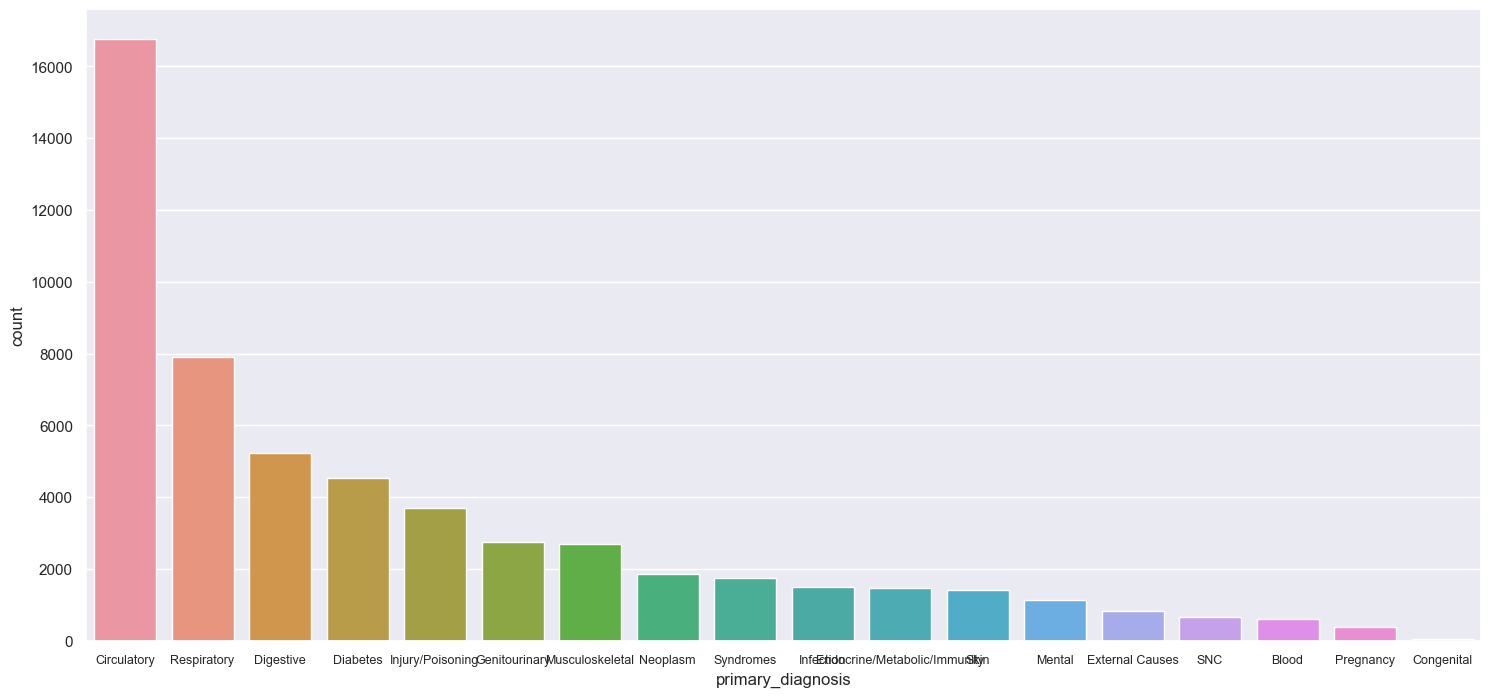

In [1630]:
sns.set() 
sns.set(rc={"xtick.labelsize": 9})  

diagnosis_order = df_2["primary_diagnosis"].value_counts().index

sns.countplot(x=df_2["primary_diagnosis"], order = diagnosis_order )
plt.show()

In [1631]:
diagnosis_percentage = round(df_2['primary_diagnosis'].value_counts(normalize=True) * 100, 1)
diagnosis_count = df_2['primary_diagnosis'].value_counts()

df_percentage = pd.DataFrame({'Diagnosis': diagnosis_percentage.index, 'Percentage': diagnosis_percentage.values})
df_count = pd.DataFrame({'Diagnosis': diagnosis_count.index, 'Count': diagnosis_count.values})

pd.merge(df_count, df_percentage, on='Diagnosis')

,Diagnosis,Count,Percentage
0,Circulatory,16753,30.4
1,Respiratory,7912,14.3
2,Digestive,5233,9.5
3,Diabetes,4539,8.2
4,Injury/Poisoning,3689,6.7
5,Genitourinary,2758,5.0
6,Musculoskeletal,2698,4.9
7,Neoplasm,1856,3.4
8,Syndromes,1738,3.1
9,Infection,1491,2.7


In [1632]:
# In the analysis, groups that covered less than 2.5% of encounters were grouped into “other” category.

def group_diagnosis(df):

    diagnosis = ['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']

    for d in diagnosis:
        df[d] = df[d].replace('External Causes', 'Other')
        df[d] = df[d].replace('SNC', 'Other')
        df[d] = df[d].replace('Blood', 'Other')
        df[d] = df[d].replace('Pregnancy', 'Other')
        df[d] = df[d].replace('Congenital', 'Other')
        df[d] = df[d].replace('Mental', 'Other')


        # df[d] = df[d].replace('Mental', 'Other1')
        # df[d] = df[d].replace('Skin', 'Other1')
        # df[d] = df[d].replace('Endocrine/Metabolic/Immunity', 'Other1')
        # df[d] = df[d].replace('Infection', 'Other1')
        # df[d] = df[d].replace('Syndromes', 'Other1')
        # df[d] = df[d].replace('Neoplasm', 'Other1')
        
group_diagnosis(df_2)
group_diagnosis(X_val_binary)
group_diagnosis(test)

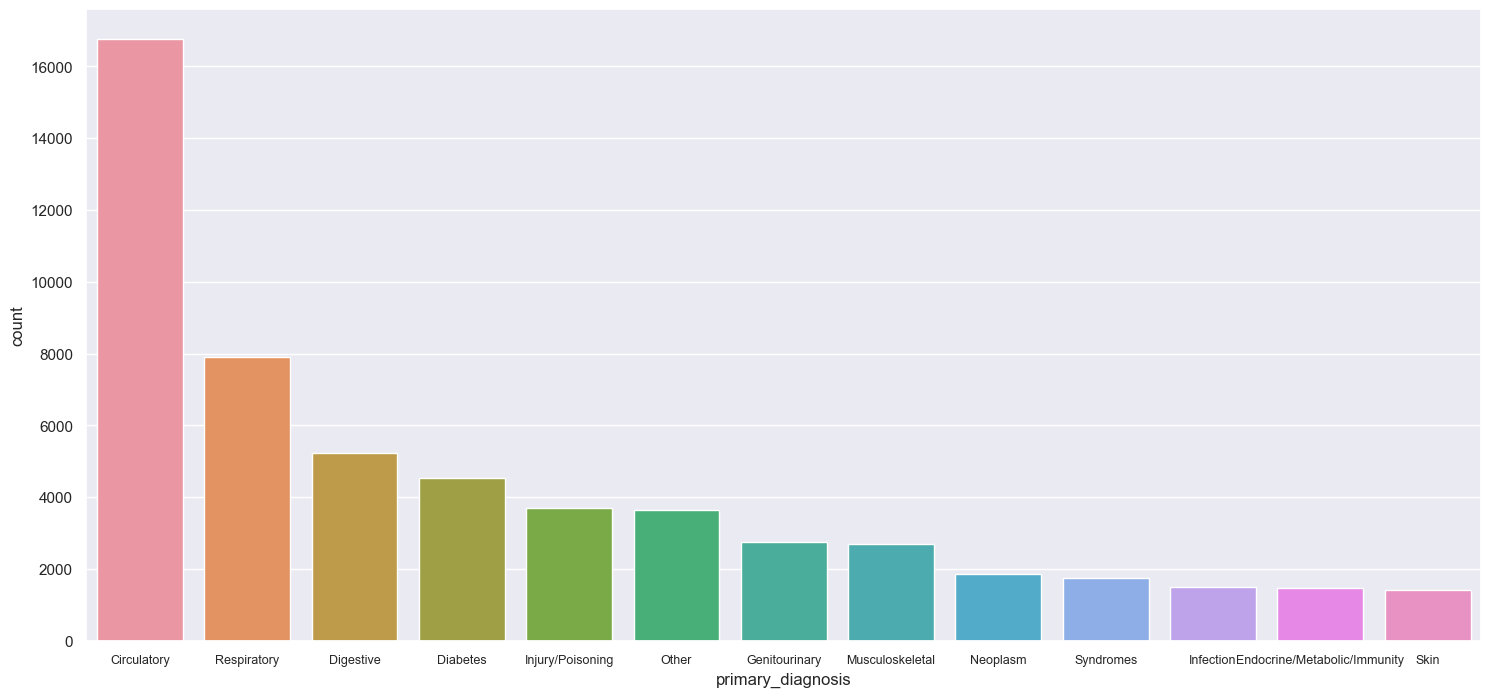

In [1633]:
sns.set() 
sns.set(rc={"xtick.labelsize": 9})  

diagnosis_order = df_2["primary_diagnosis"].value_counts().index

sns.countplot(x=df_2["primary_diagnosis"], order = diagnosis_order )
plt.show()

In [1634]:
# sns.set() 
# sns.set(rc={"xtick.labelsize": 9})  

# diagnosis_order = df_2["secondary_diagnosis"].value_counts().index

# sns.countplot(x=df_2["secondary_diagnosis"], order = diagnosis_order )
# plt.show()

In [1635]:
# sns.set() 
# sns.set(rc={"xtick.labelsize": 9})  

# diagnosis = df_2["additional_diagnosis"].value_counts().index

# sns.countplot(x=df_2["additional_diagnosis"], order = diagnosis )
# plt.show()

In [1636]:
# icd9_mapping_2 = {
#     1: 'Infection',
#     2: 'Neoplasm',
#     3: 'Endocrine/Metabolic/Immunity',
#     4: 'Blood',
#     5: 'Mental',
#     6: 'SNC',
#     7: 'Circulatory',
#     8: 'Respiratory',
#     9: 'Digestive',
#     10: 'Genitourinary',
#     11: 'Pregnancy',
#     12: 'Skin',
#     13: 'Musculoskeletal',
#     14: 'Congenital',
#     15: 'Perinatal',
#     16: 'Syndromes',
#     17: 'Injury/Poisoning',
#     18: 'External Causes'
# }

# # List of columns to replace values
# columns_to_replace = ['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']

# # Replace values in the specified columns using icd9_mapping_2
# df_2[columns_to_replace] = df_2[columns_to_replace].replace(icd9_mapping_2)
# X_val_binary[columns_to_replace] = X_val_binary[columns_to_replace].replace(icd9_mapping_2)
# test[columns_to_replace] = test[columns_to_replace].replace(icd9_mapping_2)

In [1637]:
'''# def diagnosis_cronic_disease(df):    
#     df["primary_diagnosis1"] = pd.to_numeric(df['primary_diagnosis'], errors='coerce')
#     df["secondary_diagnosis1"] = pd.to_numeric(df['secondary_diagnosis'], errors='coerce')
#     df["additional_diagnosis1"] = pd.to_numeric(df['additional_diagnosis'], errors='coerce')
#     starting_codes = [249, 250, 401, 428, 493]
#     mask = (
#         df['primary_diagnosis1'].apply(lambda x: any(str(x).startswith(str(code)) for code in starting_codes)) |
#         df['secondary_diagnosis1'].apply(lambda x: any(str(x).startswith(str(code)) for code in starting_codes)) |
#         df['additional_diagnosis1'].apply(lambda x: any(str(x).startswith(str(code)) for code in starting_codes))
#     )

#     df['has_chronic_disease'] = np.where(mask, 1, 0)
#     df["has_chronic_disease"] = df["has_chronic_disease"].astype(bool)
#     df.drop(columns=["primary_diagnosis1", "secondary_diagnosis1", "additional_diagnosis1"], inplace=True)

#     df.drop('primary_diagnosis', axis = 1, inplace=True)
#     df.drop('secondary_diagnosis', axis = 1, inplace=True)
#     df.drop('additional_diagnosis', axis = 1, inplace=True)


# diagnosis_cronic_disease(df_2)
# diagnosis_cronic_disease(X_val_binary)
# diagnosis_cronic_disease(test)

# non_metric_features.remove('primary_diagnosis')
# non_metric_features.remove('secondary_diagnosis')
# non_metric_features.remove('additional_diagnosis')
# non_metric_features.append('has_chronic_disease')


# group 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis' into icd9 groups
icd9_mapping = {
    (1, 139): 0,      # List of ICD-9 codes 001–139: infectious and parasitic diseases
    (140, 239): 7,    # List of ICD-9 codes 140–239: neoplasms
    (240, 279): 0,    # List of ICD-9 codes 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
    (280, 289): 0,    # List of ICD-9 codes 280–289: diseases of the blood and blood-forming organs
    (290, 319): 0,    # List of ICD-9 codes 290–319: mental disorders
    (320, 389): 0,    # List of ICD-9 codes 320–389: diseases of the nervous system and sense organs
    (390, 459): 1,    # List of ICD-9 codes 390–459: diseases of the circulatory system
    (460, 519): 2,    # List of ICD-9 codes 460–519: diseases of the respiratory system
    (520, 579): 3,   # List of ICD-9 codes 520–579: diseases of the digestive system
    (580, 629): 6,   # List of ICD-9 codes 580–629: diseases of the genitourinary system
    (630, 679): 0,   # List of ICD-9 codes 630–679: complications of pregnancy, childbirth, and the puerperium
    (680, 709): 0,   # List of ICD-9 codes 680–709: diseases of the skin and subcutaneous tissue
    (710, 739): 5,   # List of ICD-9 codes 710–739: diseases of the musculoskeletal system and connective tissue
    (740, 759): 0,   # List of ICD-9 codes 740–759: congenital anomalies
    (760, 779): 0,   # List of ICD-9 codes 760–779: certain conditions originating in the perinatal period
    (780, 799): 0,   # List of ICD-9 codes 780–799: symptoms, signs, and ill-defined conditions
    (800, 999): 4,   # List of ICD-9 codes 800–999: injury and poisoning
    #('E', 'E999'): 18,  # External causes of injury and supplemental classification starting with 'E'
    #('V', 'V91'): 18,   # External causes of injury and supplemental classification starting with 'V'
}

def map_icd9_to_category(icd9_code):      
    if isinstance(icd9_code, (int, float)):
        icd9_code = str(icd9_code)
        
    if icd9_code[0] == 'E' or icd9_code[0] == 'V':  #Code starts with 'E' or 'V'
        return 0

    for code_range, category in icd9_mapping.items():
        start, end = code_range

        if start <= float(icd9_code) <= end:
            return category


# Apply the mapping function to the columns
df_2['primary_diagnosis'] = df_2['primary_diagnosis'].apply(map_icd9_to_category)
df_2['secondary_diagnosis'] = df_2['secondary_diagnosis'].apply(map_icd9_to_category)
df_2['additional_diagnosis'] = df_2['additional_diagnosis'].apply(map_icd9_to_category)

X_val_binary['primary_diagnosis'] = X_val_binary['primary_diagnosis'].apply(map_icd9_to_category)
X_val_binary['secondary_diagnosis'] = X_val_binary['secondary_diagnosis'].apply(map_icd9_to_category)
X_val_binary['additional_diagnosis'] = X_val_binary['additional_diagnosis'].apply(map_icd9_to_category)

test['primary_diagnosis'] = test['primary_diagnosis'].apply(map_icd9_to_category)
test['secondary_diagnosis'] = test['secondary_diagnosis'].apply(map_icd9_to_category)
test['additional_diagnosis'] = test['additional_diagnosis'].apply(map_icd9_to_category)'''


'# def diagnosis_cronic_disease(df):    \n#     df["primary_diagnosis1"] = pd.to_numeric(df[\'primary_diagnosis\'], errors=\'coerce\')\n#     df["secondary_diagnosis1"] = pd.to_numeric(df[\'secondary_diagnosis\'], errors=\'coerce\')\n#     df["additional_diagnosis1"] = pd.to_numeric(df[\'additional_diagnosis\'], errors=\'coerce\')\n#     starting_codes = [249, 250, 401, 428, 493]\n#     mask = (\n#         df[\'primary_diagnosis1\'].apply(lambda x: any(str(x).startswith(str(code)) for code in starting_codes)) |\n#         df[\'secondary_diagnosis1\'].apply(lambda x: any(str(x).startswith(str(code)) for code in starting_codes)) |\n#         df[\'additional_diagnosis1\'].apply(lambda x: any(str(x).startswith(str(code)) for code in starting_codes))\n#     )\n\n#     df[\'has_chronic_disease\'] = np.where(mask, 1, 0)\n#     df["has_chronic_disease"] = df["has_chronic_disease"].astype(bool)\n#     df.drop(columns=["primary_diagnosis1", "secondary_diagnosis1", "additional_diagnosis1"], inpla

In [1638]:
# df_2['primary_diagnosis'] = df_2['primary_diagnosis'].astype(str)
# mask = df_2['primary_diagnosis'].str.replace('.', '', 1).str.replace(' ', '').str.startswith('250')

# result = df_2[mask]

In [1639]:
# result

In [1640]:
# print(df_2['additional_diagnosis'].isna().sum())
# print(df_2['primary_diagnosis'].isna().sum())
# print(df_2['secondary_diagnosis'].isna().sum())
# print(X_val_binary['additional_diagnosis'].isna().sum())
# print(X_val_binary['primary_diagnosis'].isna().sum())
# print(X_val_binary['secondary_diagnosis'].isna().sum())
# print(test['additional_diagnosis'].isna().sum())
# print(test['primary_diagnosis'].isna().sum())
# print(test['secondary_diagnosis'].isna().sum())

In [1641]:
#df_2['primary_diagnosis'].value_counts()

In [1642]:
#df_2['primary_diagnosis'].isna().sum()

In [1643]:
#df_2['secondary_diagnosis'].value_counts()

In [1644]:
#X_train_binary['secondary_diagnosis'].isna().sum()

In [1645]:
#df_2['additional_diagnosis'].value_counts()

In [1646]:
#df_2['additional_diagnosis'].isna().sum()

# Feature Engineering

## is_male

In [1647]:
df_2['gender'] = df_2['gender'].map({'Male': 1, 'Female': 0})
X_val_binary['gender'] = X_val_binary['gender'].map({'Male': 1, 'Female': 0})
test['gender'] = test['gender'].map({'Male': 1, 'Female': 0})

df_2.rename(columns={'gender': 'is_male'}, inplace=True)
X_val_binary.rename(columns={'gender': 'is_male'}, inplace=True)
test.rename(columns={'gender': 'is_male'}, inplace=True)

In [1648]:
df_2['is_male'] = df_2['is_male'].astype(bool)
X_val_binary['is_male'] = X_val_binary['is_male'].astype(bool)
test['is_male'] = test['is_male'].astype(bool)

In [1649]:
non_metric_features.remove('gender')
non_metric_features.append('is_male')

In [1650]:
df_2['is_male'].value_counts()

is_male
False    29601
True     25594
Name: count, dtype: int64

## healthy_heartrate

In [1651]:
df_2['average_pulse_bpm']=df_2['average_pulse_bpm'].apply(lambda x: True if x<=110 else False)
X_val_binary['average_pulse_bpm']=X_val_binary['average_pulse_bpm'].apply(lambda x: True if x<=110 else False)
test['average_pulse_bpm']=test['average_pulse_bpm'].apply(lambda x: True if x<=110 else False)

In [1652]:
df_2.rename(columns={'average_pulse_bpm': 'healthy_heartrate'}, inplace=True)
X_val_binary.rename(columns={'average_pulse_bpm': 'healthy_heartrate'}, inplace=True)
test.rename(columns={'average_pulse_bpm': 'healthy_heartrate'}, inplace=True)

In [1653]:
df_2['healthy_heartrate'].value_counts()

healthy_heartrate
True     35317
False    19878
Name: count, dtype: int64

In [1654]:
metric_features.remove('average_pulse_bpm')
non_metric_features.append('healthy_heartrate')

## glucose_test_result
Since the glucose values over 180 mg/dL already indicate high blood sugar (in this particular case we are assuming a person ate 2 hours ago, if not the thrsehold is 120), having 200 and 300 is redundate so we are replacing them for High.
https://www.cuf.pt/saude-a-z/hiperglicemia

In [1655]:
df_2.replace({'glucose_test_result': {'>200': 2, '>300': 2, 'Norm': 1, 'None' : 0 }}, inplace=True)
X_val_binary.replace({'glucose_test_result': {'>200': 2, '>300': 2, 'Norm': 1, 'None' : 0 }}, inplace=True)
test.replace({'glucose_test_result': {'>200': 2, '>300': 2, 'Norm': 1, 'None' : 0 }}, inplace=True)

df_2['glucose_test_result'] = df_2['glucose_test_result'].astype(object)
X_val_binary['glucose_test_result'] = X_val_binary['glucose_test_result'].astype(object)
test['glucose_test_result'] = test['glucose_test_result'].astype(object)


# df_2['glucose_test_result']=df_2['glucose_test_result'].replace('>200','High')
# df_2['glucose_test_result']=df_2['glucose_test_result'].replace('>300','High')
# X_val_binary['glucose_test_result']=X_val_binary['glucose_test_result'].replace('>200','High')
# X_val_binary['glucose_test_result']=X_val_binary['glucose_test_result'].replace('>300','High')
# test['glucose_test_result']=test['glucose_test_result'].replace('>200','High')
# test['glucose_test_result']=test['glucose_test_result'].replace('>300','High')

## a1c_test_result
Since the glucose values over 6.5% indicate diabetes we can assume 7 and 8 % to be redundant so we will group them
https://www.tuasaude.com/hemoglobina-glicada/

In [1656]:
df_2.replace({'a1c_test_result': {'>7': 2, '>8': 2, 'Norm': 1, 'None' : 0 }}, inplace=True)
X_val_binary.replace({'a1c_test_result': {'>7': 2, '>8': 2, 'Norm': 1, 'None' : 0 }}, inplace=True)
test.replace({'a1c_test_result': {'>7': 2, '>8': 2, 'Norm': 1, 'None' : 0 }}, inplace=True)

df_2['a1c_test_result'] = df_2['a1c_test_result'].astype(object)
X_val_binary['a1c_test_result'] = X_val_binary['a1c_test_result'].astype(object)
test['a1c_test_result'] = test['a1c_test_result'].astype(object)

# df_2['a1c_test_result']=df_2['a1c_test_result'].replace('>8','High')
# df_2['a1c_test_result']=df_2['a1c_test_result'].replace('>7','High')
# X_val_binary['a1c_test_result']=X_val_binary['a1c_test_result'].replace('>8','High')
# X_val_binary['a1c_test_result']=X_val_binary['a1c_test_result'].replace('>7','High')
# test['a1c_test_result']=test['a1c_test_result'].replace('>8','High')
# test['a1c_test_result']=test['a1c_test_result'].replace('>7','High')

## has_insurance
rename to has_insurance: True or False; because it is more important to know if people have insurance instead the name of the insurance

In [1657]:
df_2['payer_code'] = df_2['payer_code'].apply(lambda x: False if x == 'No' else True)
X_val_binary['payer_code'] = X_val_binary['payer_code'].apply(lambda x: False if x == 'No' else True)
test['payer_code'] = test['payer_code'].apply(lambda x: False if x == 'No' else True)

df_2['payer_code'] = df_2['payer_code'].astype(bool)
X_val_binary['payer_code'] = X_val_binary['payer_code'].astype(bool)
test['payer_code'] = test['payer_code'].astype(bool)

df_2.rename(columns={'payer_code': 'has_insurance'}, inplace=True)
X_val_binary.rename(columns={'payer_code': 'has_insurance'}, inplace=True)
test.rename(columns={'payer_code': 'has_insurance'}, inplace=True)

In [1658]:
df_2['has_insurance'].value_counts()

has_insurance
True     33377
False    21818
Name: count, dtype: int64

In [1659]:
non_metric_features.remove('payer_code')
non_metric_features.append('has_insurance')

## medication

-> Create 3 new columns, for the first 3 most used medications <br>
-> Create a new column tha stores the number of medications

In [1660]:
#df_2['medication'].value_counts()

In [1661]:
## create a X_train_binary that stores how many times each medication is in the column

# clean up the medication column
medication = df_2['medication'].str.replace(r"[',\[\]]", "", regex=True).str.split()

# flatten the list of medications and count occurrences
medication_counts = Counter([med for sublist in medication for med in sublist])

# create a DataFrame to display the counts
medication_df = pd.DataFrame({'Medication': medication_counts.keys(), 'Count': medication_counts.values()})

medication_df.sort_values(by= 'Count',ascending=False, inplace=True)
#medication_df


In [1662]:
medication_df

,Medication,Count
2,insulin,29320
0,metformin,10881
5,glipizide,6974
1,glyburide,5814
4,pioglitazone,3927
3,rosiglitazone,3451
6,glimepiride,2787
8,repaglinide,847
7,glyburide-metformin,379
12,nateglinide,365


In [1663]:
# Top 2 meds

def process_medication_column(df):
    # Create a column for the total number of medications prescribed
    col = df['medication'].apply(lambda x: len(eval(x)))

    # Select the top 3 most commonly prescribed medications
    top_medications = medication_df['Medication'].head(2)

    # Insert the binary columns for selected medications at the 3 last positions of the DataFrame
    total_columns = df.shape[1]
    insert_index = total_columns - 2
    df.insert(insert_index, 'num_medication', col)

    insert_index1 = total_columns - 1
    for medication in top_medications:
        # Create a binary column for each selected medication
        df.insert(insert_index1, medication, df['medication'].apply(lambda x: medication in x))

    df.drop(columns=['medication'], axis=1, inplace=True)
    return df

# Apply the function to different dataframes
df_2 = process_medication_column(df_2)
X_val_binary = process_medication_column(X_val_binary)
test = process_medication_column(test)

In [1664]:
top_medications = medication_df['Medication'].head(2)

for medication in top_medications:
    non_metric_features.append(medication)

In [1665]:
# top_medications

In [1666]:
non_metric_features.remove('medication')

In [1667]:
# df_2['insulin_or_metformin'] = (df_2['metformin'] | df_2['insulin'])
# X_val_binary['insulin_or_metformin'] = (X_val_binary['metformin'] | X_val_binary['insulin'])
# test['insulin_or_metformin'] = (test['metformin'] | test['insulin'])

# non_metric_features.append('insulin_or_metformin')

# df_2.drop(columns=['insulin'], axis=1, inplace=True)
# df_2.drop(columns=['metformin'], axis=1, inplace=True)
# X_val_binary.drop(columns=['insulin'], axis=1, inplace=True)
# X_val_binary.drop(columns=['metformin'], axis=1, inplace=True)
# test.drop(columns=['insulin'], axis=1, inplace=True)
# test.drop(columns=['metformin'], axis=1, inplace=True)


In [1668]:
# ## All meds

# def medication_dummies(df):
#     # Create a column for the total number of medications prescribed
#     col = df['medication'].apply(lambda x: len(eval(x)))

#     # Select the top 3 most commonly prescribed medications
#     top_medications = medication_df['Medication']

#     # Insert the binary columns for selected medications at the 3 last positions of the DataFrame
#     total_columns = df.shape[1]
#     insert_index = total_columns - 2
#     df.insert(insert_index, 'num_medication', col)

#     insert_index1 = total_columns - 1
#     for medication in top_medications:
#         # Create a binary column for each selected medication
#         df.insert(insert_index1, medication, df['medication'].apply(lambda x: medication in x))

#     df.drop('medication', axis=1, inplace=True)
#     return df

# df_2 = medication_dummies(df_2)
# X_val_binary = medication_dummies(X_val_binary)
# test = medication_dummies(test)

# metric_features.append('num_medication')

# top_medications = medication_df['Medication']
# for medication in top_medications:
#     non_metric_features.append(medication)

In [1669]:
# meds = df_2[medication_df['Medication']]

# y_meds = y_train_binary.loc[meds.index]
# meds = pd.concat([meds, y_meds], axis=1)
# meds


In [1670]:
# correlations = meds.corr()['readmitted_binary'].sort_values(ascending=False)

## total_visits_previous_year 

Total visits in the previous year (Sum of outpatient, emergency and inpatient visits in the last year)

In [1671]:
df_2['total_visits_previous_year']=df_2['outpatient_visits_in_previous_year']+df_2['emergency_visits_in_previous_year']+df_2['inpatient_visits_in_previous_year']
X_val_binary['total_visits_previous_year']=X_val_binary['outpatient_visits_in_previous_year']+X_val_binary['emergency_visits_in_previous_year']+X_val_binary['inpatient_visits_in_previous_year']
test['total_visits_previous_year']=test['outpatient_visits_in_previous_year']+test['emergency_visits_in_previous_year']+test['inpatient_visits_in_previous_year']

## total_tests

Total Lab Tests and Procedures (Sum of number of lab tests and non lab procedures)

In [1672]:
df_2['total_tests']=df_2['number_lab_tests']+df_2['non_lab_procedures']
X_val_binary['total_tests']=X_val_binary['number_lab_tests']+X_val_binary['non_lab_procedures']
test['total_tests']=test['number_lab_tests']+test['non_lab_procedures']

## is_inptient

Type of patient (if it is inpatient or not)
We will take into account how many days the patient stays in the hospital to classify him/her as an inpatient or an outpatient. We will establish the threshold for being an inpatient, any patient who stays more than 1 day, since we don't have any 0 in the lenght of stay in hospital. So 1 day will be considered as entering and exiting in the same day.

In [1673]:
df_2['is_inpatient']=df_2['length_of_stay_in_hospital'].map(lambda x: 1 if x>1 else 0)
X_val_binary['is_inpatient']=X_val_binary['length_of_stay_in_hospital'].map(lambda x: 1 if x>1 else 0)
test['is_inpatient']=test['length_of_stay_in_hospital'].map(lambda x: 1 if x>1 else 0)

df_2['is_inpatient'] = df_2['is_inpatient'].astype(bool)
X_val_binary['is_inpatient'] = X_val_binary['is_inpatient'].astype(bool)
test['is_inpatient'] = test['is_inpatient'].astype(bool)

## race


In [1674]:
df_2 = pd.get_dummies(df_2, columns=['race'], prefix='race')
X_val_binary = pd.get_dummies(X_val_binary, columns=['race'], prefix='race')
test = pd.get_dummies(test, columns=['race'], prefix='race')

In [1675]:
df_2['race_Asian'].value_counts()

race_Asian
False    54858
True       337
Name: count, dtype: int64

In [1676]:
## We can drop race_Asian because the True values are only 0,59%
df_2 = df_2.drop(columns=['race_Asian'])
X_val_binary = X_val_binary.drop(columns=['race_Asian'])
test = test.drop(columns=['race_Asian'])

## visit_count

This new feature is used to count how many more times the patient has come to the hospital

In [1677]:
df_2['visit_count'] = df_2.groupby('patient_id')['patient_id'].transform('count') - 1  
X_val_binary['visit_count'] = X_val_binary.groupby('patient_id')['patient_id'].transform('count') - 1  
test['visit_count'] = test.groupby('patient_id')['patient_id'].transform('count') - 1

In [1678]:
df_2['visit_count'].value_counts()

visit_count
0     36340
1     10470
2      4065
3      1996
4       855
5       612
7       216
6       210
8       144
9       120
12       52
10       44
11       36
19       20
14       15
Name: count, dtype: int64

In [1679]:
df_2["age"] = df_2["age"].astype(int)

In [1680]:
# def create_features(df):
#     # df["critical_age"] = df["age"].apply(lambda x: True if x>=75 else False)
#     # df["critical_length_in_hopsital"] = df["length_of_stay_in_hospital"].apply(lambda x: True if x>=4 else False)
#     # df["critical_amount_lab_test"] = df["number_lab_tests"].apply(lambda x: True if x>=50 else False)
#     # df["critical_amount_of_medication"] = df["num_medication"].apply(lambda x: True if x>=2.6 else False)
#     df["critical_amount_of_diagnoses"] = df["number_diagnoses"].apply(lambda x: True if x>=8 else False)
#     df["critical_amount_of_visits_this_year"] = df["visit_count"].apply(lambda x: True if x>=1 else False)

# create_features(df_2)
# create_features(X_val_binary)
# create_features(test)

#### drop patient_id
-> Once patient_id is just an identifier, it has no interference on the forecast, so we drop it

In [1681]:
# patients = df_2['patient_id']
# print(patients.shape[0])
# df_2[patients.isin(patients[patients.duplicated()])]

# df_2 = df_2.loc[~df_2['patient_id'].duplicated(keep='first')]
# df_2.shape

In [1682]:
df_2.drop(columns=['patient_id'], inplace=True)
X_val_binary.drop(columns=['patient_id'], inplace=True)
test.drop(columns=['patient_id'], inplace=True)

In [1683]:
df_2.shape[0]

55195

## Outliers: Feature engineering

In [1684]:
new_features = ['visit_count', 'total_visits_previous_year','total_tests', 'num_medication']

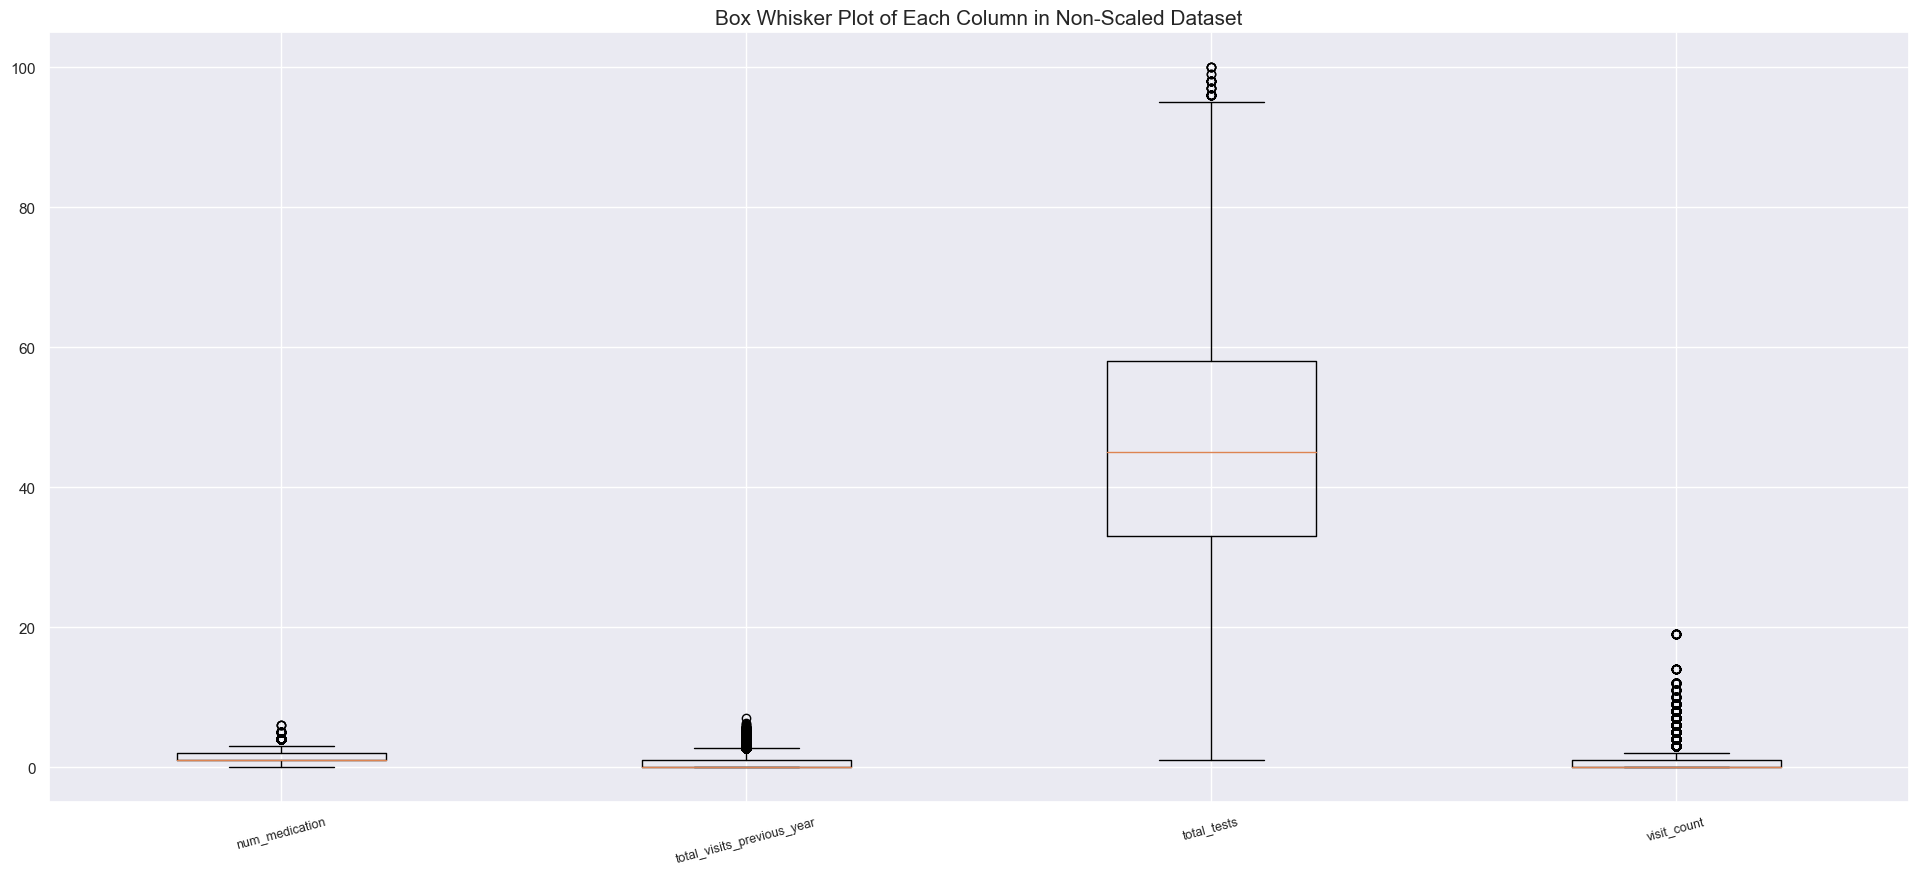

In [1685]:
num_feat = df_2[[col for col in df_2.columns if any(feature in col for feature in new_features)]]

# Boxplot
plt.figure(figsize=(24, 10))
plt.boxplot(num_feat.values)
plt.title("Box Whisker Plot of Each Column in Non-Scaled Dataset", fontsize=15)
plt.xticks(range(1, len(num_feat.columns) + 1), num_feat.columns, rotation=15)
plt.show()

In [1686]:
#numeric=X_train_binary.select_dtypes(exclude=['object', 'bool'])
#categorial = X_train_binary.select_dtypes(include=["object", 'bool'])
print('\n',"=================== Outliers =======================") 
for k, v in num_feat.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
        print(" %s outliers = %.2f%%" % (k, perc))

#Let's check skewness & kurtosis        
print('\n',"===================Skewness & Kurtosis =======================")       

for col in num_feat:    
    print (col, "Skew is:", num_feat[col].skew(), "Kurtosis is:", num_feat[col].kurtosis())


 =================== Outliers =======================
 num_medication outliers = 1.07%
 total_visits_previous_year outliers = 2.51%
 total_tests outliers = 0.06%
 visit_count outliers = 6.06%

 ===================Skewness & Kurtosis =======================
num_medication Skew is: 0.6853777424165987 Kurtosis is: 0.3038655417340155
total_visits_previous_year Skew is: 1.8032585404264259 Kurtosis is: 3.8215526748345208
total_tests Skew is: -0.25488155422854925 Kurtosis is: -0.29215490747436323
visit_count Skew is: 3.9546743761138563 Kurtosis is: 24.81345063467351


In [1687]:
def outliers_log(df):
    df['total_visits_previous_year'] = np.log1p(df['total_visits_previous_year'])
    df['visit_count']  = np.log1p(df['visit_count'])

outliers_log(df_2)
outliers_log(X_val_binary)
outliers_log(test)

In [1688]:
df_2 = df_2[df_2['total_tests'] < 95]

def outliers(df):
    
    mode = df_2['total_tests'].mode()[0]
    condition = df['total_tests'] >= 95
    df.loc[condition, 'total_tests'] = mode

outliers(X_val_binary)
outliers(test)

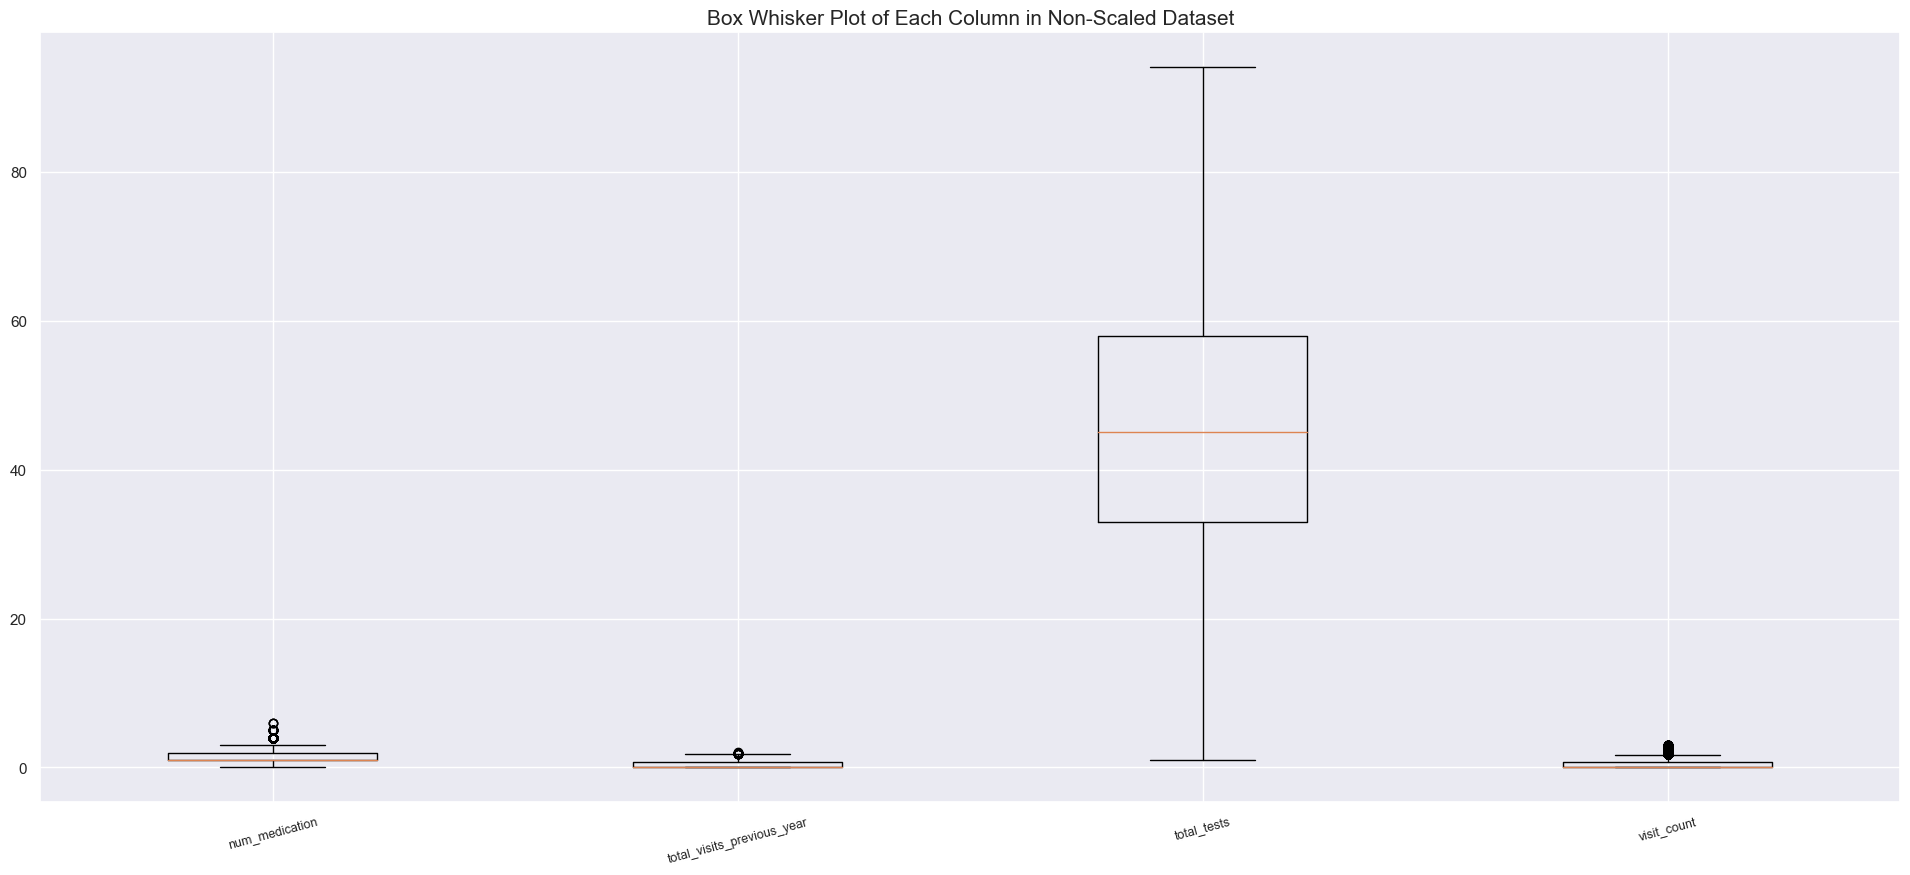

In [1689]:
num_feat = df_2[[col for col in df_2.columns if any(feature in col for feature in new_features)]]

# Boxplot
plt.figure(figsize=(24, 10))
plt.boxplot(num_feat.values)
plt.title("Box Whisker Plot of Each Column in Non-Scaled Dataset", fontsize=15)
plt.xticks(range(1, len(num_feat.columns) + 1), num_feat.columns, rotation=15)
plt.show()

In [1690]:
new_features_cat = ['is_male',
                    'healthy_heartrate',
                    'glucose_test_result',
                    'a1c_test_result',
                    'has_insurance',
                    'insulin',
                    'metformin',
                    'is_inpatient',
                    'race_AfricanAmerican',
                    # 'race_Asian',
                    'race_Caucasian',
                    'race_Hispanic',
                    'race_Other',
                    'discharged_home']
                    # 'critical_age',
                    # 'critical_length_in_hopsital',
                    # 'critical_amount_lab_test',
                    # 'critical_amount_of_medication',
                    # 'critical_amount_of_diagnoses',
                    # 'critical_amount_of_visits_this_year']


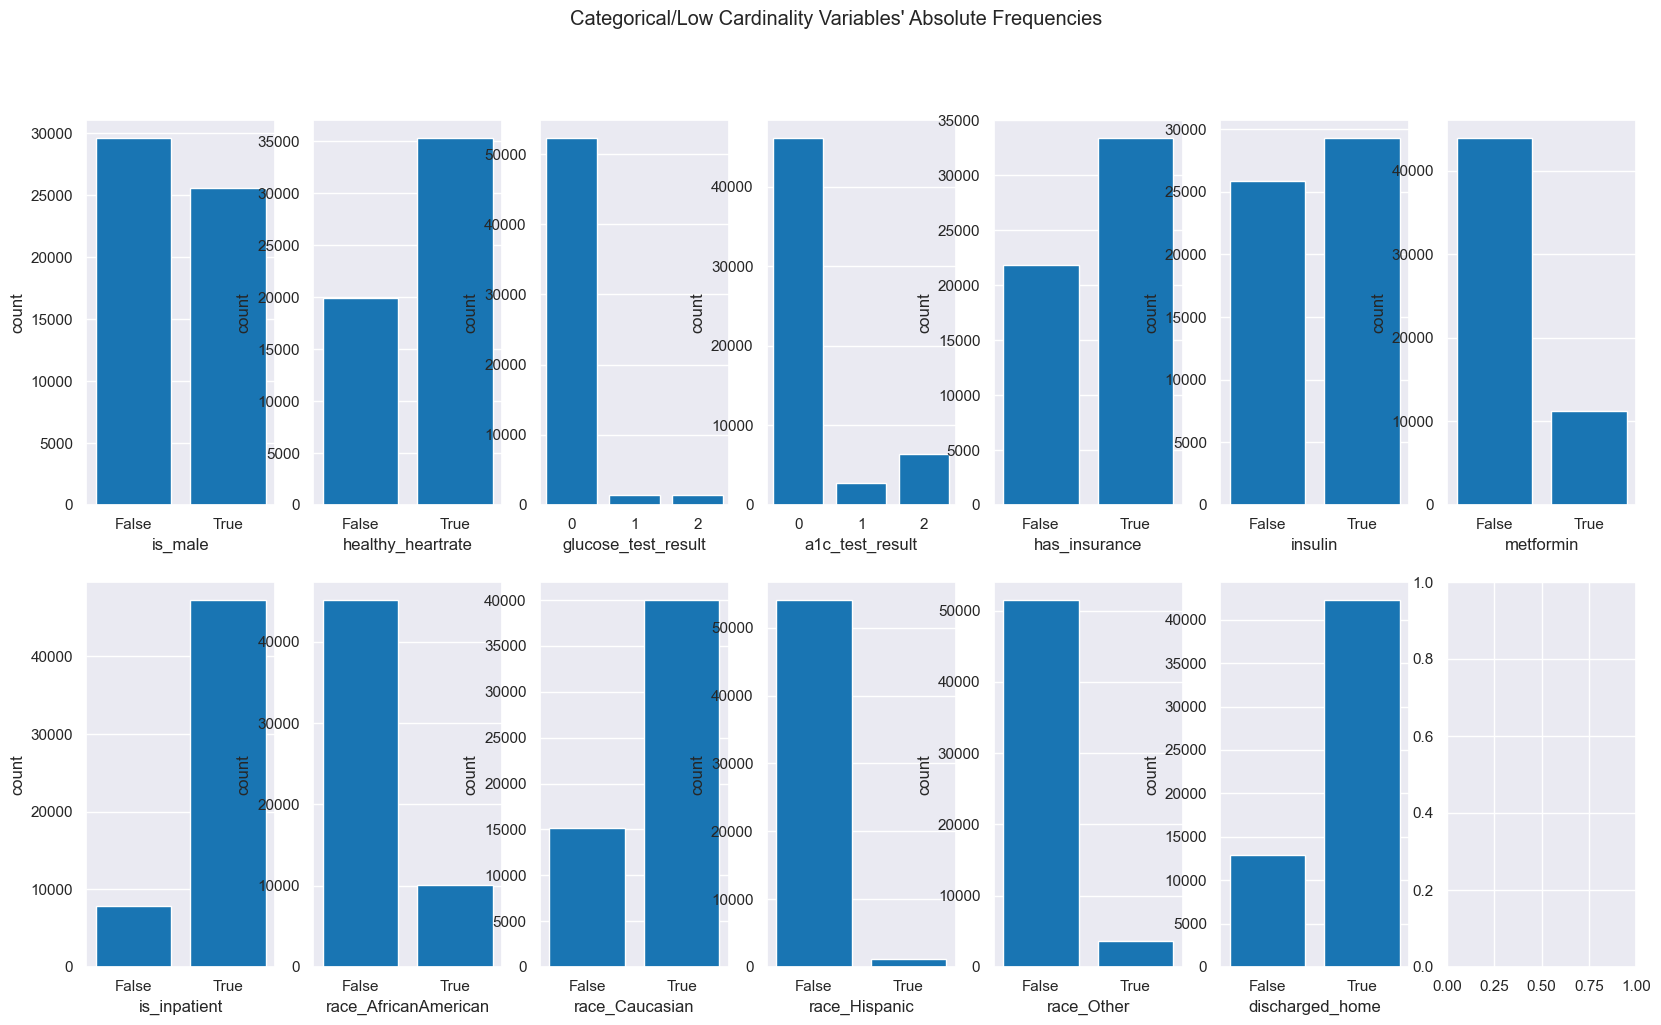

In [1691]:
# bad bar charts, impossible to read -> represent 1 by 1

# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(new_features_cat) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), new_features_cat): # Notice the zip() function and flatten() method
    sns.countplot(x=df_2[feat].astype(object), ax=ax, color='#007acc')

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)

plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'categorical_variables_frequecies.png'), dpi=200)
plt.show()

In [1692]:
categorical_columns = df_2.select_dtypes(include=['object', 'bool']).columns

# Create a new DataFrame to store unique values
unique_values_df = pd.DataFrame(columns=['Column', 'Unique_Values'])

# Populate the new DataFrame
for column in categorical_columns:
    unique_values = df_2[column].astype('str').unique()
    unique_values_df = pd.concat([unique_values_df, pd.DataFrame({'Column': [column], 'Unique_Values': [unique_values]})], ignore_index=True)

# Display the new DataFrame with multiple lines for large unique values
pd.set_option('display.max_colwidth', None)
unique_values_df

,Column,Unique_Values
0,is_male,"[False, True]"
1,has_insurance,"[False, True]"
2,admission_type,"[Emergency, Urgent, Elective]"
3,medical_specialty,"[Family/GeneralPractice, Surgery, InternalMedicine, Radiology, Other, Emergency, Cardiology, Orthopedics, Pulmonology, Nephrology, Hematology/Oncology]"
4,healthy_heartrate,"[True, False]"
5,discharged_home,"[True, False]"
6,admission_source,"[Emergency Room, Referral, Transfer]"
7,primary_diagnosis,"[Circulatory, Injury/Poisoning, Respiratory, Diabetes, Other, Musculoskeletal, Digestive, Genitourinary, Endocrine/Metabolic/Immunity, Skin, Neoplasm, Syndromes, Infection]"
8,secondary_diagnosis,"[Genitourinary, Endocrine/Metabolic/Immunity, Circulatory, Musculoskeletal, Respiratory, Other, Syndromes, Injury/Poisoning, Diabetes, Digestive, Skin, Neoplasm, Infection]"
9,additional_diagnosis,"[Digestive, Genitourinary, Respiratory, Circulatory, Musculoskeletal, Other, Infection, Diabetes, Injury/Poisoning, Endocrine/Metabolic/Immunity, Skin, Syndromes, Neoplasm]"


# --------------------

In [1693]:
lost_data = 100 - df_2.shape[0]/ intial_nr_records * 100
print('Percentage of data that was removed:', round(lost_data, 3) , '%')

Percentage of data that was removed: 3.25 %


In [1694]:
y_train_binary = y_train_binary.loc[df_2.index]

In [1695]:
%store df_2
%store y_train_binary
%store X_val_binary
%store y_val_binary
%store metric_features
%store non_metric_features
%store test

Stored 'df_2' (DataFrame)
Stored 'y_train_binary' (DataFrame)
Stored 'X_val_binary' (DataFrame)
Stored 'y_val_binary' (DataFrame)
Stored 'metric_features' (list)
Stored 'non_metric_features' (list)
Stored 'test' (DataFrame)


In [1696]:
df_2.isna().sum()

is_male                                  0
age                                      0
has_insurance                            0
outpatient_visits_in_previous_year       0
emergency_visits_in_previous_year        0
inpatient_visits_in_previous_year        0
admission_type                           0
medical_specialty                        0
healthy_heartrate                        0
discharged_home                          0
admission_source                         0
length_of_stay_in_hospital               0
number_lab_tests                         0
non_lab_procedures                       0
number_of_medications                    0
primary_diagnosis                        0
secondary_diagnosis                      0
additional_diagnosis                     0
number_diagnoses                         0
glucose_test_result                      0
a1c_test_result                          0
change_in_meds_during_hospitalization    0
num_medication                           0
metformin  

In [1697]:
X_val_binary.isna().sum()

is_male                                  0
age                                      0
has_insurance                            0
outpatient_visits_in_previous_year       0
emergency_visits_in_previous_year        0
inpatient_visits_in_previous_year        0
admission_type                           0
medical_specialty                        0
healthy_heartrate                        0
discharged_home                          0
admission_source                         0
length_of_stay_in_hospital               0
number_lab_tests                         0
non_lab_procedures                       0
number_of_medications                    0
primary_diagnosis                        0
secondary_diagnosis                      0
additional_diagnosis                     0
number_diagnoses                         0
glucose_test_result                      0
a1c_test_result                          0
change_in_meds_during_hospitalization    0
num_medication                           0
metformin  

In [1698]:
X_train_combined = pd.concat([df_2, y_train_binary], axis=1)

In [1699]:
categorical = df_2.select_dtypes(include=['category','bool','object']).columns
print(categorical.values)

['is_male' 'has_insurance' 'admission_type' 'medical_specialty'
 'healthy_heartrate' 'discharged_home' 'admission_source'
 'primary_diagnosis' 'secondary_diagnosis' 'additional_diagnosis'
 'glucose_test_result' 'a1c_test_result'
 'change_in_meds_during_hospitalization' 'metformin' 'insulin'
 'prescribed_diabetes_meds' 'is_inpatient' 'race_AfricanAmerican'
 'race_Caucasian' 'race_Hispanic' 'race_Other']


In [1700]:

categorical_columns = X_train_combined[categorical.values].columns

result_df = pd.DataFrame(columns=['Variable', 'Value', 'Number of Encounters', '% of Population', 'Nr. of Encounters (Readmitted)', '% in Group (Readmitted)'])

for column in categorical_columns:
    unique_values = X_train_combined[column].unique()

    # Iterate through each unique value in the categorical column
    for value in unique_values:
        subset = X_train_combined[X_train_combined[column] == value]
        column_counts = len(subset)
        column_percentage = round((column_counts / len(X_train_combined)) * 100, 1)
        column_readmitted = subset[subset['readmitted_binary'] == 1][column].count()
        column_readmitted_percentage = round((column_readmitted / column_counts) * 100, 1)

        # Append results to the DataFrame
        result_df = pd.concat([result_df, pd.DataFrame({
            'Variable': [column],
            'Value': [value],
            'Number of Encounters': [column_counts],
            '% of Population': [column_percentage],
            'Nr. of Encounters (Readmitted)': [column_readmitted],
            '% in Group (Readmitted)': [column_readmitted_percentage]
        })], ignore_index=True)

result_df

,Variable,Value,Number of Encounters,% of Population,Nr. of Encounters (Readmitted),% in Group (Readmitted)
0,is_male,False,29570,53.6,3360,11.4
1,is_male,True,25566,46.4,2789,10.9
2,has_insurance,False,21783,39.5,2513,11.5
3,has_insurance,True,33353,60.5,3636,10.9
4,admission_type,Emergency,34870,63.2,3955,11.3
...,...,...,...,...,...,...
83,race_Caucasian,False,15158,27.5,1527,10.1
84,race_Hispanic,False,54028,98.0,6029,11.2
85,race_Hispanic,True,1108,2.0,120,10.8
86,race_Other,False,51452,93.3,5902,11.5


In [1701]:
numerical = df_2.select_dtypes(exclude=['category', 'bool', 'object']).columns
numerical

Index(['age', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'length_of_stay_in_hospital',
       'number_lab_tests', 'non_lab_procedures', 'number_of_medications',
       'number_diagnoses', 'num_medication', 'total_visits_previous_year',
       'total_tests', 'visit_count'],
      dtype='object')

In [1702]:
numerical_columns = X_train_combined[numerical.values].columns

# Create a DataFrame to store the results for numerical variables
numerical_result_df = pd.DataFrame(columns=['Variable', 'Mean', 'Median', '1st Quartile', '3rd Quartile'])

# Iterate through each numerical column
for column in numerical_columns:
    column_mean = X_train_combined[column].mean()
    column_median = X_train_combined[column].median()
    column_1st_quartile = X_train_combined[column].quantile(0.25)
    column_3rd_quartile = X_train_combined[column].quantile(0.75)

    # Append results to the DataFrame
    numerical_result_df = pd.concat([numerical_result_df, pd.DataFrame({
        'Variable': [column],
        'Mean': [column_mean],
        'Median': [column_median],
        '1st Quartile': [column_1st_quartile],
        '3rd Quartile': [column_3rd_quartile]
    })], ignore_index=True)

numerical_result_df


,Variable,Mean,Median,1st Quartile,3rd Quartile
0,age,66.399630,65.000000,55.000000,75.000000
1,outpatient_visits_in_previous_year,0.171786,0.000000,0.000000,0.000000
2,emergency_visits_in_previous_year,0.102601,0.000000,0.000000,0.000000
3,inpatient_visits_in_previous_year,0.326451,0.000000,0.000000,0.693147
4,length_of_stay_in_hospital,4.179538,4.000000,2.000000,6.000000
5,number_lab_tests,42.711767,44.000000,31.000000,57.000000
6,non_lab_procedures,1.315583,1.000000,0.000000,2.000000
7,number_of_medications,2.711481,2.772589,2.397895,3.044522
8,number_diagnoses,7.413305,8.000000,6.000000,9.000000
9,num_medication,1.177815,1.000000,1.000000,2.000000
